# power_by_pl_fr.ipynb

In [1]:
# General
import sys
import os
import glob
from time import time
from collections import OrderedDict
od = OrderedDict
from importlib import reload
from glob import glob
import itertools

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Neuro
import mne
from ptsa.data.TimeSeriesX import TimeSeries 
#import neurodsp

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
from eeg_plotting import plot_trace, plot_trace2

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+4)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)
labelfontsize = 10
tickfontsize = 10
figfontsize = 14
labfs = labelfontsize
tickfs = tickfontsize
figfs = figfontsize

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ptsa/data/TimeSeriesX.py:7: DeprecationWarning: importing from ptsa.data.TimeSeries is deprecated; import from ptsa.data.timeseries instead
  DeprecationWarning)


In [2]:
# Inches for 1, 1.5, and 2 column width.
colws = od([(1, 3.34646), (1.5, 4.48819), (2, 6.85039)])

In [3]:
# Get session info.
subj_df = phase_locking.get_subj_df()
subj_df.insert(4, 'chan_ind', subj_df.chan.apply(lambda x: int(x)-1))

freqs = np.array([2**((i/2) - 1) for i in range(16)])
sampling_rate = 2000
time_win=2

input_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'

power_fname = os.path.join(input_dir, 'wavelet', 'power', 
                           'power-Z-log-{}-iChan{}-iFreq{}-2000Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
spike_fname = os.path.join(input_dir, 'spike_inds', 'spike_inds-2000Hz-{}-unit{}.pkl')
fr_fname = os.path.join(input_dir, 'spike_frs', 'spike_frs-2000Hz-{}-unit{}.pkl')
pl_fname = os.path.join(input_dir, 'phase_locking', 'unit_to_region', 
                        'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')

In [542]:
reload(phase_locking)

<module 'phase_locking' from '/home1/dscho/code/projects/unit_activity_and_hpc_theta/phase_locking.py'>

In [4]:
# Load phase-locking stats.
start_time = time()

if True:
    # Load the unit-to-region phase-locking DataFrame.
    pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region'
    pl_fname = os.path.join(pl_dir, 'all_phase_locking_stats-14026_unit_to_region_pairs-2000Hz-notch60_120Hz-5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
    pl_df = phase_locking.load_pl_df(pl_fname)
else:
    pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region'
    pl_files = glob(os.path.join(pl_dir, 'phase_locking_stats*.pkl'))
    pl_df = pd.DataFrame(dio.open_pickle(pl_files[0])).T
    for f in pl_files[1:]:
        pl_df = pl_df.append(dio.open_pickle(f))
    pl_df.reset_index(drop=True, inplace=True)

print(pl_df.shape, pl_df.query("(edge=='ctx-hpc')").shape)

print('Done in {:.2f} secs'.format(time() - start_time))

(13793, 56) (2405, 56)
Done in 12.73 secs


In [ ]:
# Perform FDR correction (separately for ipsilateral and contralateral
# comparisons within each edge type).
alpha = 0.05
pl_df['sig_z'] = pl_df['bs_pval_z'] < alpha
pl_df['sig_z_fdr'] = False
for edge_type in np.unique(pl_df.edge):
    for same_hem in [True, False]:
        pvals_in = np.array(pl_df.loc[(pl_df.edge==edge_type) & (pl_df.same_hem==same_hem)].bs_pval_z.tolist())
        if len(pvals_in) > 0:
            output = sm.stats.multipletests(pvals_in, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)
            sig_out = list(output[0])
            pl_df.loc[(pl_df.edge==edge_type) & (pl_df.same_hem==same_hem), 'sig_z_fdr'] = sig_out

In [545]:
# # Update phase-locking parameters.
# start_time = time()

# n_updated = {'sig': 0, 'nsig': 0}
# for idx, row in pl_df.iterrows():
#     new_pl_params, updated = phase_locking.update_pl_freq_time(pl_df.loc[idx])
    
#     if updated:
#         for key in new_pl_params.keys():
#             pl_df.at[idx, key] = new_pl_params[key]
        
#         if row['sig_z_fdr']:
#             n_updated['sig'] += 1
#         else:
#             n_updated['nsig'] += 1
    
# pl_df['pl_latency'] = np.abs(pl_df['pl_time_shift'])
    
# print('{}/{} ({:.1f}%) significant phase-locking parameters updated'.format(n_updated['sig'], len(pl_df.loc[pl_df['sig_z_fdr']==True]), 
#                                                                             100 * n_updated['sig'] / len(pl_df.loc[pl_df['sig_z_fdr']==True])), end='\n\n')
# print('{}/{} ({:.1f}%) insignificant phase-locking parameters updated'.format(n_updated['nsig'], len(pl_df.loc[pl_df['sig_z_fdr']==False]), 
#                                                                               100 * n_updated['sig'] / len(pl_df.loc[pl_df['sig_z_fdr']==False])), end='\n\n')

# print('Done in {:.2f} secs'.format(time() - start_time))

430/3113 (13.8%) significant phase-locking parameters updated

477/10680 (4.0%) insignificant phase-locking parameters updated

Done in 27.26 secs


In [512]:
for edge_type in np.unique(pl_df.edge):
        for same_hem in [True, False]:
            print(edge_type, same_hem, pl_df.loc[(pl_df.edge==edge_type) & (pl_df.same_hem==same_hem)].shape)

ctx-ctx True (3683, 56)
ctx-ctx False (3739, 56)
ctx-hpc True (1233, 56)
ctx-hpc False (1172, 56)
ctx-local True (1453, 56)
ctx-local False (0, 56)
hpc-ctx True (961, 56)
hpc-ctx False (876, 56)
hpc-hpc True (57, 56)
hpc-hpc False (295, 56)
hpc-local True (324, 56)
hpc-local False (0, 56)


In [557]:
(pl_df
 .query("(same_hem==True)")
 .groupby(['edge'])
 .agg({'unit': len, 'sig_z_fdr': np.mean}))

unit  sig_z_fdr
edge                      
ctx-ctx    3683   0.117024
ctx-hpc    1233   0.293593
ctx-local  1453   0.830695
hpc-ctx     961   0.316337
hpc-hpc      57   0.631579
hpc-local   324   0.947531

In [558]:
(pl_df
 .query("(sig_z_fdr==True) & (same_hem==True)")
 .groupby('edge')
 .agg({'unit': len, 'pl_strength': np.mean, 'locked_freq_ind_z': np.mean, 'pl_freq': np.mean, 'pl_time_shift': np.mean, 'pl_latency': np.mean}))

unit  pl_strength  locked_freq_ind_z    pl_freq  pl_time_shift  \
edge                                                                        
ctx-ctx     431     8.883567           5.211137   5.245940    -104.222738   
ctx-hpc     362     8.948787           5.174033   5.143646     -60.745856   
ctx-local  1207    11.641962          10.566694  10.338028     -27.357084   
hpc-ctx     304     8.786580           5.417763   5.509868     -64.407895   
hpc-hpc      36     8.714774           4.027778   4.138889    -131.111111   
hpc-local   307    15.489058           7.996743   7.794788     -58.110749   

           pl_latency  
edge                   
ctx-ctx    200.974478  
ctx-hpc    146.215470  
ctx-local  129.378625  
hpc-ctx    168.355263  
hpc-hpc    158.888889  
hpc-local  126.449511

In [79]:
time_win = 2
sampling_rate = 2000
time_steps = np.arange(-time_win*sampling_rate, time_win*sampling_rate+1, sampling_rate*0.01, dtype=int)
time_steps_ms = (time_steps / sampling_rate) * 1000

In [99]:
# For all cortical neurons that are phase-locked to HPC LFP,
# get the preferred phase and phase offset for each spike when
# referenced to the local LFP at the HPC LFP preferred frequency.
# This info is appended to the unit-to-region phase-locking Series 
# and saved to /.../unit_to_region_for_power/sig
# and /.../unit_to_region_for_power/nsig (for insignificant comparisons)
start_time = time()

overwrite = True

hpc_pl_df = pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)").reset_index(drop=True).copy()
n_saved = 0
missing_pl_files = []
missing_phase_files = []
for index, hpc_row in hpc_pl_df.iterrows():
    subj_sess = hpc_row.subj_sess
    unit = hpc_row.unit
    lfp_roi = hpc_row.lfp_hemroi
    hpc_locked_iFreq = hpc_row.pl_freq
    hpc_locked_iTimeLag = int(-hpc_row.pl_time_shift * 2)
    
    # Update phase offsets.
    pref_phase, phase_offsets = phase_locking.phase_offsets_by_spike(hpc_row, hpc_locked_iFreq, hpc_locked_iTimeLag)
    hpc_row['pref_phase_tl_locked_time_freq_z'] = pref_phase
    hpc_row['phase_offsets_tl_locked_time_freq_z'] = phase_offsets
    
    # Get phase offsets to the local LFP.
    try:
        local_row = pl_df.query("(subj_sess=='{}') & (unit=={}) & (same_hemroi==True)".format(subj_sess, unit)).iloc[0]
    except IndexError:
        missing_pl_files.append('{}-unit_{}-lfp_{}'.format(local_row.subj_sess, local_row.unit, local_row.lfp_hemroi))
        continue
        
    try:
        local_pref_phase, local_phase_offsets = phase_locking.phase_offsets_by_spike(local_row, hpc_locked_iFreq, hpc_locked_iTimeLag)
    except FileNotFoundError:
        missing_phase_files.append('{}-unit_{}-lfp_{}-iChans_{}'.format(local_row.subj_sess, local_row.unit,
                                                                        local_row.lfp_hemroi, '_'.join([str(x) for x in local_row.lfp_chan_inds])))
        continue
    
    hpc_row['local_lfp_chan_inds'] = local_row.lfp_chan_inds # doens't include the channel that the unit was recorded on
    hpc_row['local_pref_phase'] = local_pref_phase
    hpc_row['local_phase_offsets'] = local_phase_offsets
    
    # Add the off-target LFP chan inds (channels that are not part of the unit or target LFP's microwire bundle)
    off_target_chan_inds = OrderedDict()
    off_target_rois = [x for x in np.unique(subj_df.query("(subj_sess=='{}')".format(subj_sess)).location) 
                       if x not in [hpc_row.unit_hemroi, hpc_row.lfp_hemroi]]
    for roi in off_target_rois:
        off_target_chan_inds[roi] = list(np.unique(subj_df.query("(subj_sess=='{}') & (location=='{}')".format(subj_sess, roi)).chan_ind))
    hpc_row['off_target_chan_inds'] = off_target_chan_inds
    
    # Drop these fields that take up a ton of hard drive space
    hpc_row.drop(['bs_mrls', 'tl_mrls', 'bs_mrls_z', 'tl_mrls_z', 'mrls_z'], inplace=True)
    
    # Save
    fname = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power/sig',
                         'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                         .format(subj_sess, unit, lfp_roi))
    if (overwrite) or (not os.path.exists(fname)):
        dio.save_pickle(hpc_row, fname, verbose=False)
        n_saved += 1

print('sig')
print('{} are missing phase-locking files; {} units are missing phase files'.format(len(missing_pl_files), len(missing_phase_files)))
print('Saved {}/{} files'.format(n_saved, len(hpc_pl_df)))

print('Done in {:.2f} secs'.format(time() - start_time))

sig
0 are missing phase-locking files; 0 units are missing phase files
Saved 362/362 files
Done in 297.17 secs


In [3]:
# info = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power/sig',
#                                     'phase_locking_stats-U371_env1-unit_48-lfp_LPH-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'))
info = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power/sig',
                                    'phase_locking_stats-U387_ses3-unit_18-lfp_RAH-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'))

## Functions

In [4]:
def calc_power_by_pl_fr_unit_to_target_region(info,
                                              n_freqs=16,
                                              n_bootstraps=1000,
                                              sampling_rate=2000,
                                              sigma=250, # SD of the firing rate Gaussian kernel in ms
                                              fr_sync_win=250, # size of the window over which synchrony is calculcated in ms
                                              time_win=2,
                                              test_phase_offsets=True, # if False, only assess spikes by firing rate
                                              subtract_mean=True,
                                              input_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                              save_outputs=True,
                                              overwrite=False,
                                              output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/sig',
                                              sleep_max=0):
    """Obtain power values for highly phase-locked or high firing spikes.
    
    The following steps are performed in reference to the mean power
    across channels for each depth electrode. The HPC region that 
    phase relations were taken in reference to is referred to as the
    "target" region, and the neuron's region of origin is called the
    "local" region and does not include the neuron's own channel.
    
    We find the 20% of spikes that fired:
    1) Closest to the preferred phase at the preferred phase-locked 
       frequency, in reference to the target (i.e. HPC) LFP.
    2) Closest to the preferred phase in reference to the local
       LFP, but at the preferred target LFP phase-locking frequency
    3) With the highest firing rate
    
    We then get:
    1) The mean power across spikes at each frequency,
       for each of these spike categories. 
    2) The Pearson correlation of power at each frequency across spikes,
       for each of these spike categories.
    
    Mean power and power correlation vectors for each spike category 
    are Z-scored against a null distribution of randomly selected spikes 
    (20% of spikes for each permutation). 
    
    We return a dictionary with:
    1) The Z-power vector for each spike category.
    2) A p-value and some associated metrics for each spike category.
       The p-value is determined from a permutation test in which we compare
       the max(|z_power|) across frequencies against the null distribution 
       of max(|z_power|) from each permutation. This test enables us to detect 
       spike subsets that showed significantly higher or lower power at any 
       frequency, compared to the null distribution of spikes drawn at random.
    3) The Z-power correlation vector for each spike category.
    4) A p-value and some associated metrics for each spike category,
       using the same logic as in (2) but with Z-power correlations rather
       than Z-power at each frequency.
    """
    def bootstrap_p(obs, null):
        """Derive an empirical p-value.

        The maximum |Z-score| (across frequencies) is compared
        against the null distribution of maximum |Z-scores|.

        obs : n_freq vec
        null : n_freq x n_boot array
        """
        n_bootstraps = null.shape[-1]

        if len(null.shape) == 1:
            max_obs = np.abs(obs)
            max_null = np.abs(null)
            bs_ind = np.sum(max_null >= max_obs)
            pval = (1 + bs_ind) / (1 + n_bootstraps)

            return OrderedDict([('max_z', obs),
                                ('max_z_ind', 0),
                                ('bs_ind', bs_ind),
                                ('pval', pval)])
        else:
            max_obs = np.max(np.abs(obs))
            max_null = np.max(np.abs(null), axis=0)
            bs_ind = np.sum(max_null >= max_obs)
            pval = (1 + bs_ind) / (1 + n_bootstraps)

            # Get the Z-score and index of max(|Z|)
            max_z_ind = np.argmax(np.abs(obs))
            max_z = obs[max_z_ind]

            return OrderedDict([('max_z', max_z),
                                ('max_z_ind', max_z_ind),
                                ('bs_ind', bs_ind),
                                ('pval', pval)])
    
    # Check if output file already exists.
    subj_sess = info.subj_sess
    unit = info.unit
    lfp_roi = info.lfp_hemroi
    output_fname = 'power_by_phase_locking_and_fr-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
    fpath = os.path.join(output_dir, output_fname.format(subj_sess, unit, lfp_roi))
    if os.path.exists(fpath) and not overwrite:
        output = dio.open_pickle(fpath)
        return output
    
    # Take a nap before running.
    if sleep_max > 0:
        sleep(int(sleep_max * np.random.rand()))
        
    # General params.
    power_fname = os.path.join(input_dir, 'wavelet', 'power', 
                               'power-Z-log-{}-iChan{}-iFreq{}-2000Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
    pl_fname = os.path.join(input_dir, 'phase_locking', 'unit_to_region', 
                            'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
    
    # Get phase offsets for each spike.
    spike_inds = info.spike_inds
    target_phase_offsets = info.phase_offsets_tl_locked_time_freq_z
    assert len(spike_inds) == len(target_phase_offsets)
    
    # Cut spikes from the beginning so vectors are divisible by 5.
    cut = len(spike_inds) % 5
    spike_inds = spike_inds[cut:]
    target_phase_offsets = target_phase_offsets[cut:]
    n_spikes = len(spike_inds)
    n_samp = int(n_spikes / 5) # 20% of all spikes
    
    # Setup the spike categories.
    sel_spikes = np.where(target_phase_offsets<=np.percentile(target_phase_offsets, 20))[0]
    
    # Select 20% of spikes at random for each bootstrap iteration.
    bs_spike_inds = []
    for iBoot in range(n_bootstraps):
        bs_spike_inds.append(np.random.choice(n_spikes, n_samp, replace=False))
    
    
    
    sigma_ = sigma * (sampling_rate*1e-3) # ms to samples
    
    
    
    # Assess LFP power (mean across channels) at each frequency,
    # at each spike time, for channels in:
    # 1) the target region
    # 2) the unit's region (excluding the unit's channel) 
    # 3) each off-target region
    lfp_power_rois = info.off_target_chan_inds # an OrderedDict([(roi : str, chan_inds : list)])
    lfp_power_rois['local'] = info.local_lfp_chan_inds
    lfp_power_rois['target'] = info.lfp_chan_inds
    lfp_power_rois = OrderedDict(reversed(list(lfp_power_rois.items())))
    
    # Get LFP power across frequencies at each spike time, taking the mean
    # power across channels in a region at each frequency and spike time
    power = []
    for lfp_power_roi, lfp_chan_inds in lfp_power_rois.items():
        power.append(np.mean([[dio.open_pickle(power_fname.format(subj_sess, iChan, iFreq))[spike_inds] for iFreq in range(n_freqs)]
                              for iChan in lfp_chan_inds], axis=0))
    power = np.array(power) # roi x freq x spike
    
    # Get the cross-frequency power correlation between all possible
    # pairs of regions, for each spike, and keep track of which pair
    # compares the local region to the target region
    local_ind = list(lfp_power_rois.keys()).index('local')
    target_ind = list(lfp_power_rois.keys()).index('target')
    roi_pairs = [(x, y) for x in range(len(lfp_power_rois)) for y in range(len(lfp_power_rois)) if x<y]
    local_target_ind = roi_pairs.index((local_ind, target_ind)) # should be 0
    
    # Get the mean firing rate (Z-scored over time) across
    # neurons in each region, at each spike time. Excludes
    # data from the neuron's own channel.
    _, fr_df, *_ = load_spikes(subj_sess)
    spike_train = fr_df.query("(clus=={})".format(unit)).iloc[0]['spikes'].astype(np.float32)
    unit_fr = gaussian_filter(spike_train, sigma_) * sampling_rate # spikes/sec
    roi_frs = OrderedDict([])
    for iRoi, df in fr_df.query("(chan!='{}')".format(info.unit_chan_ind+1)).groupby('location'):
        roi_frs[iRoi] = np.mean([stats.zscore(x) for x in df['fr'].tolist()], axis=0)
        mua = np.sum(df['spikes'].tolist(), axis=0, dtype=np.float32)
        roi_frs[iRoi] = gaussian_filter(mua, sigma_)  * sampling_rate # spikes/sec

    # Check that the target region has neurons!
    if not lfp_roi in roi_frs:
        return False
    
            
    
    spike_powers = OrderedDict([])
    for iRoi, roi in enumerate(lfp_power_rois.keys()):
        # Get power at each freq and time for the 20% of spikes that fired
        # closest to the preferred phase.
        spike_powers[key] = np.mean(power[iRoi, :, sel_spikes], axis=1) # freq; mean over spikes

        # Get the firing rate synchrony between the neuron
        # and multi-unit activity in the region.
        

    # Create a null distribution of powers at each frequency from random spike subsets.
    bs_powers = np.swapaxes([np.mean(power[:, bs_spike_inds[iBoot]], axis=1) for iBoot in range(n_bootstraps)], 0, 1) # freq x bs_index
    bs_means = np.expand_dims(np.mean(bs_powers, axis=-1), axis=-1) # mean at each freq
    bs_stds = np.expand_dims(np.std(bs_powers, axis=-1), axis=-1) # std at each freq
    bs_powers_z = ((bs_powers - bs_means) / bs_stds) # freq x bs_index
    
    bs_power_corrs = np.array([np.mean(power_corrs[bs_spike_inds[iBoot]]) for iBoot in range(n_bootstraps)]) # bs_index
    bs_corr_mean = np.mean(bs_power_corrs)
    bs_corr_std = np.std(bs_power_corrs)
    bs_power_corrs_z = (bs_power_corrs - bs_corr_mean) / bs_corr_std # bs_index
    
    # Z-score the powers at each frequency and get an empirical p-value for each spike category.
    power_pvals = OrderedDict([])
    power_corr_pvals = OrderedDict([])
        
    for key in spike_cat.keys():
        spike_powers[key] = (spike_powers[key] - np.squeeze(bs_means)) / np.squeeze(bs_stds) # freq
        power_pvals[key] = bootstrap_p(spike_powers[key], bs_powers_z)
        
        spike_power_corrs[key] = (spike_power_corrs[key] - bs_corr_mean) / bs_corr_std # scalar
        power_corr_pvals[key] = bootstrap_p(spike_power_corrs[key], bs_power_corrs_z)
    
    # Add to output
    output = OrderedDict([('z_power', spike_powers), 
                          ('power_pvals', power_pvals),
                          ('z_power_corrs', spike_power_corrs),
                          ('power_corr_pvals', power_corr_pvals)])

    # Save output.
    if save_outputs:
        dio.save_pickle(output, fpath, verbose=False)
        
    return output

In [20]:
info = dio.open_pickle(os.path.join('/home1/dscho/projects/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power/sig',
                                    'phase_locking_stats-U387_ses3-unit_6-lfp_LAH-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'))

In [291]:
sigma=250 # SD of the firing rate Gaussian kernel in ms
fr_sync_win=250 # size of the window over which synchrony is calculcated in ms
fr_sync_bound=250 # how far out we go in calculating fr_syncs
fr_sync_step_size=1 # time in ms between fr_sync steps

print(sigma, fr_sync_win, fr_sync_bound, fr_sync_step_size)

print(sigma, fr_sync_win, fr_sync_bound, fr_sync_step_size)

250 250 250 1
500 500 500 2


In [406]:
start_time = time()

# Function inputs.
n_freqs=16
n_bootstraps=1000
sampling_rate=2000
sigma=250 # SD of the firing rate Gaussian kernel in ms
fr_sync_win=250 # size of the window over which synchrony is calculcated in ms
fr_sync_bound=250 # how far out we go in calculating fr_syncs
fr_sync_step_size=1 # time in ms between fr_sync steps
time_win=2
test_phase_offsets=True # if False, only assess spikes by firing rate
subtract_mean=True
input_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'
save_outputs=False
overwrite=False
output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/sig'
sleep_max=0

# Check if output file already exists.
subj_sess = info.subj_sess
unit = info.unit
lfp_roi = info.lfp_hemroi
output_fname = 'power_by_phase_locking_and_fr-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
fpath = os.path.join(output_dir, output_fname.format(subj_sess, unit, lfp_roi))
if os.path.exists(fpath) and not overwrite:
    output = dio.open_pickle(fpath)
    #return output

# Take a nap before running.
if sleep_max > 0:
    sleep(int(sleep_max * np.random.rand()))

# General params.
power_fname = os.path.join(input_dir, 'wavelet', 'power', 
                           'power-Z-log-{}-iChan{}-iFreq{}-2000Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
pl_fname = os.path.join(input_dir, 'phase_locking', 'unit_to_region', 
                        'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
_, n_timepoints = dio.open_pickle(os.path.join(input_dir, 'spike_inds', 'spike_inds-{}Hz-{}-unit{}.pkl'
                                               .format(sampling_rate, subj_sess, unit)))

# Convert ms to samples.
sigma = int(sigma * sampling_rate * 1e-3)
fr_sync_win = int(fr_sync_win * sampling_rate * 1e-3)
fr_sync_bound = int(fr_sync_bound * sampling_rate * 1e-3)
fr_sync_step_size = int(fr_sync_step_size * sampling_rate * 1e-3)

# Get time steps.
steps = np.arange(-fr_sync_bound, fr_sync_bound+1, fr_sync_step_size)
t0 = np.where(steps==0)[0][0]

# Get phase offsets for each spike.
spike_inds = info.spike_inds
target_phase_offsets = info.phase_offsets_tl_locked_time_freq_z
assert len(spike_inds) == len(target_phase_offsets)

# Cut spikes from the beginning so vectors are divisible by 5.
cut = len(spike_inds) % 5
spike_inds = spike_inds[cut:]
target_phase_offsets = target_phase_offsets[cut:]
n_spikes = len(spike_inds)
n_samp = int(n_spikes / 5) # 20% of all spikes

# Find strongly phase-locked spikes.
sel_spikes = np.where(target_phase_offsets<=np.percentile(target_phase_offsets, 20))[0]

# Select 20% of spikes at random for each bootstrap iteration.
bs_spike_inds = []
for iBoot in range(n_bootstraps):
    bs_spike_inds.append(np.random.choice(n_spikes, n_samp, replace=False))
    
# Get a dictionary of electrode regions and their channel indices.
rois = info.off_target_chan_inds # an OrderedDict([(roi : str, chan_inds : list)])
rois['local'] = info.local_lfp_chan_inds
rois['target'] = info.lfp_chan_inds
rois = OrderedDict(reversed(list(rois.items())))

# Calculate firing rate vectors for the neuron and for
# multi-unit activity in each region by convolving binary
# spikes trains with a Gaussian kernel. (Note: MUA from
# the neuron's own region excludes the neuron's channel.)
_, fr_df, *_ = phase_locking.load_spikes(subj_sess)
unit_roi = info.unit_hemroi

unit_spikes = fr_df.query("(clus=={})".format(unit)).iloc[0]['spikes'].astype(np.float32)
# unit_fr = gaussian_filter(unit_spikes, sigma) * sampling_rate # spikes/sec

roi_spikes = OrderedDict([])
# roi_frs = OrderedDict([])
for roi, df in fr_df.query("(chan!='{}')".format(unit_chan_ind+1)).groupby('location'):
    if roi == unit_roi:
        roi = 'local'
    elif roi == lfp_roi:
        roi = 'target'
    spike_train = np.sum(df['spikes'].tolist(), axis=0, dtype=np.float32)
    spike_train[spike_train>0] = 1
    roi_spikes[roi] = spike_train
#     roi_frs[roi] = gaussian_filter(spike_train, sigma)  * sampling_rate # spikes/sec
    
# Combine the phase-locked spike indices and the matching
# bootstraped spike indices into a single list.
spike_ind_subsets = [sel_spikes]
spike_ind_subsets.extend(bs_spike_inds)

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 0.86 secs


In [339]:
# Get time steps.
steps = np.arange(-fr_sync_bound*10, fr_sync_bound*10+1, fr_sync_step_size*10)
t0 = np.where(steps==0)[0][0]

In [345]:
obs = fr_syncs[:, 0]
null = fr_syncs[:, 1:]
obs_z = (obs - np.mean(null, axis=1)) / np.std(null, axis=1)
fr_syncs.shape, obs.shape, null.shape, obs_z.shape

((501, 1001), (501,), (501, 1000), (501,))

In [397]:
roi = 'target'
fr_syncs = np.array([spike_triggered_fr_sync(unit_fr, 
                                             roi_frs[roi], 
                                             phase_locking.shift_spike_inds(spike_inds, n_timepoints, step), 
                                             spike_ind_subsets, 
                                             hwin=int(fr_sync_win/2))
                     for step in steps])
obs = fr_syncs[:, 0]
null = fr_syncs[:, 1:]
obs_z = (obs - np.mean(null, axis=1)) / np.std(null, axis=1)

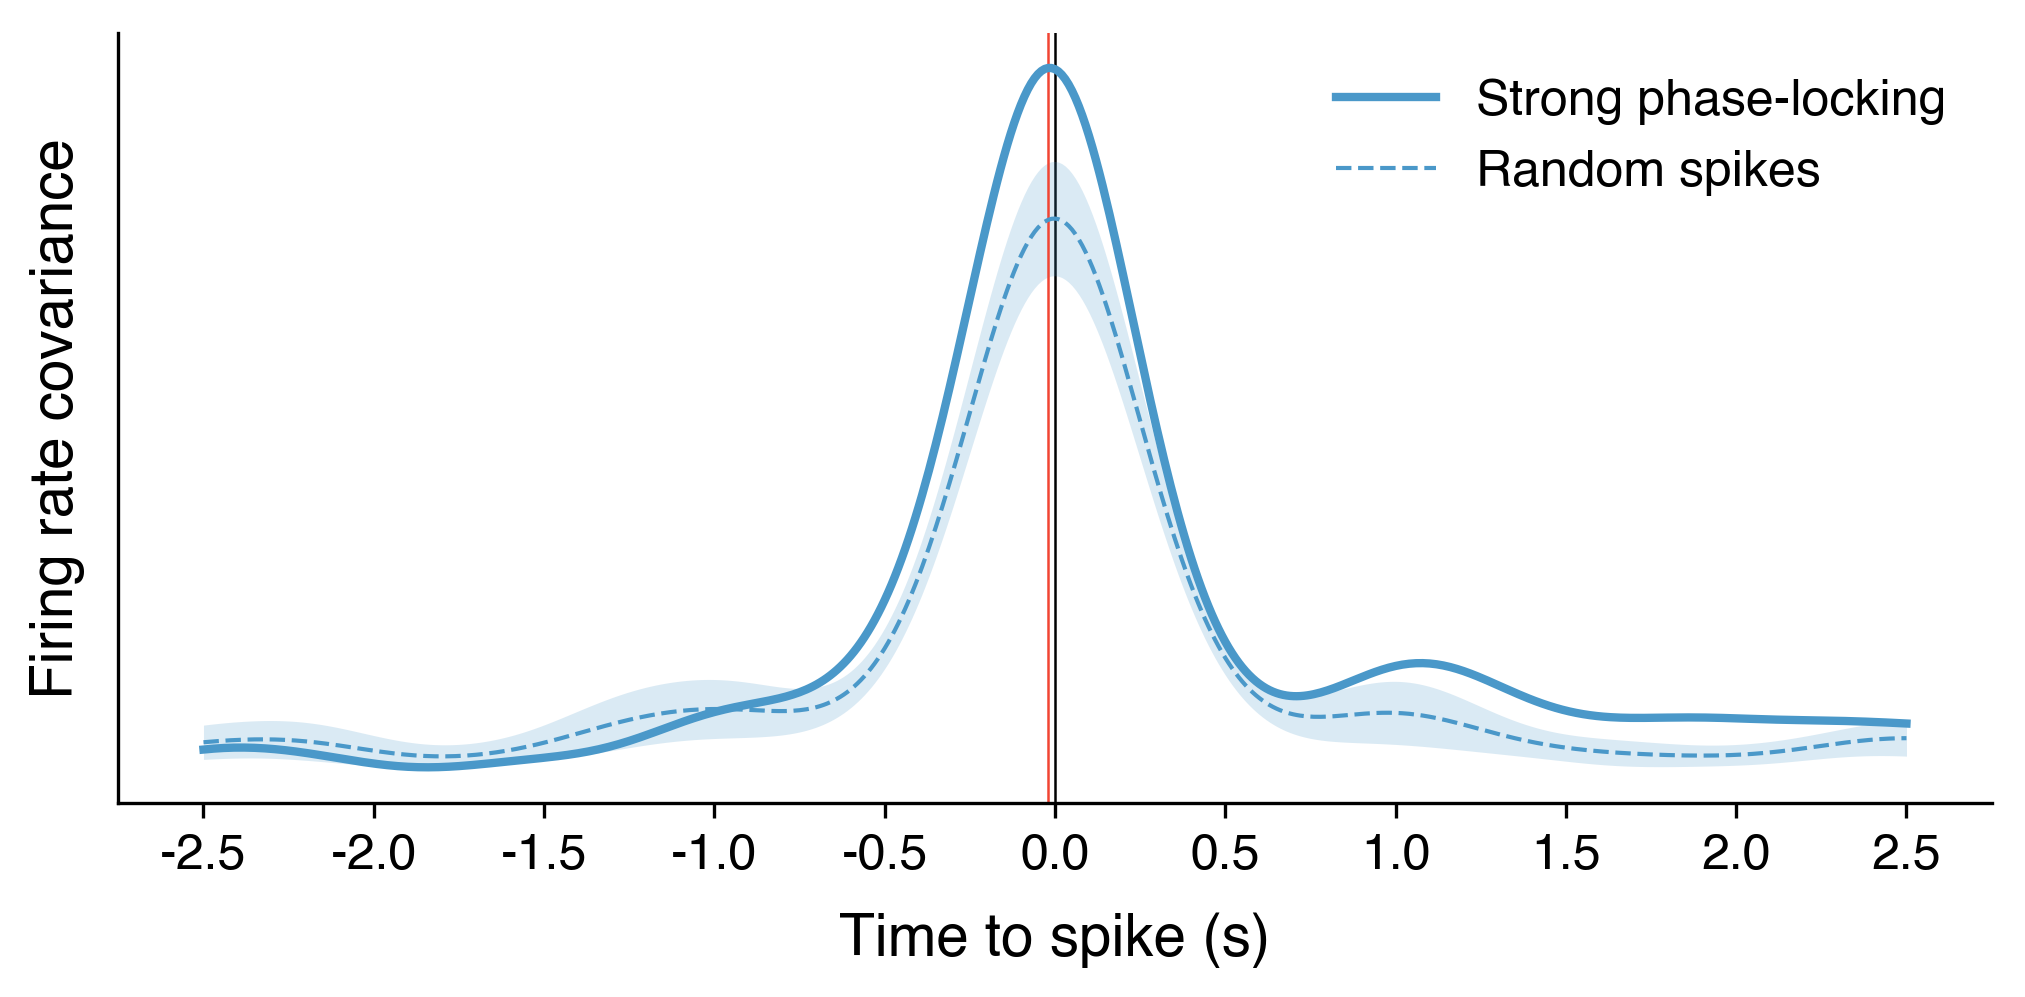

In [391]:
fig, ax = plt.subplots(1, 1, figsize=(colws[2], colws[2]*0.5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14

i = 0
ax[i].plot(obs, color=colors[0], linewidth=2)
ax[i].plot(np.mean(null, axis=1), color=colors[0], linewidth=1, linestyle='--')
ax[i].fill_between(np.arange(len(obs)), np.mean(null, axis=1) + np.std(null, axis=1), np.mean(null, axis=1) - np.std(null, axis=1),
                   color=colors[0], alpha=0.2, linewidth=0)
ax[i].axvline(250, color='k', linewidth=0.6, zorder=0, alpha=1)
ax[i].axvline(np.argmax(obs), color=colors[1], linewidth=0.6, zorder=1, alpha=1)
ax[i].set_xticks(np.arange(len(steps), dtype=int)[::50])
ax[i].set_xticklabels(steps[::50]/sampling_rate, fontsize=tickfontsize)
ax[i].set_xlabel('Time to spike (s)', fontsize=labelfontsize, labelpad=8)
ax[i].set_yticks([])
ax[i].set_ylabel('Firing rate covariance', fontsize=labelfontsize, labelpad=8)

custom_lines = [Line2D([0], [0], label='Strong phase-locking', color=colors[0], linewidth=2),
                Line2D([0], [0], label='Random spikes', color=colors[0], linewidth=1, linestyle='--')]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout()

In [342]:
fr_sync_win_, fr_sync_win/2

(500.0, 250.0)

In [343]:
start_time = time()

roi_fr_syncs = OrderedDict([])
for roi in roi_frs.keys():
    fr_syncs = np.array([spike_triggered_fr_sync(unit_fr, 
                                                 roi_frs[roi], 
                                                 phase_locking.shift_spike_inds(spike_inds, n_timepoints, step), 
                                                 spike_ind_subsets, 
                                                 hwin=int(fr_sync_win/2))
                         for step in steps])
    obs = fr_syncs[:, 0]
    null = fr_syncs[:, 1:]
    obs_z = (obs - np.mean(null, axis=1)) / np.std(null, axis=1)

    break
    obs = fr_syncs[0]
    null = fr_syncs[1:]
    obs_z = (obs - np.mean(null)) / np.std(null)
    pval = (1 + np.sum(null >= obs)) / (1 + len(null))
    print(roi, obs_z, pval)
    #roi_fr_syncs[roi] = 
    
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 46.44 secs


In [264]:
roi_fr_syncs

OrderedDict([('local',
              array([132055.08, 117016.66, 102178.84, ..., 111044.27, 104692.86,
                     108438.39], dtype=float32)),
             ('LAC',
              array([5344.295 , 5076.432 , 2432.6958, ..., 4207.3438, 2885.5435,
                     3424.0398], dtype=float32)),
             ('target',
              array([71555.26 , 60879.387, 60121.523, ..., 64768.49 , 52118.145,
                     62495.78 ], dtype=float32)),
             ('LOF',
              array([65585.35 , 60085.52 , 48926.516, ..., 56989.22 , 53888.145,
                     52976.344], dtype=float32)),
             ('LPG',
              array([17231.674, 14471.96 , 11877.633, ..., 14590.171, 13434.253,
                     14130.892], dtype=float32)),
             ('ROF',
              array([5960.214, 5128.241, 3316.039, ..., 5017.829, 4171.943, 5617.117],
                    dtype=float32))])

In [254]:
print(stats.pearsonr(unit_fr, fr_df.query("(clus=={})".format(unit)).iloc[0]['fr']))
print(stats.pearsonr(roi_frs['local'], fr_df.query("(clus=={})".format(unit)).iloc[0]['fr']))
print(stats.pearsonr(roi_frs['target'], fr_df.query("(clus=={})".format(unit)).iloc[0]['fr']))

(0.9942606733373356, 0.0)
(0.08052801057158382, 0.0)
(0.07486046942581528, 0.0)


In [253]:
# Calculcate firing rate vectors for the neuron and for
# multi-unit activity in each region by convolving binary
# spikes trains with a Gaussian kernel.
_, fr_df, *_ = phase_locking.load_spikes(subj_sess)
unit_roi = info.unit_hemroi
sigma_ = sigma * (sampling_rate*1e-3) # ms to samples

spike_train = fr_df.query("(clus=={})".format(unit)).iloc[0]['spikes'].astype(np.float32)
unit_fr = gaussian_filter(spike_train, sigma_) * sampling_rate # spikes/sec

roi_frs = OrderedDict([])
roi_fr_syncs = OrderedDict([])
for roi, df in fr_df.query("(chan!='{}')".format(unit_chan_ind+1)).groupby('location'):
    if roi == unit_roi:
        roi = 'local'
    elif roi == lfp_roi:
        roi = 'target'
    spike_train = np.sum(df['spikes'].tolist(), axis=0, dtype=np.float32)
    roi_frs[roi] = gaussian_filter(spike_train, sigma_)  * sampling_rate # spikes/sec

In [14]:
# Input params.
input_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'
power_fname = os.path.join(input_dir, 'wavelet', 'power', 
                           'power-Z-log-{}-iChan{}-iFreq{}-2000Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
n_freqs = 16
n_bootstraps = 1000
sampling_rate = 2000
time_win = 2

# Load the phase-locking data.
info_f = os.path.join(input_dir, 'phase_locking/unit_to_region_for_power/sig',
                      'phase_locking_stats-U380_ses2-unit_38-lfp_RAH-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
info = dio.open_pickle(info_f)
subj_sess = info.subj_sess
unit = info.unit
lfp_roi = info.lfp_hemroi
spike_inds = info.spike_inds

# Get the mean firing rate (Z-scored over time) across
# neurons in each region, at each spike time
_, fr_df, *_ = phase_locking.load_spikes(subj_sess)
roi_frs = OrderedDict([])
for iRoi, df in fr_df.groupby('location'):
    roi_frs[iRoi] = np.mean([stats.zscore(x) for x in df['fr'].tolist()], axis=0)[spike_inds]
    
# # Check that the target region has neurons!
# if not lfp_roi in roi_frs:
#     return False
    
# # Get the mean firing rate in the target region at each spike time,
# # and the mean firing rate in the target region subtracting mean
# # firing rate across all regions, at each spike time
# target_fr = roi_frs[lfp_roi] # spike
# target_fr_meanSub = roi_frs[lfp_roi] - np.mean(list(roi_frs.values()), axis=0) # spike

## Power and power correlation relations for strongly phase-locked spikes; all regions

In [6]:
files = glob('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/sig_all_rois/*.pkl')
print('{} files'.format(len(files)))

362 files


In [7]:
# Find power output files for 2-8Hz theta phase-locked neurons.
d = '/home1/dscho/projects/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/sig_all_rois'
freq_ind_1hz = int(np.where(freqs==1)[0])
freq_ind_2hz = int(np.where(freqs==2)[0])
freq_ind_8hz = int(np.where(freqs==8)[0])
count = 0
for idx, row in pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True) & ({}<=locked_freq_ind_z<={})".format(freq_ind_2hz, freq_ind_8hz)).iterrows():
    f = os.path.join(d, 'power_by_phase_locking_strength-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                     .format(row['subj_sess'], row['unit'], row['lfp_hemroi']))
    if os.path.exists(f):
        count += 1
count

258

In [8]:
# Load power output files for 1-8Hz theta phase-locked neurons.
power_measures = ['z_power', 'z_power_corr']

power_df = []
col_names = ['subj', 'sess', 'unit', 'subj_sess', 'subj_sess_unit', 'power_measure', 'roi', 'freq', 'val']
for idx, row in pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True) & ({}<=locked_freq_ind_z<={})".format(freq_ind_2hz, freq_ind_8hz)).iterrows():
    f = os.path.join(d, 'power_by_phase_locking_strength-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                     .format(row['subj_sess'], row['unit'], row['lfp_hemroi']))
    if os.path.exists(f):
        # Load power data.
        power_dat = dio.open_pickle(f)
        fsplit = os.path.basename(f).split('-')
        subj_sess = fsplit[1]
        subj, sess = subj_sess.split('_')
        unit = int(fsplit[2][5:])
        subj_sess_unit = '{}_{}'.format(subj_sess, unit)
        for power_measure in power_measures:
            if power_measure == 'z_power':
                rois_ = list(power_dat[power_measure].keys())
                other_rois = [roi for roi in rois_ if roi not in ['target', 'local']]    
                rois = od([('target', power_dat[power_measure]['target']),
                           ('local', power_dat[power_measure]['local']),
                           ('other', np.mean([power_dat[power_measure][x] for x in other_rois], axis=0))])
                for roi, power_vals in rois.items():
                    for iFreq, power_val in enumerate(power_vals):
                        power_df.append([subj, sess, unit, subj_sess, subj_sess_unit, power_measure, roi, iFreq, power_val])
            elif power_measure == 'z_power_corr':
                roi_pairs_ = list(power_dat[power_measure].keys())
                target_roi_pairs = [x for x in  roi_pairs_ if (('target' in x) and (x!='target_local'))]
                local_roi_pairs = [x for x in roi_pairs_ if (('local' in x) and (x!='target_local'))]
                other_roi_pairs = [x for x in roi_pairs_ if (('target' not in x) and ('local' not in x))]
                roi_pairs = od([('target_local', power_dat[power_measure]['target_local']),
                                ('target', np.mean([power_dat[power_measure][x] for x in target_roi_pairs])),
                                ('local', np.mean([power_dat[power_measure][x] for x in local_roi_pairs])),
                                ('other', np.mean([power_dat[power_measure][x] for x in other_roi_pairs]))])
                for roi_pair, power_corr_val in roi_pairs.items():
                    power_df.append([subj, sess, unit, subj_sess, subj_sess_unit, power_measure, roi_pair, -1, power_corr_val])
                
power_df = pd.DataFrame(power_df, columns=col_names)
# power_df.insert(5, 'unit_roi3', power_df['subj_sess_unit'].apply(lambda x: roi_mapping[x]))
print(power_df.shape, len(np.unique(power_df.subj_sess_unit)))

(13416, 9) 258


In [52]:
df1 = power_df.query("(power_measure=='z_power') & ({}<=freq<={})".format(freq_ind_2hz, freq_ind_8hz)).groupby(['subj_sess_unit', 'roi']).agg({'val': np.mean}).reset_index().copy()
df1.insert(2, 'power_measure', 'theta')
df2 = power_df.query("(power_measure=='z_power') & (freq>=12)").groupby(['subj_sess_unit', 'roi']).agg({'val': np.mean}).reset_index().copy()
df2.insert(2, 'power_measure', 'hfb')
df = pd.concat((df1, df2))
df.insert(0, 'subj', df['subj_sess_unit'].apply(lambda x: x.split('_')[0]))
print(df.shape)

# Save the df.
if False:
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/figs/power_by_pl-{}_neurons.csv'.format(len(np.unique(df.subj_sess_unit)))
    df.to_csv(fname, index=False)
    print('Saved {}'.format(fname))
    
df_ = power_df.query("(power_measure=='z_power_corr')").copy()
print(df_.shape)

# Save the df.
if False:
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/figs/power_corr_by_pl-{}_neurons.csv'.format(len(np.unique(df_.subj_sess_unit)))
    df_.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

(1548, 5)
(1032, 9)


In [93]:
display(df
        .groupby(['roi', 'power_measure', 'subj'])
        .agg({'subj_sess_unit': len, 'val': np.mean})
        .reset_index()
        .groupby(['roi', 'power_measure'])
        .agg({'subj': len, 'val': lambda x: '{:.1f} $\pm$ {:.1f}'.format(np.mean(x), np.std(x))}))

subj            val
roi    power_measure                     
local  hfb              17  1.3 $\pm$ 1.7
       theta            17  1.6 $\pm$ 1.8
other  hfb              17  0.1 $\pm$ 0.6
       theta            17  0.5 $\pm$ 0.6
target hfb              17  1.9 $\pm$ 2.4
       theta            17  4.6 $\pm$ 2.7

In [85]:
df.groupby(['roi', 'power_measure']).agg({'subj_sess_unit': len, 'val': lambda x: '{:.1f} $\pm$ {:.1f}'.format(np.mean(x), np.std(x))})

subj_sess_unit            val
roi    power_measure                               
local  hfb                       258  1.5 $\pm$ 2.9
       theta                     258  1.6 $\pm$ 2.7
other  hfb                       258  0.1 $\pm$ 0.9
       theta                     258  0.5 $\pm$ 1.2
target hfb                       258  1.5 $\pm$ 3.6
       theta                     258  4.4 $\pm$ 3.9

In [64]:
power_df.columns

Index(['subj', 'sess', 'unit', 'subj_sess', 'subj_sess_unit', 'power_measure',
       'roi', 'freq', 'val'],
      dtype='object')

In [79]:
np.std(power_df.query("(power_measure=='z_power_corr') & (roi=='target_local')").groupby('subj').agg({'unit': len, 'val': np.mean})['val']

1.462867083642717

In [69]:
roi_pairs = ['target_local', 'target', 'local', 'other']
dat = (power_df
       .query("(power_measure=='z_power_corr')")
       .groupby(['subj', 'roi'])
       .agg({'unit': len, 'val': np.mean})
       .reset_index())
dat['roi'] = dat['roi'].astype('category').cat.reorder_categories(roi_pairs, ordered=True)
dat.query("(roi=='target_local')").sort_values('val')

subj           roi  unit       val
55  U393  target_local     4 -0.820833
19  U373  target_local     8 -0.471037
35  U381  target_local    28 -0.422088
43  U385  target_local    32 -0.357599
27  U379  target_local     2 -0.282195
59  U394  target_local    10 -0.064247
63  U395  target_local    23  0.358498
3   U369  target_local    17  0.482644
11  U371  target_local    50  0.486962
31  U380  target_local    17  0.561565
51  U390  target_local     3  0.649749
67  U396  target_local     8  0.786815
23  U374  target_local     2  1.499561
39  U384  target_local    24  1.936515
7   U370  target_local     5  3.159823
47  U387  target_local    10  3.285870
15  U372  target_local    15  4.169202

In [81]:
print('Power corr: {:.1f} +/- {:.1f} (n = {} subjs)'.format(np.mean(dat.query("(roi=='target_local')")['val']), 
                                                            np.std(dat.query("(roi=='target_local')")['val']),
                                                            len(dat.query("(roi=='target_local')")['val'])))

Power corr: 0.9 +/- 1.4 (n = 17 subjs)


In [55]:
np.unique(dat['roi'])
np.sort(dat.query("(roi=='target_local')")['unit'])

array([ 2,  2,  3,  4,  5,  8,  8, 10, 10, 15, 17, 17, 23, 24, 28, 32, 50])

In [56]:
np.min(dat['val']), np.max(dat['val'])

(-0.8866751492023468, 4.169202050069968)

In [57]:
len(np.unique(power_df['subj_sess_unit']))

258

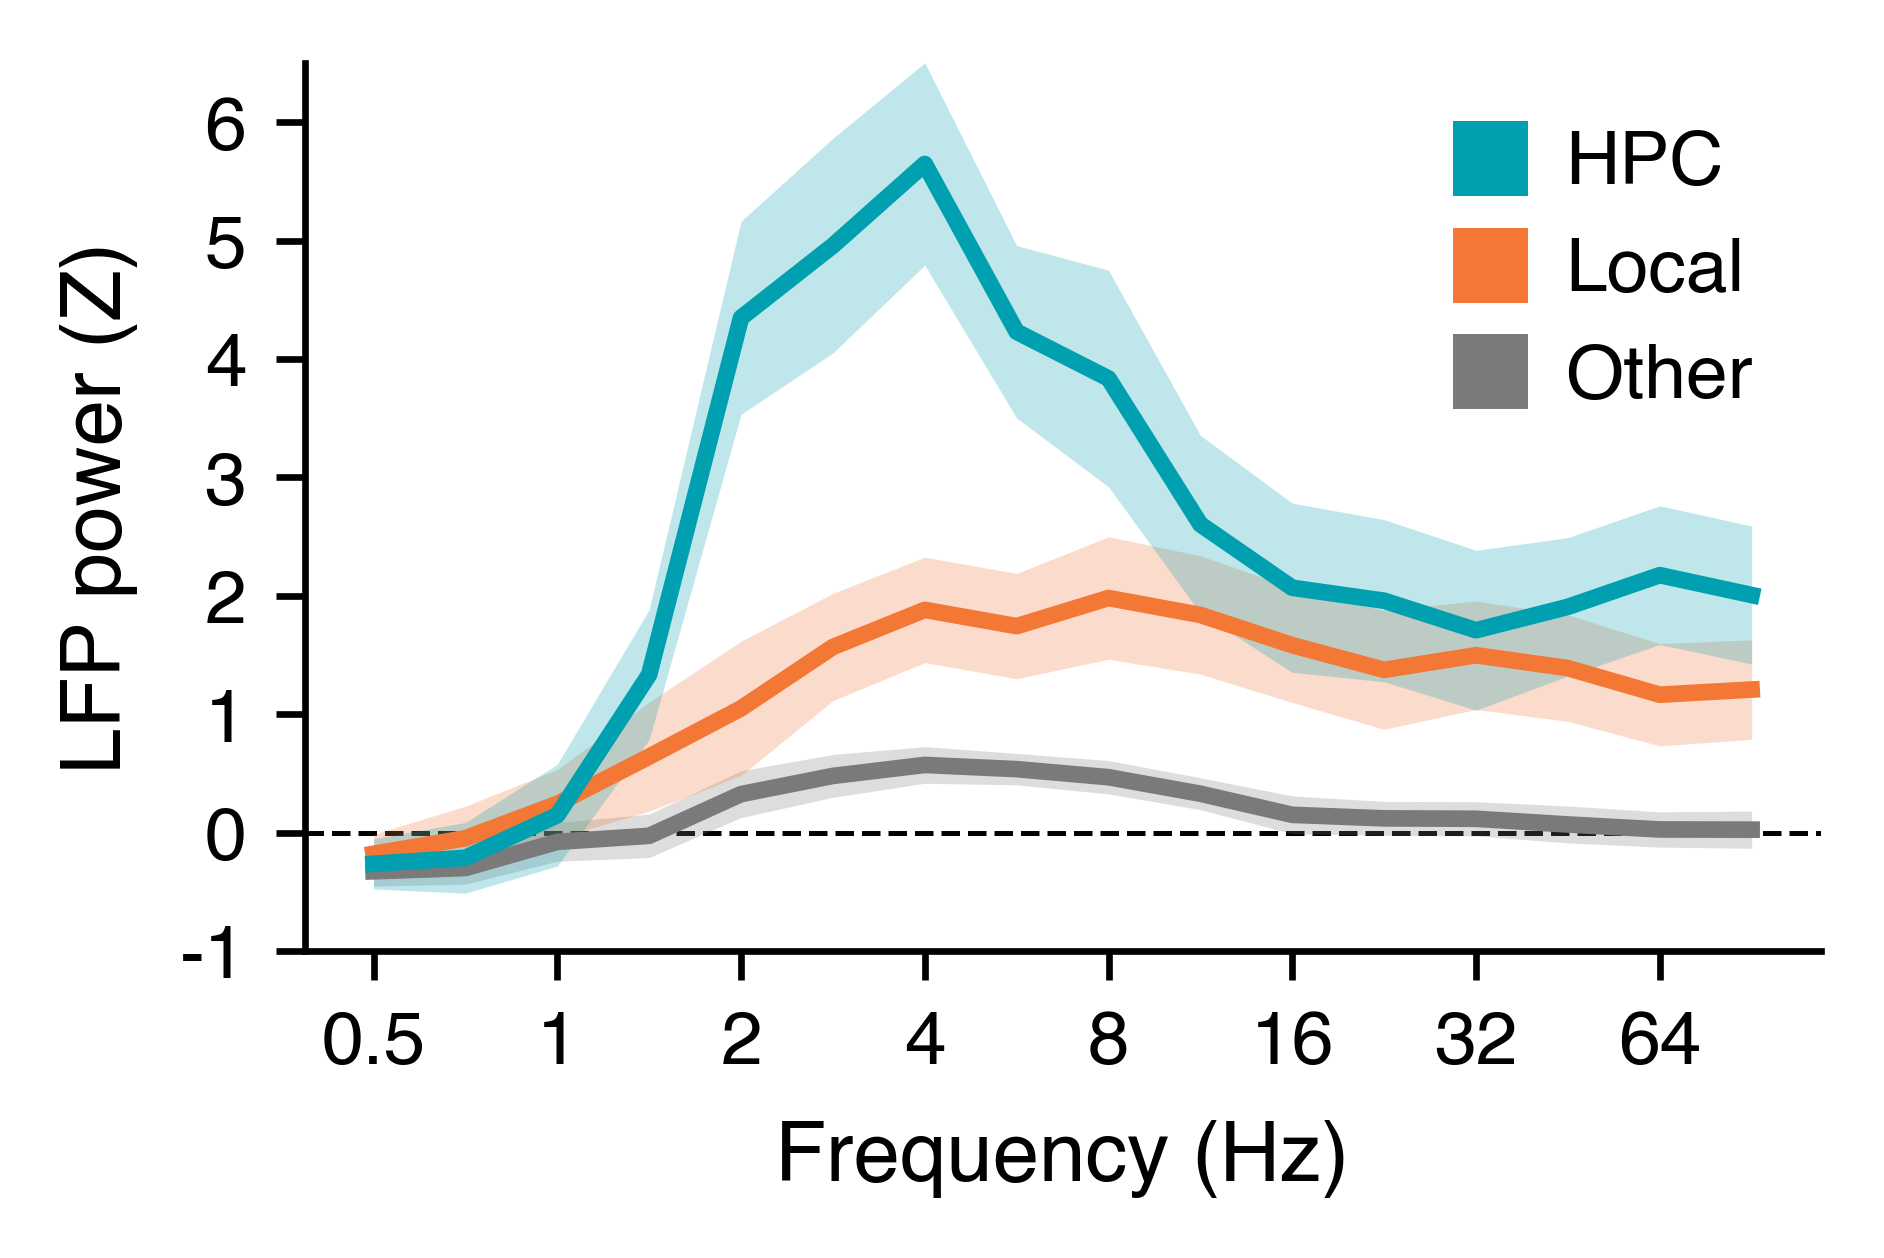

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3.26, 1.96), dpi=600)
ax = np.ravel(ax)

tickfontsize = 9
labelfontsize = 10

rois = ['other', 'local', 'target']
colors_ = [colors[5], '#f37735', '#00a0b0']

i = 0
for iRoi, roi in enumerate(rois):
    dat = (power_df
           .query("(power_measure=='z_power') & (roi=='{}')".format(roi))
           .groupby(['subj', 'freq'])
           .agg({'unit': len, 'val': np.mean})
           ['val'].unstack().values) # subj x freq
    means = np.mean(dat, axis=0)
    sems = stats.sem(dat, axis=0)
    
    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors_[iRoi], alpha=0.25, linewidth=0)
    ax[i].fill_between(x_ax, means - 0.04, means +  0.04, 
                       color=colors_[iRoi], alpha=0.5, linewidth=0)
    ax[i].plot(x_ax, means, color=colors_[iRoi], linewidth=2)

ax[i].axhline(0, 0, len(x_ax), color='k', linestyle='--', linewidth=0.6, zorder=0)
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1, 6.5])
ax[i].set_yticks(np.arange(-1, 6.1, 1, dtype=np.int))
ax[i].set_yticklabels(np.arange(-1, 6.1, 1, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('LFP power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='HPC', markerfacecolor=colors_[2], markeredgewidth=0, markersize=tickfontsize, lw=0),
                Line2D([0], [0], marker='s', color='w', label='Local', markerfacecolor=colors_[1], markeredgewidth=0, markersize=tickfontsize, lw=0),
                Line2D([0], [0], marker='s', color='w', label='Other', markerfacecolor=colors_[0], markeredgewidth=0, markersize=tickfontsize, lw=0)]
legend = ax[i].legend(handles=custom_lines, fontsize=tickfontsize, loc=1, handletextpad=0)

fig.show()

if True:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_and_power_correlations_top20%_spike_selection_locked2-8Hz_forNoa.pdf', 
                format='pdf', bbox_inches='tight')
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_and_power_correlations_top20%_spike_selection_locked2-8Hz.png', 
                format='png', dpi=300, bbox_inches='tight')

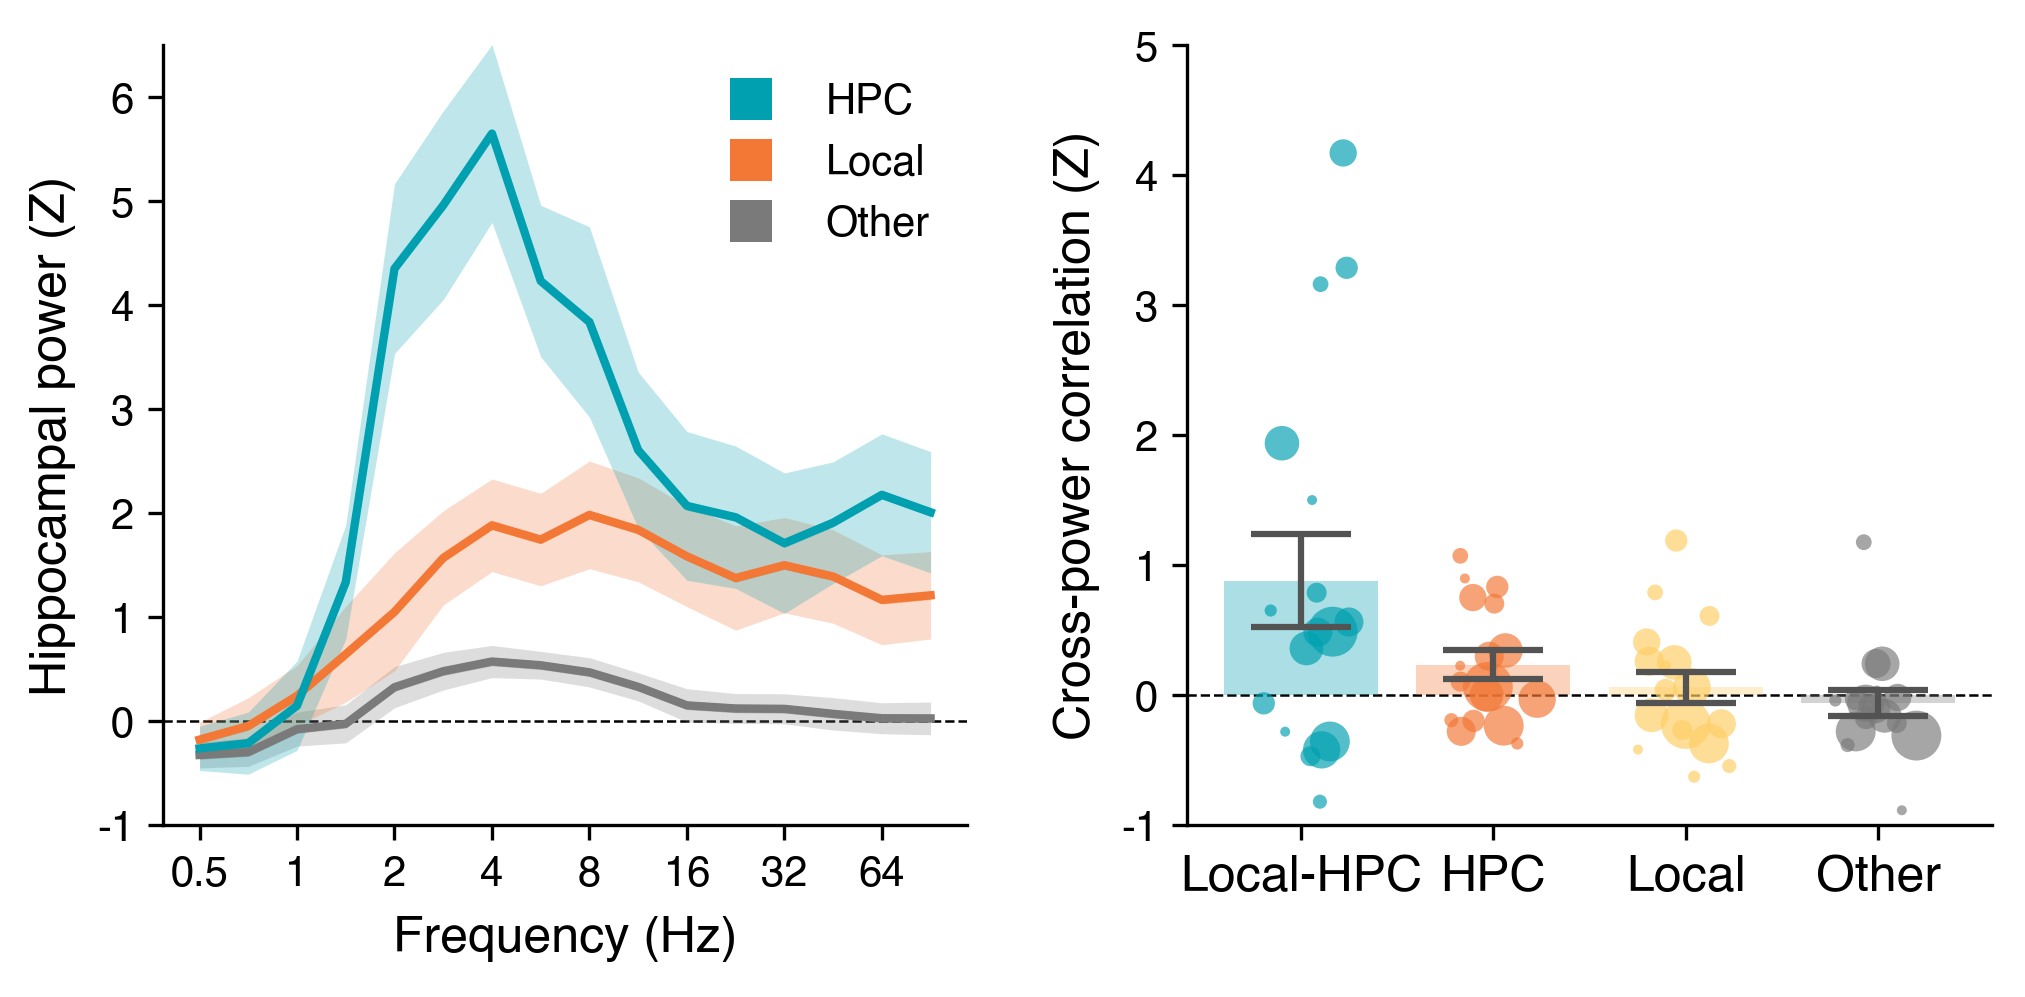

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(colws[2], colws[2]*0.5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

rois = ['other', 'local', 'target']
colors_ = [colors[5], '#f37735', '#00a0b0']

i = 0
for iRoi, roi in enumerate(rois):
    dat = (power_df
           .query("(power_measure=='z_power') & (roi=='{}')".format(roi))
           .groupby(['subj', 'freq'])
           .agg({'unit': len, 'val': np.mean})
           ['val'].unstack().values) # subj x freq
    means = np.mean(dat, axis=0)
    sems = stats.sem(dat, axis=0)
    
    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors_[iRoi], alpha=0.25, linewidth=0)
    ax[i].fill_between(x_ax, means - 0.04, means +  0.04, 
                       color=colors_[iRoi], alpha=0.5, linewidth=0)
    ax[i].plot(x_ax, means, color=colors_[iRoi], linewidth=2)

ax[i].axhline(0, 0, len(x_ax), color='k', linestyle='--', linewidth=0.6, zorder=0)
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1, 6.5])
ax[i].set_yticks(np.arange(-1, 6.1, 1, dtype=np.int))
ax[i].set_yticklabels(np.arange(-1, 6.1, 1, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Hippocampal power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='HPC', markerfacecolor=colors_[2], markeredgewidth=0, markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Local', markerfacecolor=colors_[1], markeredgewidth=0, markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Other', markerfacecolor=colors_[0], markeredgewidth=0, markersize=tickfontsize)]
legend = ax[i].legend(handles=custom_lines, fontsize=tickfontsize, loc=1, bbox_to_anchor=(1, 1))


# # --------------------------------------------

i = 1
roi_pairs = ['target_local', 'target', 'local', 'other']
dat = (power_df
       .query("(power_measure=='z_power_corr')")
       .groupby(['subj', 'roi'])
       .agg({'unit': len, 'val': np.mean})
       .reset_index())
dat['roi'] = dat['roi'].astype('category').cat.reorder_categories(roi_pairs, ordered=True)
colors_ = ['#00a0b0', '#f37735', colors[6], colors[5]]

ax[i].axhline(0, 0, len(x_ax), color='k', linestyle='--', linewidth=0.6, zorder=0)
scaling_factor = 3
sizes = dat.groupby(['subj'])['unit'].apply(lambda x: list(x)[0]).values
sizes = scaling_factor * np.sqrt(sizes/np.pi) # area to radius
ax[i] = sns.stripplot('roi', 'val', data=dat, ax=ax[i], 
                      palette=colors_, size=sizes, alpha=0.67, jitter=0.25, zorder=1)
ax[i] = sns.barplot(x='roi', y='val', data=dat, ax=ax[i],
                    ci=None, palette=colors_, saturation=1, alpha=0.33, zorder=2)
ax[i].errorbar(np.arange(4), dat.groupby('roi')['val'].mean().values, 
               yerr=dat.groupby('roi')['val'].apply(lambda x: stats.sem(x)).values,
               ecolor='#535353', elinewidth=1.5, capsize=12, capthick=1.5, linewidth=0, zorder=3)
ax[i].set_xticklabels(['Local-HPC', 'HPC', 'Local', 'Other'], fontsize=labelfontsize)
ax[i].set_ylim([-1, 5])
# ax[i].set_ylim([-0.2, 1.5])
ax[i].set_yticks(np.arange(-1, 5.1, 1))
ax[i].set_yticklabels(np.arange(-1, 5.1, 1, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Cross-power correlation (Z)', fontsize=labelfontsize, labelpad=5)

# fig.text(0, 0.97, 'a', fontsize=figfontsize)
# fig.text(0.5, 0.97, 'b', fontsize=figfontsize)
fig.tight_layout(pad=1.08, w_pad=2, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_and_power_correlations_top20%_spike_selection_locked2-8Hz.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_and_power_correlations_top20%_spike_selection_locked2-8Hz.png', 
                format='png', dpi=300, bbox_inches='tight')

## Power and power correlation relations with spike phase and firing rate
### Adjusted for regional specificity

In [ ]:
# files = glob('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/sig/*.pkl')
files = glob('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/sig_no_meanSub/*.pkl')
print('{} files'.format(len(files)))

362 files


In [234]:
d = '/home1/dscho/projects/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/sig'
count = 0
for idx, row in pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)").iterrows():
    f = os.path.join(d, 'power_by_phase_locking_and_fr-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                     .format(row['subj_sess'], row['unit'], row['lfp_hemroi']))
    if os.path.exists(f):
        count += 1
count

362

In [259]:
power_cats = [('z_power', 'power_pvals'), ('z_power_corrs', 'power_corr_pvals')]
spike_cats = ['target_phase_locking', 'high_firing_rate', 'low_firing_rate', 'local_phase_locking']

# roi_powers[power_cat][spike_cat] will contain an roi x freq array
# that we can use to Z-score each frequency across rois
power_output = []
col_names = ['subj', 'sess', 'unit', 'subj_sess', 'subj_sess_unit', 'hpc_cat', 'spike_cat', 'freq', 'val']
roi_powers = OrderedDict([(power_cat, OrderedDict([(spike_cat, [])
                                                   for spike_cat in spike_cats]))
                          for power_cat, power_cat_pvals in power_cats])
for idx, row in pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)").iterrows():
    f = os.path.join(d, 'power_by_phase_locking_and_fr-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                     .format(row['subj_sess'], row['unit'], row['lfp_hemroi']))
    if os.path.exists(f):
        # Load power data.
        power_dat = dio.open_pickle(f)
        fsplit = os.path.basename(f).split('-')
        subj_sess = fsplit[1]
        subj, sess = subj_sess.split('_')
        unit = int(fsplit[2][5:])
        subj_sess_unit = '{}_{}'.format(subj_sess, unit)
        lfp_roi = fsplit[3][4:]
        for power_cat, power_cat_pvals in power_cats:
            for spike_cat in spike_cats:
                roi_powers[power_cat][spike_cat].append(power_dat[power_cat][spike_cat])
                
                if power_cat == 'z_power':
                    power_arr = power_dat[power_cat][spike_cat]
                    for iFreq, power_val in enumerate(power_arr):
                        power_output.append([subj, sess, unit, subj_sess, subj_sess_unit, power_cat, spike_cat, iFreq, power_val])
                else:
                    power_output.append([subj, sess, unit, subj_sess, subj_sess_unit, power_cat, spike_cat, -1, power_dat[power_cat][spike_cat]])
    
for power_cat, power_cat_pvals in power_cats:
    for spike_cat in spike_cats:
        roi_powers[power_cat][spike_cat] = np.array(roi_powers[power_cat][spike_cat])
        
power_output = pd.DataFrame(power_output, columns=col_names)
power_output.shape

(24616, 9)

In [648]:
output.columns

Index(['subj', 'unit', 'subj_sess_unit', 'hpc_cat', 'spike_cat', 'freq', 'val',
       'unit_roi3', 'lfp_hemroi'],
      dtype='object')

In [695]:
n_neuron_thresh = 7
spike_cat = 'target_phase_locking'
spike_cats = ['high_firing_rate', 'target_phase_locking']
dat = (output
       .query("(hpc_cat=='z_power_corrs') & (spike_cat=={})".format(spike_cats))
       .groupby(['subj', 'spike_cat'])
       .agg({'unit': len, 'val': np.mean})
       .query("(unit>{})".format(n_neuron_thresh))
       .reset_index())
np.min(dat['val']), np.max(dat['val'])

(-0.8763330321138104, 3.926482216119766)

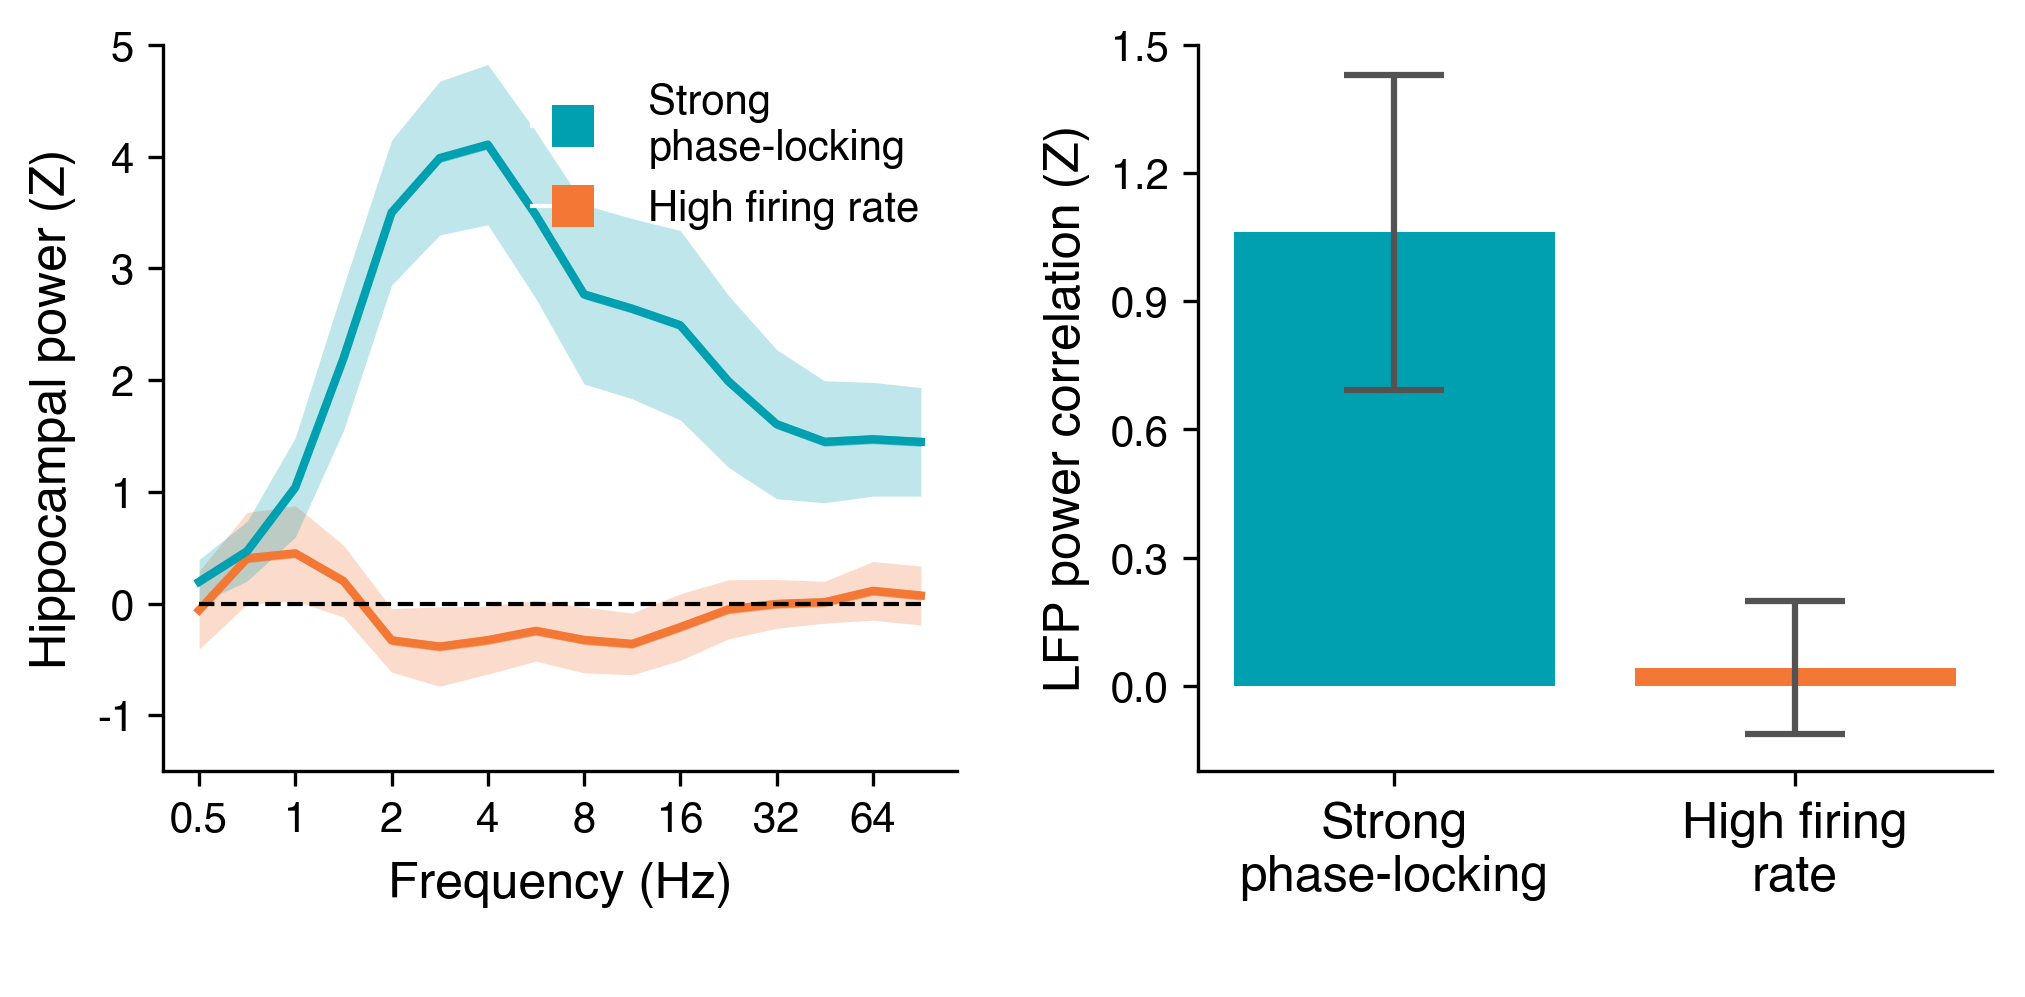

In [731]:
fig, ax = plt.subplots(1, 2, figsize=(colws[2], colws[2]*0.5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

spike_cats = ['high_firing_rate', 'target_phase_locking']
colors_ = ['#f37735', '#00a0b0']

i = 0
for iSpike_cat, spike_cat in enumerate(spike_cats):
    dat = (output
           .query("(hpc_cat=='z_power') & (spike_cat=='{}')".format(spike_cat))
           .groupby(['subj', 'freq'])
           .agg({'unit': len, 'val': np.mean})
           .query("(unit>{})".format(n_neuron_thresh))
           ['val'].unstack().values) # subj x freq
    means = np.mean(dat, axis=0)
    sems = stats.sem(dat, axis=0)
    
    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors_[iSpike_cat], alpha=0.25, linewidth=0)
    ax[i].fill_between(x_ax, means - 0.04, means +  0.04, 
                       color=colors_[iSpike_cat], alpha=0.5, linewidth=0)
    ax[i].plot(x_ax, means, color=colors_[iSpike_cat], linewidth=2)

ax[i].plot(x_ax, np.zeros(len(x_ax)), color='k', linestyle='--', linewidth=1, alpha=1)
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1.5, 5.0])
ax[i].set_yticks(np.arange(-1, 5.1, 1, dtype=np.int))
ax[i].set_yticklabels(np.arange(-1, 5.1, 1, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Hippocampal power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Strong\nphase-locking', markerfacecolor=colors_[1], markeredgewidth=0, markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='High firing rate', markerfacecolor=colors_[0], markeredgewidth=0, markersize=tickfontsize)]
legend = ax[i].legend(handles=custom_lines, fontsize=tickfontsize, loc=1, bbox_to_anchor=(1, 1))


# --------------------------------------------

i = 1
spike_cats = ['target_phase_locking', 'high_firing_rate']
dat = (output
       .query("(hpc_cat=='z_power_corrs') & (spike_cat=={})".format(spike_cats))
       .groupby(['subj', 'spike_cat'])
       .agg({'unit': len, 'val': np.mean})
       .query("(unit>{})".format(n_neuron_thresh))
       .reset_index())
dat['spike_cat'] = dat['spike_cat'].astype('category').cat.reorder_categories(spike_cats, ordered=True)
ax[i] = sns.barplot(x='spike_cat', y='val', data=dat, ax=ax[i],
                    ci=None, palette=reversed(colors_), saturation=1)
ax[i].errorbar(np.arange(2), dat.groupby('spike_cat')['val'].mean().values, 
               yerr=dat.groupby('spike_cat')['val'].apply(lambda x: stats.sem(x)).values,
               ecolor='#535353', elinewidth=1.5, capsize=12, capthick=1.5, linewidth=0)
# sns.boxplot('spike_cat', 'z', data=dat, ax=ax[i], showfliers=False, 
#             palette=[colors[2], colors[1], colors[0]], saturation=1)
# sns.swarmplot('spike_cat', 'z', data=dat, ax=ax[i], 
#               palette=[colors[2], colors[1], colors[0]])
ax[i].set_xticklabels(['Strong\nphase-locking', 'High firing\nrate', 'Low firing\nrate'], fontsize=labelfontsize)
ax[i].set_ylim([-0.2, 1.5])
ax[i].set_yticks(np.arange(0, 1.6, 0.3))
ax[i].set_yticklabels(np.round(np.arange(0, 1.6, 0.3), 1), fontsize=tickfontsize)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('LFP power correlation (Z)', fontsize=labelfontsize, labelpad=5)

# fig.text(0, 0.97, 'a', fontsize=figfontsize)
# fig.text(0.5, 0.97, 'b', fontsize=figfontsize)
fig.tight_layout(pad=1.08, w_pad=2, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_and_power_correlations_top20%_spike_selection.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_and_power_correlations_top20%_spike_selection.png', 
                format='png', dpi=300, bbox_inches='tight')

In [728]:
# For each neuron, identify the frequency with the maximum Z-power 
# for strongly phase-locked spikes vs. the null distribution.
dat = (output
       .query("(hpc_cat=='z_power') & (spike_cat=='target_phase_locking')")
       .groupby(['subj', 'unit_roi3', 'subj_sess_unit'])
       .agg({'val': lambda x: np.array(x).argmax()})
       .reset_index())

# Save the df.
if False:
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/figs/power_by_pl_fr-peak_power_freq-{}_sig_pl_neurons.csv'.format(n_cells)
    dat.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs/power_by_pl_fr-peak_power_freq-362_sig_pl_neurons.csv


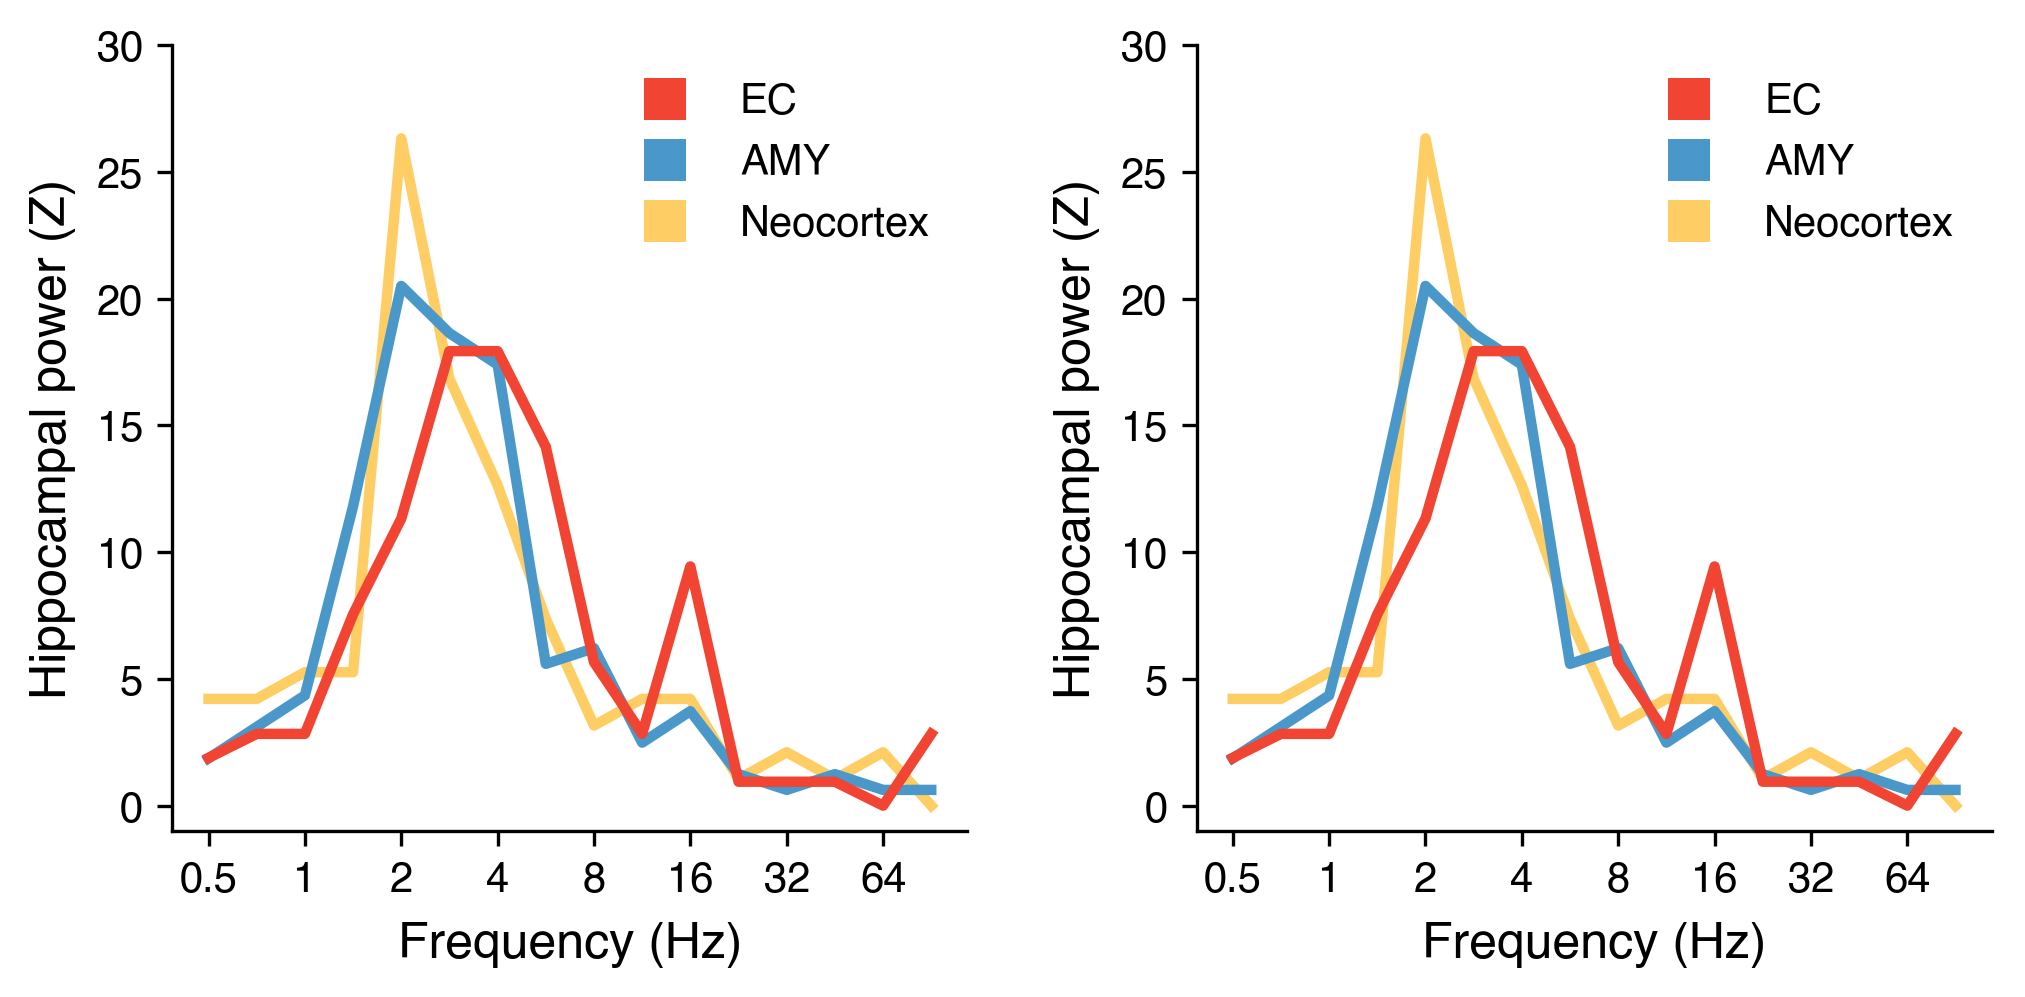

In [726]:
fig, ax = plt.subplots(1, 2, figsize=(colws[2], colws[2]*0.5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

spike_cats = ['high_firing_rate', 'target_phase_locking']
rois = ['ctx', 'amy', 'ec']
colors_ = [colors[6], colors[0], colors[1]]

dat = (output
       .query("(hpc_cat=='z_power') & (spike_cat=='target_phase_locking')")
       .groupby(['subj', 'unit_roi3', 'subj_sess_unit'])
       .agg({'val': lambda x: np.array(x).argmax()})
       .reset_index())

for i in range(len(ax)):
    ymax = 30
    for iRoi, roi in enumerate(rois):
        vals, counts = np.unique(dat.query("(unit_roi3=='{}')".format(roi))['val'], return_counts=True)
        f_counts = dict(zip(vals, counts))
        yvals = np.array([f_counts.get(iFreq, 0) for iFreq in range(len(freqs))])
        ax[i].plot(np.arange(len(freqs)), 100 * yvals / np.sum(yvals), color=colors_[iRoi], linewidth=2.5)

    ax[i].set_xticks(np.arange(len(freqs))[::2])
    ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
    ax[i].set_ylim([-1, ymax])
    ax[i].set_yticks(np.arange(0, ymax+1, 5, dtype=int))
    ax[i].set_yticklabels(np.arange(0, ymax+1, 5, dtype=int), fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('Hippocampal power (Z)', fontsize=labelfontsize, labelpad=5)

    custom_lines = [Line2D([0], [0], marker='s', color='w', label='EC', markerfacecolor=colors_[2], markeredgewidth=0, markersize=tickfontsize),
                    Line2D([0], [0], marker='s', color='w', label='AMY', markerfacecolor=colors_[1], markeredgewidth=0, markersize=tickfontsize),
                    Line2D([0], [0], marker='s', color='w', label='Neocortex', markerfacecolor=colors_[0], markeredgewidth=0, markersize=tickfontsize)]
    legend = ax[i].legend(handles=custom_lines, fontsize=tickfontsize, loc=1, bbox_to_anchor=(1, 1))

fig.tight_layout(pad=1.08, w_pad=2, rect=[0, 0, 1, 1])

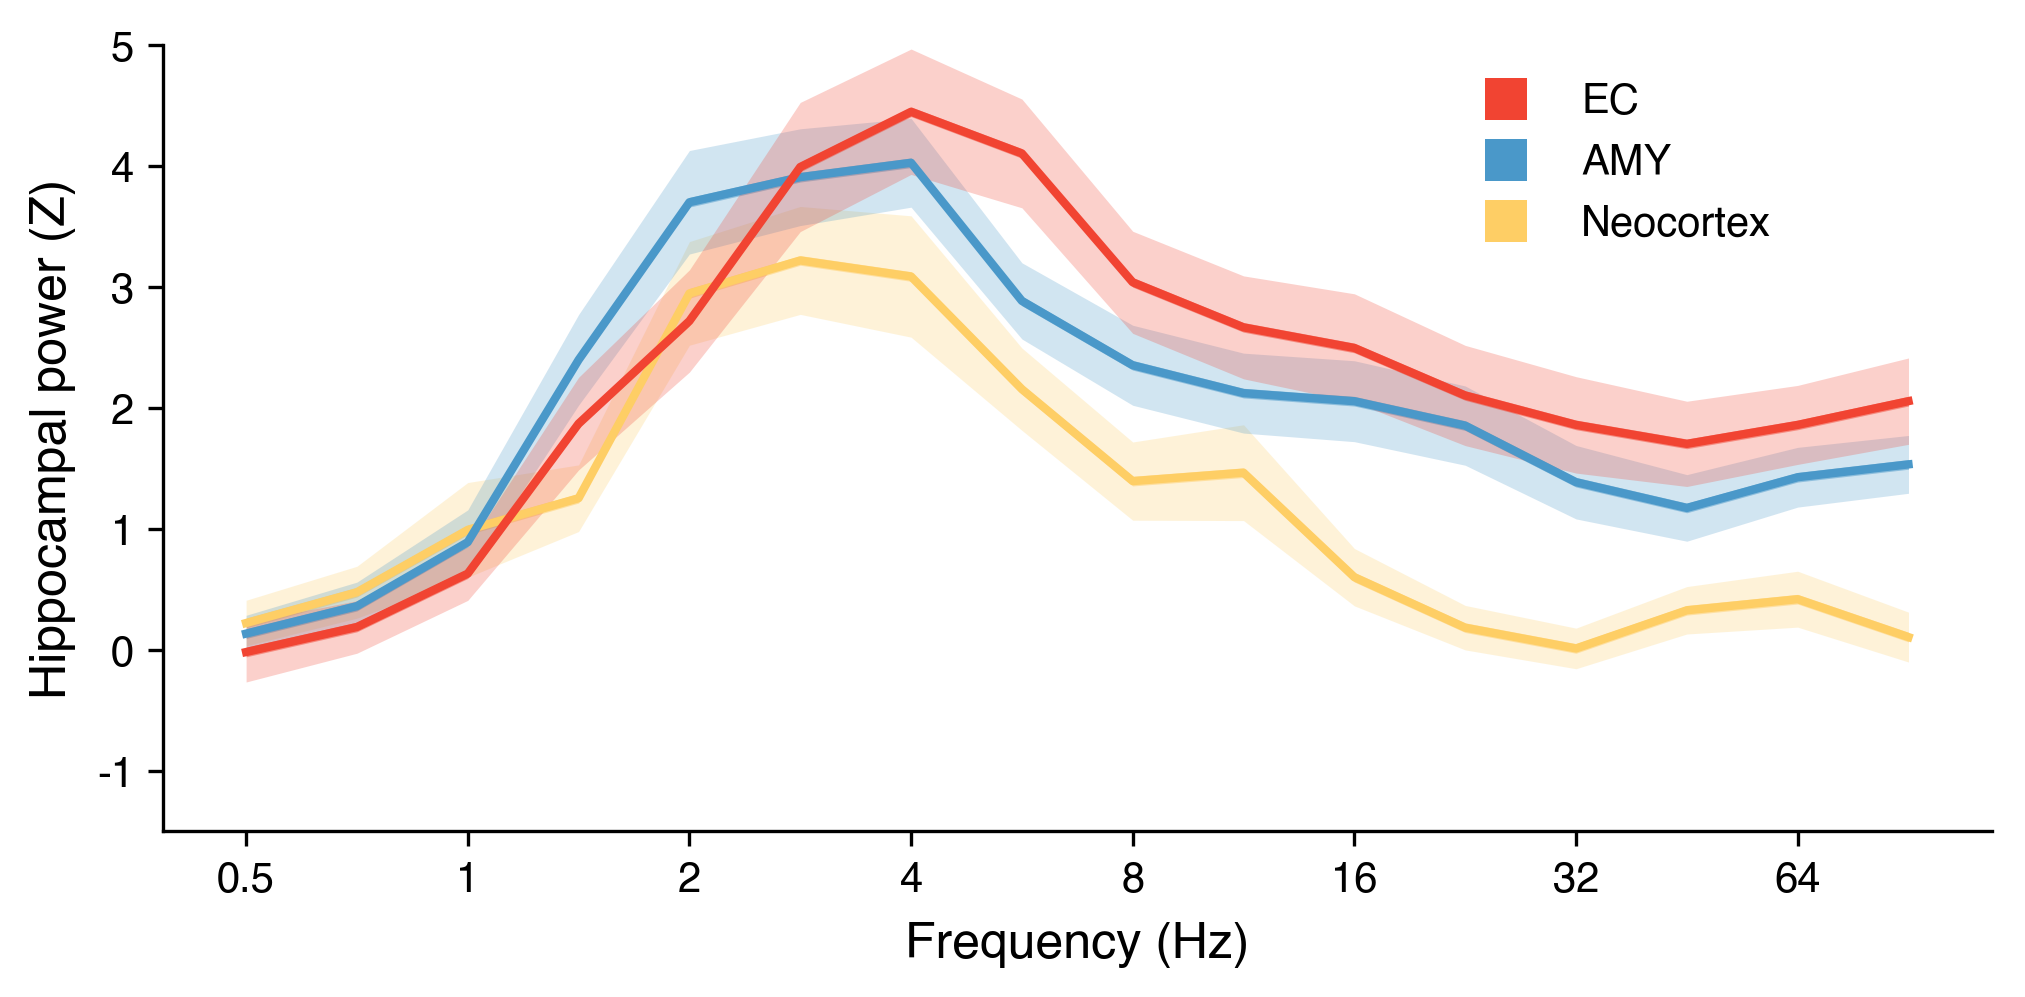

In [528]:
fig, ax = plt.subplots(1, 1, figsize=(colws[2], colws[2]*0.5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

spike_cat = 'target_phase_locking'
colors_ = [colors[6], colors[0], colors[1]]

i = 0
for iRoi, roi in enumerate(['ctx', 'amy', 'ec']):
    means = output.query("(hpc_cat=='z_power') & (spike_cat=='{}') & (unit_roi3=='{}')".format(spike_cat, roi)).groupby('freq')['val'].apply(np.mean)
    sems = output.query("(hpc_cat=='z_power') & (spike_cat=='{}') & (unit_roi3=='{}')".format(spike_cat, roi)).groupby('freq')['val'].apply(lambda x: stats.sem(x))

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors_[iRoi], alpha=0.25, linewidth=0)
    ax[i].fill_between(x_ax, means - 0.04, means +  0.04, 
                       color=colors_[iRoi], alpha=0.5, linewidth=0)
    ax[i].plot(x_ax, means, color=colors_[iRoi], linewidth=2)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1.5, 5.0])
ax[i].set_yticks(np.arange(-1, 5.1, 1, dtype=np.int))
ax[i].set_yticklabels(np.arange(-1, 5.1, 1, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Hippocampal power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='EC', markerfacecolor=colors_[2], markeredgewidth=0, markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='AMY', markerfacecolor=colors_[1], markeredgewidth=0, markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Neocortex', markerfacecolor=colors_[0], markeredgewidth=0, markersize=tickfontsize)]
legend = ax[i].legend(handles=custom_lines, fontsize=tickfontsize, loc=1, bbox_to_anchor=(0.9, 1))

fig.tight_layout(pad=1.08, w_pad=2, rect=[0, 0, 1, 1])

Text(0, 0.5, 'LFP power similarity (Z)')

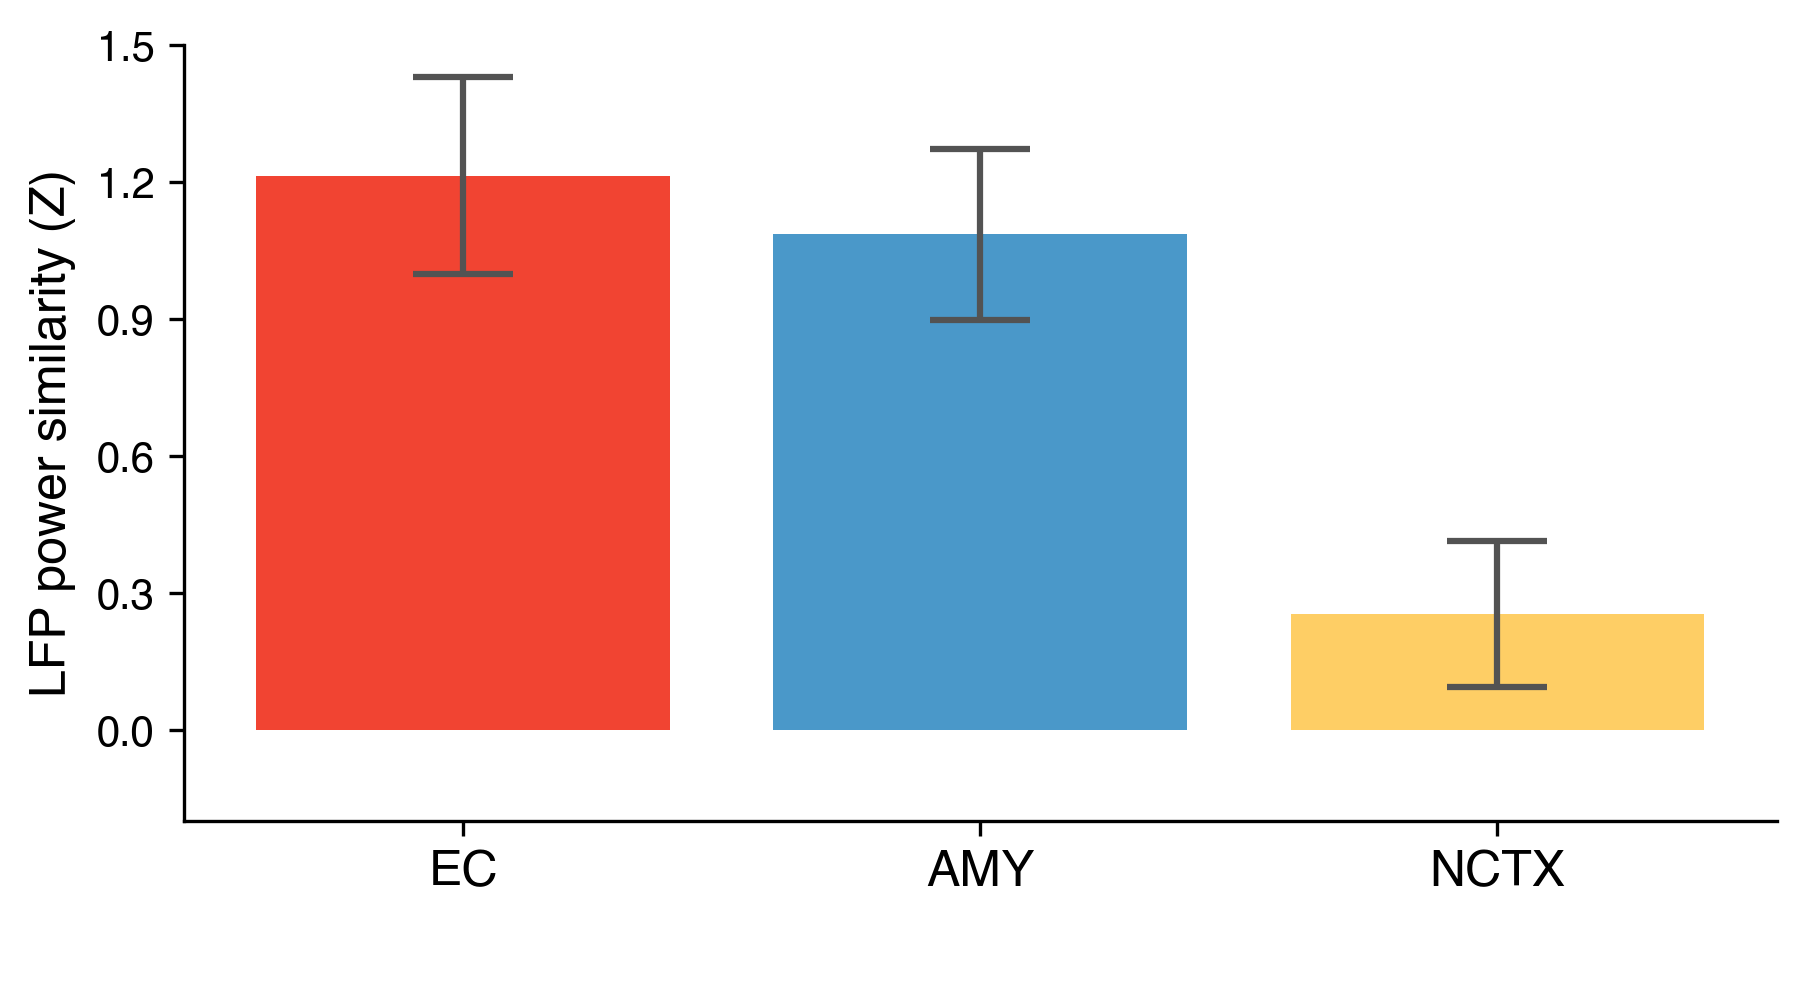

In [527]:
fig, ax = plt.subplots(1, 1, figsize=(colws[2], colws[2]*0.5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

spike_cat = 'target_phase_locking'
rois = ['ec', 'amy', 'ctx']
colors_ = [colors[6], colors[0], colors[1]]

i = 0
ax[i] = sns.barplot(x='unit_roi3', y='val', order=rois,
                    ci=None, palette=reversed(colors_), saturation=1,
                    data=output.query("(hpc_cat=='z_power_corrs') & (spike_cat=='{}')".format(spike_cat)), ax=ax[i])
means = [output.query("(hpc_cat=='z_power_corrs') & (spike_cat=='{}')".format(spike_cat)).groupby('unit_roi3')['val'].mean().to_dict()[roi] for roi in rois]
sems = [output.query("(hpc_cat=='z_power_corrs') & (spike_cat=='{}')".format(spike_cat)).groupby('unit_roi3')['val'].apply(lambda x: stats.sem(x)).to_dict()[roi] for roi in rois]
ax[i].errorbar(np.arange(3), means, yerr=sems,
               ecolor='#535353', elinewidth=1.5, capsize=12, capthick=1.5, linewidth=0)

ax[i].set_xticklabels(['EC', 'AMY', 'NCTX'], fontsize=labelfontsize)
ax[i].set_ylim([-0.2, 1.5])
ax[i].set_yticks(np.arange(0, 1.6, 0.3))
ax[i].set_yticklabels(np.round(np.arange(0, 1.6, 0.3), 1), fontsize=tickfontsize)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('LFP power similarity (Z)', fontsize=labelfontsize, labelpad=5)

In [164]:
print('high phase-locking:', stats.ttest_1samp(roi_powers['z_power_corrs']['target_phase_locking'], 0))
print('high firing rate:', stats.ttest_1samp(roi_powers['z_power_corrs']['high_firing_rate'], 0))

high phase-locking: Ttest_1sampResult(statistic=7.913847511568235, pvalue=3.093749377330998e-14)
high firing rate: Ttest_1sampResult(statistic=1.0125716998476617, pvalue=0.31194296077627914)


In [163]:
print('high phase-locking:')
alpha = 0.05
n = len(roi_powers['z_power']['high_firing_rate'][:, 0])
print('n={}'.format(n))
pvals = []
for iFreq in range(len(freqs)):
    pvals.append(stats.ttest_1samp(roi_powers['z_power']['target_phase_locking'][:, iFreq], 0)[1])
    print('{:.1f} Hz:'.format(freqs[iFreq]), 
          np.round(np.mean(roi_powers['z_power']['target_phase_locking'][:, iFreq]), 2), 
          np.round(np.std(roi_powers['z_power']['target_phase_locking'][:, iFreq]) / np.sqrt(n), 2), 
          stats.ttest_1samp(roi_powers['z_power']['target_phase_locking'][:, iFry(eq], 0)[1] < alpha)
    
sm.stats.multipletests(pvals, alpha=alpha, method='hs')

high phase-locking:
n=362
0.5 Hz: 0.11 0.11 False
0.7 Hz: 0.34 0.12 True
1.0 Hz: 0.84 0.17 True
1.4 Hz: 1.94 0.21 True
2.0 Hz: 3.21 0.25 True
2.8 Hz: 3.75 0.26 True
4.0 Hz: 3.9 0.26 True
5.7 Hz: 3.05 0.21 True
8.0 Hz: 2.3 0.21 True
11.3 Hz: 2.11 0.22 True
16.0 Hz: 1.8 0.21 True
22.6 Hz: 1.49 0.2 True
32.0 Hz: 1.16 0.19 True
45.3 Hz: 1.1 0.17 True
64.0 Hz: 1.29 0.16 True
90.5 Hz: 1.31 0.16 True


(array([False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]),
 array([3.17167748e-01, 1.15639501e-02, 3.36245805e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.99760217e-15, 4.12470058e-12,
        5.86775073e-09, 1.33762890e-09, 9.94759830e-14, 9.94759830e-14]),
 0.0032006977101884937,
 0.003125)

In [ ]:
print('high firing rate:')
alpha = 0.05
n = len(roi_powers['z_power']['high_firing_rate'][:, 0])
print('n={}'.format(n))
pvals = []
for iFreq in range(len(freqs)):
    pvals.append(stats.ttest_1samp(roi_powers['z_power']['high_firing_rate'][:, iFreq], 0)[1])
    print('{:.1f} Hz:'.format(freqs[iFreq]), 
          np.round(np.mean(roi_powers['z_power']['high_firing_rate'][:, iFreq]), 2), 
          np.round(np.std(roi_powers['z_power']['high_firing_rate'][:, iFreq]) / np.sqrt(n), 2), 
          stats.ttest_1samp(roi_powers['z_power']['high_firing_rate'][:, iFreq], 0)[1] < alpha)

sm.stats.multipletests(pvals, alpha=alpha, method='hs')[0]

In [113]:
print('high firing rate:')
alpha = 0.05
n = len(roi_powers['z_power']['high_firing_rate'][:, 0])
print('n={}'.format(n))
pvals = []
for iFreq in range(len(freqs)):
    pvals.append(stats.ttest_1samp(roi_powers['z_power']['high_firing_rate'][:, iFreq], 0)[1])
    print('{:.1f} Hz:'.format(freqs[iFreq]), 
          np.round(np.mean(roi_powers['z_power']['high_firing_rate'][:, iFreq]), 2), 
          np.round(np.std(roi_powers['z_power']['high_firing_rate'][:, iFreq]) / np.sqrt(n), 2), 
          stats.ttest_1samp(roi_powers['z_power']['high_firing_rate'][:, iFreq], 0)[1] < alpha)

sm.stats.multipletests(pvals, alpha=alpha, method='hs')[0]

high firing rate:
n=362
0.5 Hz: 0.28 0.23 False
0.7 Hz: 0.43 0.2 True
1.0 Hz: 0.39 0.21 False
1.4 Hz: 0.24 0.21 False
2.0 Hz: -0.18 0.2 False
2.8 Hz: -0.18 0.21 False
4.0 Hz: -0.21 0.2 False
5.7 Hz: -0.07 0.19 False
8.0 Hz: -0.11 0.18 False
11.3 Hz: -0.08 0.17 False
16.0 Hz: 0.03 0.17 False
22.6 Hz: 0.12 0.15 False
32.0 Hz: 0.11 0.13 False
45.3 Hz: 0.04 0.13 False
64.0 Hz: 0.15 0.15 False
90.5 Hz: 0.14 0.15 False


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [607]:
for key in ['unit_roi3', 'lfp_hemroi']:
    if key not in output.columns:
        output = pd.merge(output, pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)").groupby('subj_sess_unit').agg({key: lambda x: list(x)[0]}).reset_index(), on='subj_sess_unit')
output.columns

Index(['subj', 'unit', 'subj_sess_unit', 'hpc_cat', 'spike_cat', 'freq', 'val',
       'unit_roi3', 'lfp_hemroi'],
      dtype='object')

## Power at different power value thresholds

In [ ]:
def calc_power_by_pl_fr_unit_to_target_region(info,
                                              n_freqs=16,
                                              n_bootstraps=1000,
                                              sampling_rate=2000,
                                              time_win=2,
                                              test_phase_offsets=True, # if False, only assess spikes by firing rate
                                              subtract_mean=True,
                                              zpower_thresh=[0, 1, 2], # only look at spikes that occur during timepoints with Z>zpower_thresh power
                                              input_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                              save_outputs=True,
                                              overwrite=False,
                                              output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/sig',
                                              sleep_max=0):
    """Obtain power values for highly phase-locked or high firing spikes.
    
    The following steps are performed in reference to the mean power
    across channels for each depth electrode. The HPC region that 
    phase relations were taken in reference to is referred to as the
    "target" region, and the neuron's region of origin is called the
    "local" region and does not include the neuron's own channel.
    
    We find the 20% of spikes that fired:
    1) Closest to the preferred phase at the preferred phase-locked 
       frequency, in reference to the target (i.e. HPC) LFP.
    2) Closest to the preferred phase in reference to the local
       LFP, but at the preferred target LFP phase-locking frequency
    3) With the highest firing rate
    
    We then get:
    1) The mean power across spikes at each frequency,
       for each of these spike categories. 
    2) The Pearson correlation of power at each frequency across spikes,
       for each of these spike categories.
    
    Mean power and power correlation vectors for each spike category 
    are Z-scored against a null distribution of randomly selected spikes 
    (20% of spikes for each permutation). 
    
    We return a dictionary with:
    1) The Z-power vector for each spike category.
    2) A p-value and some associated metrics for each spike category.
       The p-value is determined from a permutation test in which we compare
       the max(|z_power|) across frequencies against the null distribution 
       of max(|z_power|) from each permutation. This test enables us to detect 
       spike subsets that showed significantly higher or lower power at any 
       frequency, compared to the null distribution of spikes drawn at random.
    3) The Z-power correlation vector for each spike category.
    4) A p-value and some associated metrics for each spike category,
       using the same logic as in (2) but with Z-power correlations rather
       than Z-power at each frequency.
    """
    def bootstrap_p(obs, null):
        """Derive an empirical p-value.

        The maximum |Z-score| (across frequencies) is compared
        against the null distribution of maximum |Z-scores|.

        obs : n_freq vec
        null : n_freq x n_boot array
        """
        n_bootstraps = null.shape[-1]

        if len(null.shape) == 1:
            max_obs = np.abs(obs)
            max_null = np.abs(null)
            bs_ind = np.sum(max_null >= max_obs)
            pval = (1 + bs_ind) / (1 + n_bootstraps)

            return OrderedDict([('max_z', obs),
                                ('max_z_ind', 0),
                                ('bs_ind', bs_ind),
                                ('pval', pval)])
        else:
            max_obs = np.max(np.abs(obs))
            max_null = np.max(np.abs(null), axis=0)
            bs_ind = np.sum(max_null >= max_obs)
            pval = (1 + bs_ind) / (1 + n_bootstraps)

            # Get the Z-score and index of max(|Z|)
            max_z_ind = np.argmax(np.abs(obs))
            max_z = obs[max_z_ind]

            return OrderedDict([('max_z', max_z),
                                ('max_z_ind', max_z_ind),
                                ('bs_ind', bs_ind),
                                ('pval', pval)])
        
    # Check if output file already exists.
    subj_sess = info.subj_sess
    unit = info.unit
    lfp_roi = info.lfp_hemroi
    output_fname = 'power_by_phase_locking_and_fr-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
    fpath = os.path.join(output_dir, output_fname.format(subj_sess, unit, lfp_roi))
    if os.path.exists(fpath) and not overwrite:
        output = dio.open_pickle(fpath)
        return output
    
    # Take a nap before running.
    if sleep_max > 0:
        sleep(int(sleep_max * np.random.rand()))
        
    # General params.
    power_fname = os.path.join(input_dir, 'wavelet', 'power', 
                               'power-Z-log-{}-iChan{}-iFreq{}-2000Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
    spike_fr_fname = os.path.join(input_dir, 'spike_frs', 'spike_frs-2000Hz-{}-unit{}.pkl')
    pl_fname = os.path.join(input_dir, 'phase_locking', 'unit_to_region', 
                            'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
    
    # Get phase offsets for each spike.
    target_phase_offsets = info.phase_offsets_tl_locked_time_freq_z
    local_phase_offsets = info.local_phase_offsets
    spike_inds, n_timepoints = dio.open_pickle(os.path.join(input_dir, 'spike_inds', 'spike_inds-{}Hz-{}-unit{}.pkl'
                                                            .format(sampling_rate, subj_sess, unit)))
    cut_inds = int(sampling_rate * time_win)
    keep_spikes = np.unique(np.where(spike_inds[(spike_inds>cut_inds) & (spike_inds<(n_timepoints-cut_inds))])[0])
    spike_frs = dio.open_pickle(spike_fr_fname.format(subj_sess, unit))[keep_spikes]
    spike_inds = info.spike_inds
    assert len(spike_inds) == len(spike_frs) == len(target_phase_offsets) == len(local_phase_offsets)
    
    # Cut spikes from the beginning so vectors are divisible by 5.
    cut = len(spike_inds) % 5
    spike_inds = spike_inds[cut:]
    spike_frs = spike_frs[cut:]
    target_phase_offsets = target_phase_offsets[cut:]
    local_phase_offsets = local_phase_offsets[cut:]    
    n_spikes = len(spike_inds)
    n_samp = int(n_spikes / 5) # 20% of all spikes
    
    # Setup the spike categories.
    spike_cat = OrderedDict([('high_firing_rate', spike_frs)])
    if test_phase_offsets:
        spike_cat['target_phase_locking'] = target_phase_offsets
    
    # Select 20% of spikes at random for each bootstrap iteration.
    bs_spike_inds = []
    for iBoot in range(n_bootstraps):
        bs_spike_inds.append(np.random.choice(n_spikes, n_samp, replace=False))
    
    # Assess LFP power (mean across channels) at each frequency,
    # at each spike time, for channels in:
    # 1) the target region
    # 2) the unit's region (excluding the unit's channel) 
    # 3) each off-target region
    lfp_power_rois = info.off_target_chan_inds # an OrderedDict([(roi : str, chan_inds : list)])
    lfp_power_rois['local'] = info.local_lfp_chan_inds
    lfp_power_rois['target'] = info.lfp_chan_inds
    lfp_power_rois = OrderedDict(reversed(list(lfp_power_rois.items())))
    
    # Get LFP power across frequencies at each spike time, taking the mean
    # power across channels in a region at each frequency and spike time
    power = []
    for lfp_power_roi, lfp_chan_inds in lfp_power_rois.items():
        power.append(np.mean([[dio.open_pickle(power_fname.format(subj_sess, iChan, iFreq))[spike_inds] for iFreq in range(n_freqs)]
                              for iChan in lfp_chan_inds], axis=0))
    power = np.array(power) # roi x freq x spike
    
    target_ind = list(lfp_power_rois.keys()).index('target')
    if subtract_mean:
        # Subtract the mean power across regions at each frequency, for each spike
        power = power[target_ind, :, :] - np.mean(power, axis=0) # freq x spike
    else:
        power = power[target_ind, :, :] # freq x spike
    
    # Get mean power across spikes in each spike category.
    spike_powers = OrderedDict([])
    for key in spike_cat.keys():
        # Select the spike subset
        if key == 'high_firing_rate':
            sel_spikes = np.where(spike_cat[key]>=np.percentile(spike_cat[key], 80))[0]
        else:
            sel_spikes = np.where(spike_cat[key]<=np.percentile(spike_cat[key], 20))[0]

        # Get power at each freq and time for the 20% of spikes that fired closest
        # to the preferred phase, or with the highest or lowest firing rate
        spike_powers[key] = np.mean(power[:, sel_spikes], axis=1) # freq; mean over spikes

    # Create a null distribution of powers at each frequency from random spike subsets.
    bs_powers = np.swapaxes([np.mean(power[:, bs_spike_inds[iBoot]], axis=1) for iBoot in range(n_bootstraps)], 0, 1) # freq x bs_index
    bs_means = np.expand_dims(np.mean(bs_powers, axis=-1), axis=-1) # mean at each freq
    bs_stds = np.expand_dims(np.std(bs_powers, axis=-1), axis=-1) # std at each freq
    bs_powers_z = ((bs_powers - bs_means) / bs_stds) # freq x bs_index
    
    # Z-score the powers at each frequency for each spike category.
    for key in spike_cat.keys():
        spike_powers[key] = (spike_powers[key] - np.squeeze(bs_means)) / np.squeeze(bs_stds) # freq
    
    # Add to output
    output = OrderedDict([('z_power', spike_powers)])

    # Save output.
    if save_outputs:
        dio.save_pickle(output, fpath, verbose=False)
        
    return output

## Inter-regional cross-power correlations

In [564]:
files = glob('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/xpower_corrs/*.pkl')
print('{} files'.format(len(files)))

362 files


In [608]:
df = output.groupby('subj_sess_unit').agg({'subj': lambda x: list(x)[0],
                                           'unit': lambda x: list(x)[0], 
                                           'unit_roi3': lambda x: list(x)[0], 
                                           'lfp_hemroi': lambda x: list(x)[0]}).reset_index()
xpower_corrs = od([('target_phase_locking', []), ('high_firing_rate', [])])
for idx, row in df.iterrows():
    subj_sess = '_'.join(row['subj_sess_unit'].split('_')[:2])
    f = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_target_region/xpower_corrs',
                     'xpower_corrs_by_phase_locking_and_fr-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                     .format(subj_sess, row['unit'], row['lfp_hemroi']))
    results = dio.open_pickle(f)
    for key in xpowers.keys():
        xpower_corrs[key].append(results[key])

In [612]:
np.mean(xpower_corrs['high_firing_rate'], axis=0).shape

(16, 16)

In [637]:
0.01**2, 1e-4*1e6

(0.0001, 100.0)

In [639]:
# v1 = np.random.randn(362)
print('{:.4f} {:.4f} {:.4f} {:.4f}'.format(np.mean(v1), np.std(v1), stats.sem(v1), 2 * stats.sem(v1)))
# v2 = np.sort([np.mean(np.random.randn(362)) for x in range(1000000)])
print('{:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}'
      .format(v2[0], 
              np.percentile(v2, 0.01), np.percentile(v2, 0.1), np.percentile(v2, 1), np.percentile(v2, 5), np.percentile(v2, 25), 
              np.percentile(v2, 50), 
              np.percentile(v2, 75), np.percentile(v2, 95), np.percentile(v2, 99), np.percentile(v2, 99.9), np.percentile(v2, 99.99), 
              v2[-1]))

-0.0383 0.9698 0.0510 0.1021
-0.26954 -0.19525 -0.16240 -0.12228 -0.08637 -0.03546 -0.00007 0.03537 0.08619 0.12175 0.16287 0.19594 0.26237


In [641]:
16**2

256

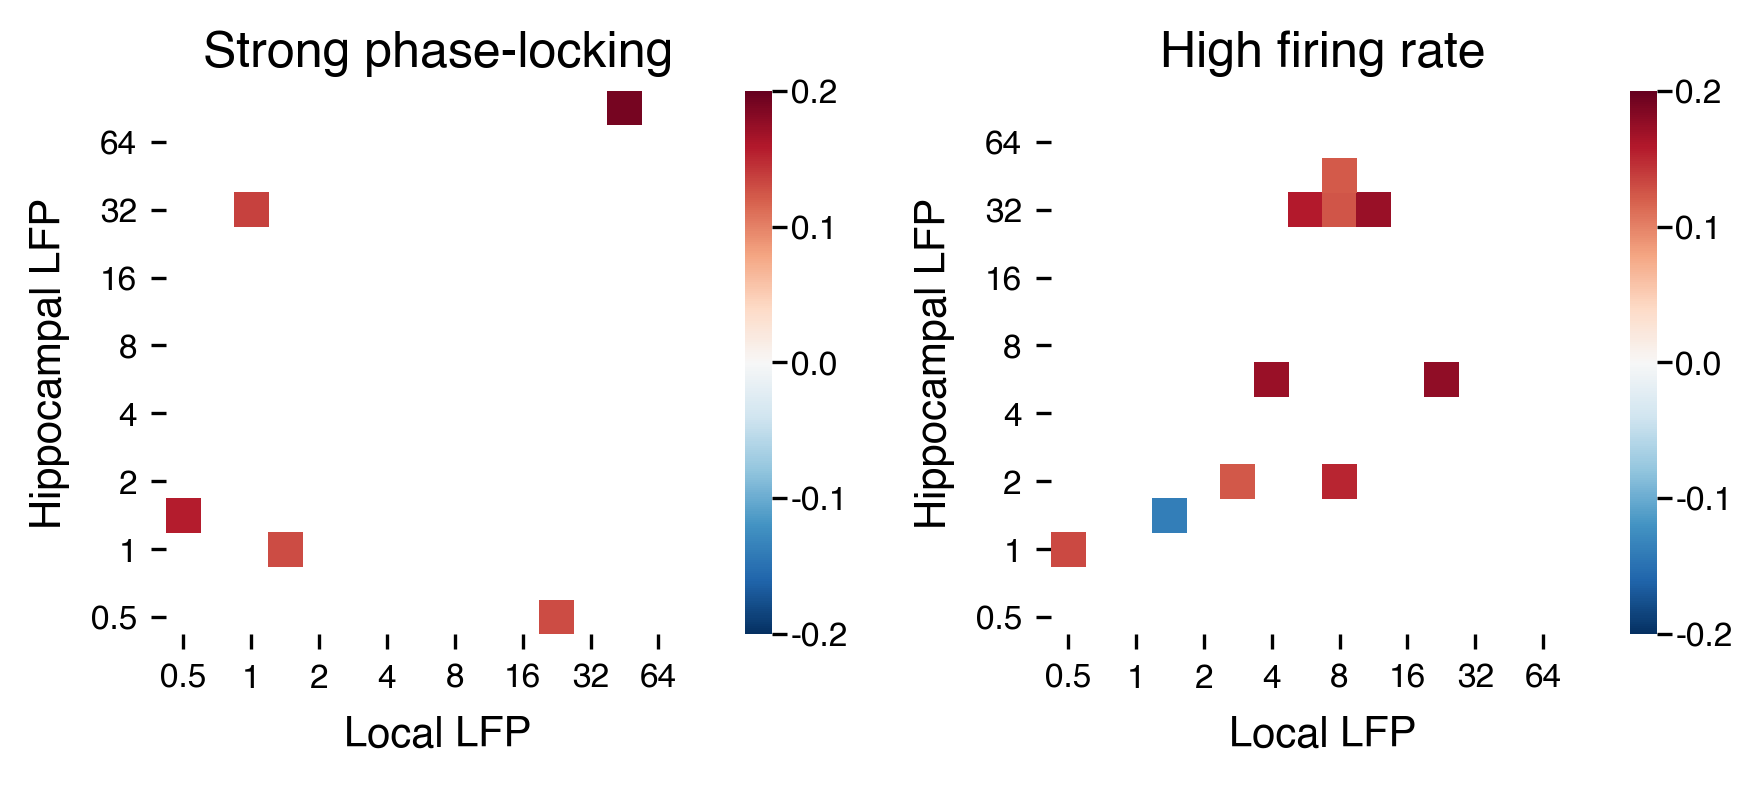

In [640]:
fig, ax = plt.subplots(1, 2, figsize=(colws[2], colws[2]*0.35), dpi=300)
ax = np.ravel(ax)

tickfontsize = 8
labelfontsize = 10
figfontsize = 12

thresh = 0.122
keys = ['target_phase_locking', 'high_firing_rate']
dat = {key: np.mean(xpower_corrs[key], axis=0) for key in keys}
for i in range(len(ax)):
    vmax = np.max(np.concatenate((dat[keys[0]], dat[keys[1]]), axis=0))
    vmin = -vmax
    ax[i] = sns.heatmap(dat[keys[i]], vmin=-0.2, vmax=0.2, square=True, cmap='RdBu_r', cbar_kws={'format': '%.1f'}, ax=ax[i], mask=np.abs(dat[keys[i]])<thresh)
    ax[i].set_xticks(np.arange(len(freqs))[::2] + 0.5)
    ax[i].set_yticks(np.arange(len(freqs))[::2] + 0.5)
    ax[i].set_xticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfontsize)
    ax[i].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfontsize)
    ax[i].set_xlabel('Local LFP', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('Hippocampal LFP', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title('Strong phase-locking' if keys[i]=='target_phase_locking' else 'High firing rate', fontsize=figfontsize, y=1.02)
    ax[i].invert_yaxis()
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
    cbar.set_ticks(np.linspace(-0.2, 0.2, 5))

## Hippocampal firing rate relations with spike phase and firing rate
### Adjusted for regional specificity

In [236]:
files = glob('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/hippocampal_fr_by_pl_fr/lfp_target_region/sig/*.pkl')
print('{} files'.format(len(files)))

297 files


In [328]:
# Include hippocampal regions with 5 or more single-units
n_neuron_thresh = 7
include_rois = []
for subj_sess in subj_df.subj_sess.unique():
    try:
        _, fr_df, *_ = phase_locking.load_spikes(subj_sess)
        for roi in ['LAH', 'LMH', 'LPH', 'RAH', 'RMH', 'RPH']:
            if roi in fr_df.location.tolist():
                if len(fr_df.query("(location=='{}')".format(roi))) > n_neuron_thresh:
                    include_rois.append((subj_sess, roi, len(fr_df.query("(location=='{}')".format(roi)))))
    except:
        continue

In [330]:
include_rois

[('U379_ses1', 'LAH', 9),
 ('U379_ses1', 'RAH', 8),
 ('U384_ses3', 'LAH', 8),
 ('U395_ses3', 'LAH', 9),
 ('U371_env1', 'LPH', 11),
 ('U371_env2', 'LPH', 10),
 ('U372_ses2', 'RMH', 8),
 ('U374_ses2', 'LAH', 8),
 ('U380_ses2', 'LAH', 11),
 ('U380_ses3', 'LAH', 8),
 ('U384_ses1', 'LAH', 8),
 ('U384_ses2', 'LAH', 9),
 ('U387_ses1', 'LAH', 8),
 ('U387_ses2', 'LAH', 9),
 ('U387_ses3', 'LAH', 9),
 ('U392_ses1', 'RAH', 10),
 ('U393_ses2', 'LAH', 8),
 ('U385_ses1', 'LAH', 9),
 ('U385_ses1', 'RAH', 8),
 ('U385_ses3', 'LAH', 9),
 ('U385_ses4', 'LAH', 9)]

In [329]:
# Keep hippocampal regions with 5+ neurons
include_rois_ = [subj_sess_ + '_' + lfp_roi_ for subj_sess_, lfp_roi_, _ in include_rois]

files_ = []
for f in files:
    subj_sess_roi = os.path.basename(f).split('-')[1] + '_' + os.path.basename(f).split('-')[3].split('_')[1]
    if subj_sess_roi in include_rois_:
        files_.append(f)
print(len(files_))
files = files_

116


In [331]:
fr_cats = [('hpc_fr', 'hpc_fr_pvals'), ('hpc_fr_meanSub', 'hpc_fr_meanSub_pvals')]
spike_cats = ['target_phase_locking', 'high_firing_rate', 'low_firing_rate', 'local_phase_locking']

# roi_frs[fr_cat][spike_cat] will contain an roi x freq array
# that we can use to Z-score each frequency across rois
roi_frs = OrderedDict([(fr_cat, OrderedDict([(spike_cat, [])
                                                   for spike_cat in spike_cats]))
                          for fr_cat, fr_cat_pvals in fr_cats])

fr_output = []
col_names = ['subj', 'sess', 'unit', 'subj_sess', 'subj_sess_unit', 'hpc_cat', 'spike_cat', 'freq', 'val']
for iFile, f in enumerate(files):
    # Load fr data.
    fr_dat = dio.open_pickle(f)
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    subj, sess = subj_sess.split('_')
    unit = int(fsplit[2][5:])
    subj_sess_unit = '{}_{}'.format(subj_sess, unit)
    lfp_roi = fsplit[3][4:]
    
    for fr_cat, fr_cat_pvals in fr_cats:
        for spike_cat in spike_cats:
            roi_frs[fr_cat][spike_cat].append(fr_dat[fr_cat][spike_cat])
            fr_output.append([subj, sess, unit, subj_sess, subj_sess_unit, fr_cat, spike_cat, -1, fr_dat[fr_cat][spike_cat]])
    
for fr_cat, fr_cat_pvals in fr_cats:
    for spike_cat in spike_cats:
        roi_frs[fr_cat][spike_cat] = np.array(roi_frs[fr_cat][spike_cat])
        
fr_output = pd.DataFrame(fr_output, columns=col_names)
fr_output.shape

(928, 9)

In [411]:
output = pd.concat((power_output, fr_output))[['subj', 'unit', 'subj_sess_unit', 'hpc_cat', 'spike_cat', 'freq', 'val']]
n_cells = len(np.unique(output['subj_sess_unit']))

map_dtypes = {'subj': str,
              'unit': int,
              'subj_sess_unit': str,
              'hpc_cat': str,
              'spike_cat': str,
              'freq': np.int8,
              'val': np.float64}
for col, dtype in map_dtypes.items():
    output[col] = output[col].astype(dtype)

output.shape, n_cells

((25544, 7), 362)

In [424]:
# Perform a paired-samples t-test across neurons within each subject,
# than a one-sample t-test on the t-stats from each subject (in
# subjects with > n_neuron_thresh neurons).
n_neuron_thresh = 7
alpha = 0.05

pvals = []
for iFreq in range(len(freqs)):
    subj_t_stats = (output.query("(hpc_cat=='z_power') & (spike_cat=='target_phase_locking') & (freq=={})".format(iFreq))
                    .groupby('subj').agg({'unit': len, 'val': lambda x: stats.ttest_1samp(x, 0)[0]}).query("unit>{}".format(n_neuron_thresh))['val'])
    mod_fit = stats.ttest_1samp(subj_t_stats, 0)
    pvals.append(mod_fit[1])
    
pvals_corr = sm.stats.multipletests(pvals, alpha=alpha, method='holm')
print('Significant frequencies at alpha={}: {}'.format(alpha, np.round(freqs[pvals_corr[0]], 1)))
print('Insignificant frequencies: {}'.format(np.round(freqs[np.invert(pvals_corr[0])], 1)))

Significant frequencies at alpha=0.05: [ 1.4  2.   2.8  4.   5.7  8.  11.3 16.  45.3 64.  90.5]
Insignificant frequencies: [ 0.5  0.7  1.  22.6 32. ]


In [425]:
# Perform a paired-samples t-test across neurons within each subject,
# than a one-sample t-test on the t-stats from each subject (in
# subjects with > n_neuron_thresh neurons).
n_neuron_thresh = 7
alpha = 0.05

pvals = []
for iFreq in range(len(freqs)):
    subj_t_stats = (output.query("(hpc_cat=='z_power') & (spike_cat=='high_firing_rate') & (freq=={})".format(iFreq))
                    .groupby('subj').agg({'unit': len, 'val': lambda x: stats.ttest_1samp(x, 0)[0]}).query("unit>{}".format(n_neuron_thresh))['val'])
    mod_fit = stats.ttest_1samp(subj_t_stats, 0)
    pvals.append(mod_fit[1])
    
pvals_corr = sm.stats.multipletests(pvals, alpha=alpha, method='holm')
print('Significant frequencies at alpha={}: {}'.format(alpha, np.round(freqs[pvals_corr[0]], 1)))
print('Insignificant frequencies: {}'.format(np.round(freqs[np.invert(pvals_corr[0])], 1)))

Significant frequencies at alpha=0.05: []
Insignificant frequencies: [ 0.5  0.7  1.   1.4  2.   2.8  4.   5.7  8.  11.3 16.  22.6 32.  45.3
 64.  90.5]


In [413]:
# Perform a paired-samples t-test across neurons within each subject,
# than a one-sample t-test on the t-stats from each subject (in
# subjects with > n_neuron_thresh neurons).
n_neuron_thresh = 7
arr = output.query("(hpc_cat=='z_power_corrs') & (spike_cat=='target_phase_locking')")['val']
subj_t_stats = (output.query("(hpc_cat=='z_power_corrs') & (spike_cat=='target_phase_locking')")
                .groupby('subj').agg({'unit': len, 'val': lambda x: stats.ttest_1samp(x, 0)[0]}).query("unit>{}".format(n_neuron_thresh))['val'])
mod_fit = stats.ttest_1samp(subj_t_stats, 0)

print('{:.1f} +/- {:.1f} power correlation across {} significant neurons'.format(np.mean(arr), np.std(arr), len(arr)))
print('t = {:.1f} +/- {:.1f}; t({}) = {:.1f}, p = {:.4f}'.format(np.mean(subj_t_stats), np.std(subj_t_stats), len(subj_t_stats)-1, mod_fit[0], mod_fit[1]))

0.9 +/- 2.2 power correlation across 362 significant neurons
t = 2.1 +/- 2.1; t(13) = 3.6, p = 0.0034


In [415]:
# Perform a paired-samples t-test across neurons within each subject,
# than a one-sample t-test on the t-stats from each subject (in
# subjects with > n_neuron_thresh neurons).
n_neuron_thresh = 7
arr = output.query("(hpc_cat=='z_power_corrs') & (spike_cat=='high_firing_rate')")['val']
subj_t_stats = (output.query("(hpc_cat=='z_power_corrs') & (spike_cat=='high_firing_rate')")
                .groupby('subj').agg({'unit': len, 'val': lambda x: stats.ttest_1samp(x, 0)[0]}).query("unit>{}".format(n_neuron_thresh))['val'])
mod_fit = stats.ttest_1samp(subj_t_stats, 0)

print('{:.1f} +/- {:.1f} power correlation across {} significant neurons'.format(np.mean(arr), np.std(arr), len(arr)))
print('t = {:.1f} +/- {:.1f}; t({}) = {:.1f}, p = {:.4f}'.format(np.mean(subj_t_stats), np.std(subj_t_stats), len(subj_t_stats)-1, mod_fit[0], mod_fit[1]))

0.1 +/- 2.2 power correlation across 362 significant neurons
t = 0.2 +/- 1.3; t(13) = 0.5, p = 0.6525


In [287]:
(output
 .query("(hpc_cat=='z_power_corrs') & (spike_cat=='target_phase_locking')")
 .groupby(['subj'])
 .agg({'subj_sess_unit': lambda x: len(np.unique(x)), 'val': lambda x: '{:.2f} $\pm$ {:.2f}'.format(np.mean(x), stats.sem(x))}))

subj_sess_unit               val
subj                                  
U369              19   0.96 $\pm$ 0.28
U370               8   2.51 $\pm$ 1.36
U371              57   0.64 $\pm$ 0.16
U372              17   3.80 $\pm$ 0.63
U373              14   0.11 $\pm$ 0.33
U374               3   0.71 $\pm$ 0.77
U379               2   0.01 $\pm$ 0.01
U380              33   0.29 $\pm$ 0.25
U381              40  -0.09 $\pm$ 0.25
U384              32   1.45 $\pm$ 0.45
U385              38  -0.12 $\pm$ 0.21
U387              25   3.93 $\pm$ 0.64
U390               5   0.10 $\pm$ 0.74
U392               2   4.81 $\pm$ 0.03
U393              12  -0.07 $\pm$ 0.35
U394              11   0.22 $\pm$ 0.26
U395              32   0.61 $\pm$ 0.27
U396              12   0.64 $\pm$ 0.44

In [339]:
arr = output.query("(hpc_cat=='hpc_fr') & (spike_cat=='target_phase_locking')")['val']
mod_fit = stats.ttest_1samp(arr, 0)
df = len(arr) - 1
print('{:.1f} +/- {:.1f}, t({}) = {:.1f}, p = {:.3f}'.format(np.mean(arr), np.std(arr), df, mod_fit[0], mod_fit[1]))

0.6 +/- 2.6, t(115) = 2.4, p = 0.016


In [493]:
(output
 .query("(hpc_cat=='hpc_fr') & (spike_cat=='target_phase_locking')")
 .groupby(['subj'])
 .agg({'subj_sess_unit': lambda x: len(np.unique(x)), 'val': lambda x: '{:.2f}, {:.2f}'.format(np.mean(x)/stats.sem(x), stats.ttest_1samp(x, 0)[0])}))

subj_sess_unit             val
subj                                
U371              39    -3.83, -3.83
U374               2      1.08, 1.08
U379               2  -21.12, -21.12
U384              16    -0.29, -0.29
U385              27      1.34, 1.34
U387              25      6.10, 6.10
U392               2  -10.89, -10.89
U393               3      3.61, 3.61

In [ ]:
(output
 .query("(hpc_cat=='hpc_fr') & (spike_cat=='target_phase_locking')")
 .groupby(['subj'])
 .agg({'subj_sess_unit': lambda x: len(np.unique(x)), 'val': lambda x: '{:.2f} $\pm$ {:.2f}'.format(np.mean(x), stats.sem(x))}))

In [275]:
output['spike_cat'].unique(), output['hpc_cat'].unique()

(array(['target_phase_locking', 'high_firing_rate'], dtype=object),
 array(['z_power', 'z_power_corrs', 'hpc_fr_meanSub'], dtype=object))

In [729]:
# Save the df.
if False:
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/figs/power_by_pl_fr_{}-sig-pl-neurons.csv'.format(n_cells)
    output.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs/power_by_pl_fr_362-sig-pl-neurons.csv


In [218]:
print('high phase-locking:')
alpha = 0.05
n = len(roi_frs['hpc_fr']['high_firing_rate'])
for fr_cat in ['hpc_fr', 'hpc_fr_meanSub']:
    print(fr_cat,
          'n={}'.format(n),
          np.round(np.mean(roi_frs[fr_cat]['target_phase_locking']), 2), 
          np.round(np.std(roi_frs[fr_cat]['target_phase_locking']), 2), 
          stats.ttest_1samp(roi_frs[fr_cat]['target_phase_locking'], 0)[1] < alpha,
          stats.ttest_1samp(roi_frs[fr_cat]['target_phase_locking'], 0))

high phase-locking:
hpc_fr n=167 0.4 2.37 True Ttest_1sampResult(statistic=2.1536447041946074, pvalue=0.03271095127249958)
hpc_fr_meanSub n=167 0.33 1.87 True Ttest_1sampResult(statistic=2.2975725054673957, pvalue=0.022834452326611437)


In [376]:
# FDR correct p-values
fr_cats = ['hpc_fr_pvals', 'hpc_fr_meanSub_pvals']
spike_cats = ['target_phase_locking', 'high_firing_rate', 'low_firing_rate', 'local_phase_locking']
pval_cats = ['max_z', 'max_z_ind', 'bs_ind', 'pval', 'sig_fdr']

p_stats = OrderedDict([(fr_cat, 
                        OrderedDict([(spike_cat, 
                                      OrderedDict([(pval_cat, [])
                                                   for pval_cat in pval_cats]))
                                     for spike_cat in spike_cats]))
                       for fr_cat in fr_cats])
for f in files:
    # Load fr data.
    fr_dat = dio.open_pickle(f)
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    
    for fr_cat in fr_cats:
        for spike_cat in spike_cats:
            for pval_cat in fr_dat[fr_cat][spike_cat].keys():
                p_stats[fr_cat][spike_cat][pval_cat].append(fr_dat[fr_cat][spike_cat][pval_cat])
                
for fr_cat in fr_cats:
    for spike_cat in spike_cats:
        pvals_in = p_stats[fr_cat][spike_cat]['pval']
        p_stats[fr_cat][spike_cat]['sig_fdr'] = sm.stats.multipletests(pvals_in, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]

In [377]:
for fr_cat in fr_cats:
    for spike_cat in spike_cats:
        print(fr_cat, spike_cat, np.sum(p_stats[fr_cat][spike_cat]['sig_fdr']), np.mean(p_stats[fr_cat][spike_cat]['sig_fdr']))
        print('pos_max_z', np.mean(np.array(p_stats[fr_cat][spike_cat]['max_z'])[np.where(p_stats[fr_cat][spike_cat]['sig_fdr'])[0]]>0))
        print('mean_freq_ind', np.mean(np.array(p_stats[fr_cat][spike_cat]['max_z_ind'])[np.where(p_stats[fr_cat][spike_cat]['sig_fdr'])[0]]))
        print('mean(|max_z|)', np.mean(np.abs(p_stats[fr_cat][spike_cat]['max_z'])[np.where(p_stats[fr_cat][spike_cat]['sig_fdr'])[0]]))
        print('')

hpc_fr_pvals target_phase_locking 34 0.16113744075829384
pos_max_z 0.7647058823529411
mean_freq_ind 0.0
mean(|max_z|) 4.484926503385469

hpc_fr_pvals high_firing_rate 130 0.6161137440758294
pos_max_z 0.7461538461538462
mean_freq_ind 0.0
mean(|max_z|) 6.769495513096639

hpc_fr_pvals low_firing_rate 79 0.3744075829383886
pos_max_z 0.2911392405063291
mean_freq_ind 0.0
mean(|max_z|) 4.734799554642476

hpc_fr_pvals local_phase_locking 27 0.12796208530805686
pos_max_z 0.6666666666666666
mean_freq_ind 0.0
mean(|max_z|) 4.682658281452846

hpc_fr_meanSub_pvals target_phase_locking 31 0.14691943127962084
pos_max_z 0.7741935483870968
mean_freq_ind 0.0
mean(|max_z|) 3.8301850210827393

hpc_fr_meanSub_pvals high_firing_rate 137 0.6492890995260664
pos_max_z 0.2773722627737226
mean_freq_ind 0.0
mean(|max_z|) 6.182199493965248

hpc_fr_meanSub_pvals low_firing_rate 76 0.36018957345971564
pos_max_z 0.7105263157894737
mean_freq_ind 0.0
mean(|max_z|) 4.514094714330563

hpc_fr_meanSub_pvals local_phase_loc

In [36]:
roi_frs.keys(), roi_frs['hpc_fr'].keys()

(odict_keys(['hpc_fr', 'hpc_fr_meanSub']),
 odict_keys(['target_phase_locking', 'high_firing_rate', 'low_firing_rate', 'local_phase_locking']))

In [39]:
len(spike_cat_dat), len(z_dat)

(1054, 422)

In [61]:
np.mean(roi_frs['hpc_fr']['target_phase_locking']), stats.ttest_1samp(roi_frs['hpc_fr']['target_phase_locking'], 0)

(0.42879276810010375,
 Ttest_1sampResult(statistic=2.8547129461198213, pvalue=0.0047394147909206276))

In [140]:
np.mean(roi_frs['hpc_fr_meanSub']['target_phase_locking']), stats.ttest_1samp(roi_frs['hpc_fr_meanSub']['target_phase_locking'], 0)

(0.3341404873221686,
 Ttest_1sampResult(statistic=2.2975725054673957, pvalue=0.022834452326611437))

In [141]:
np.mean(roi_frs['hpc_fr_meanSub']['high_firing_rate']), stats.ttest_1samp(roi_frs['hpc_fr_meanSub']['high_firing_rate'], 0)

(-1.6028805963927812,
 Ttest_1sampResult(statistic=-3.776323061238352, pvalue=0.00022139696556009033))

In [127]:
8.22047/colws[2]

1.2000002919541808

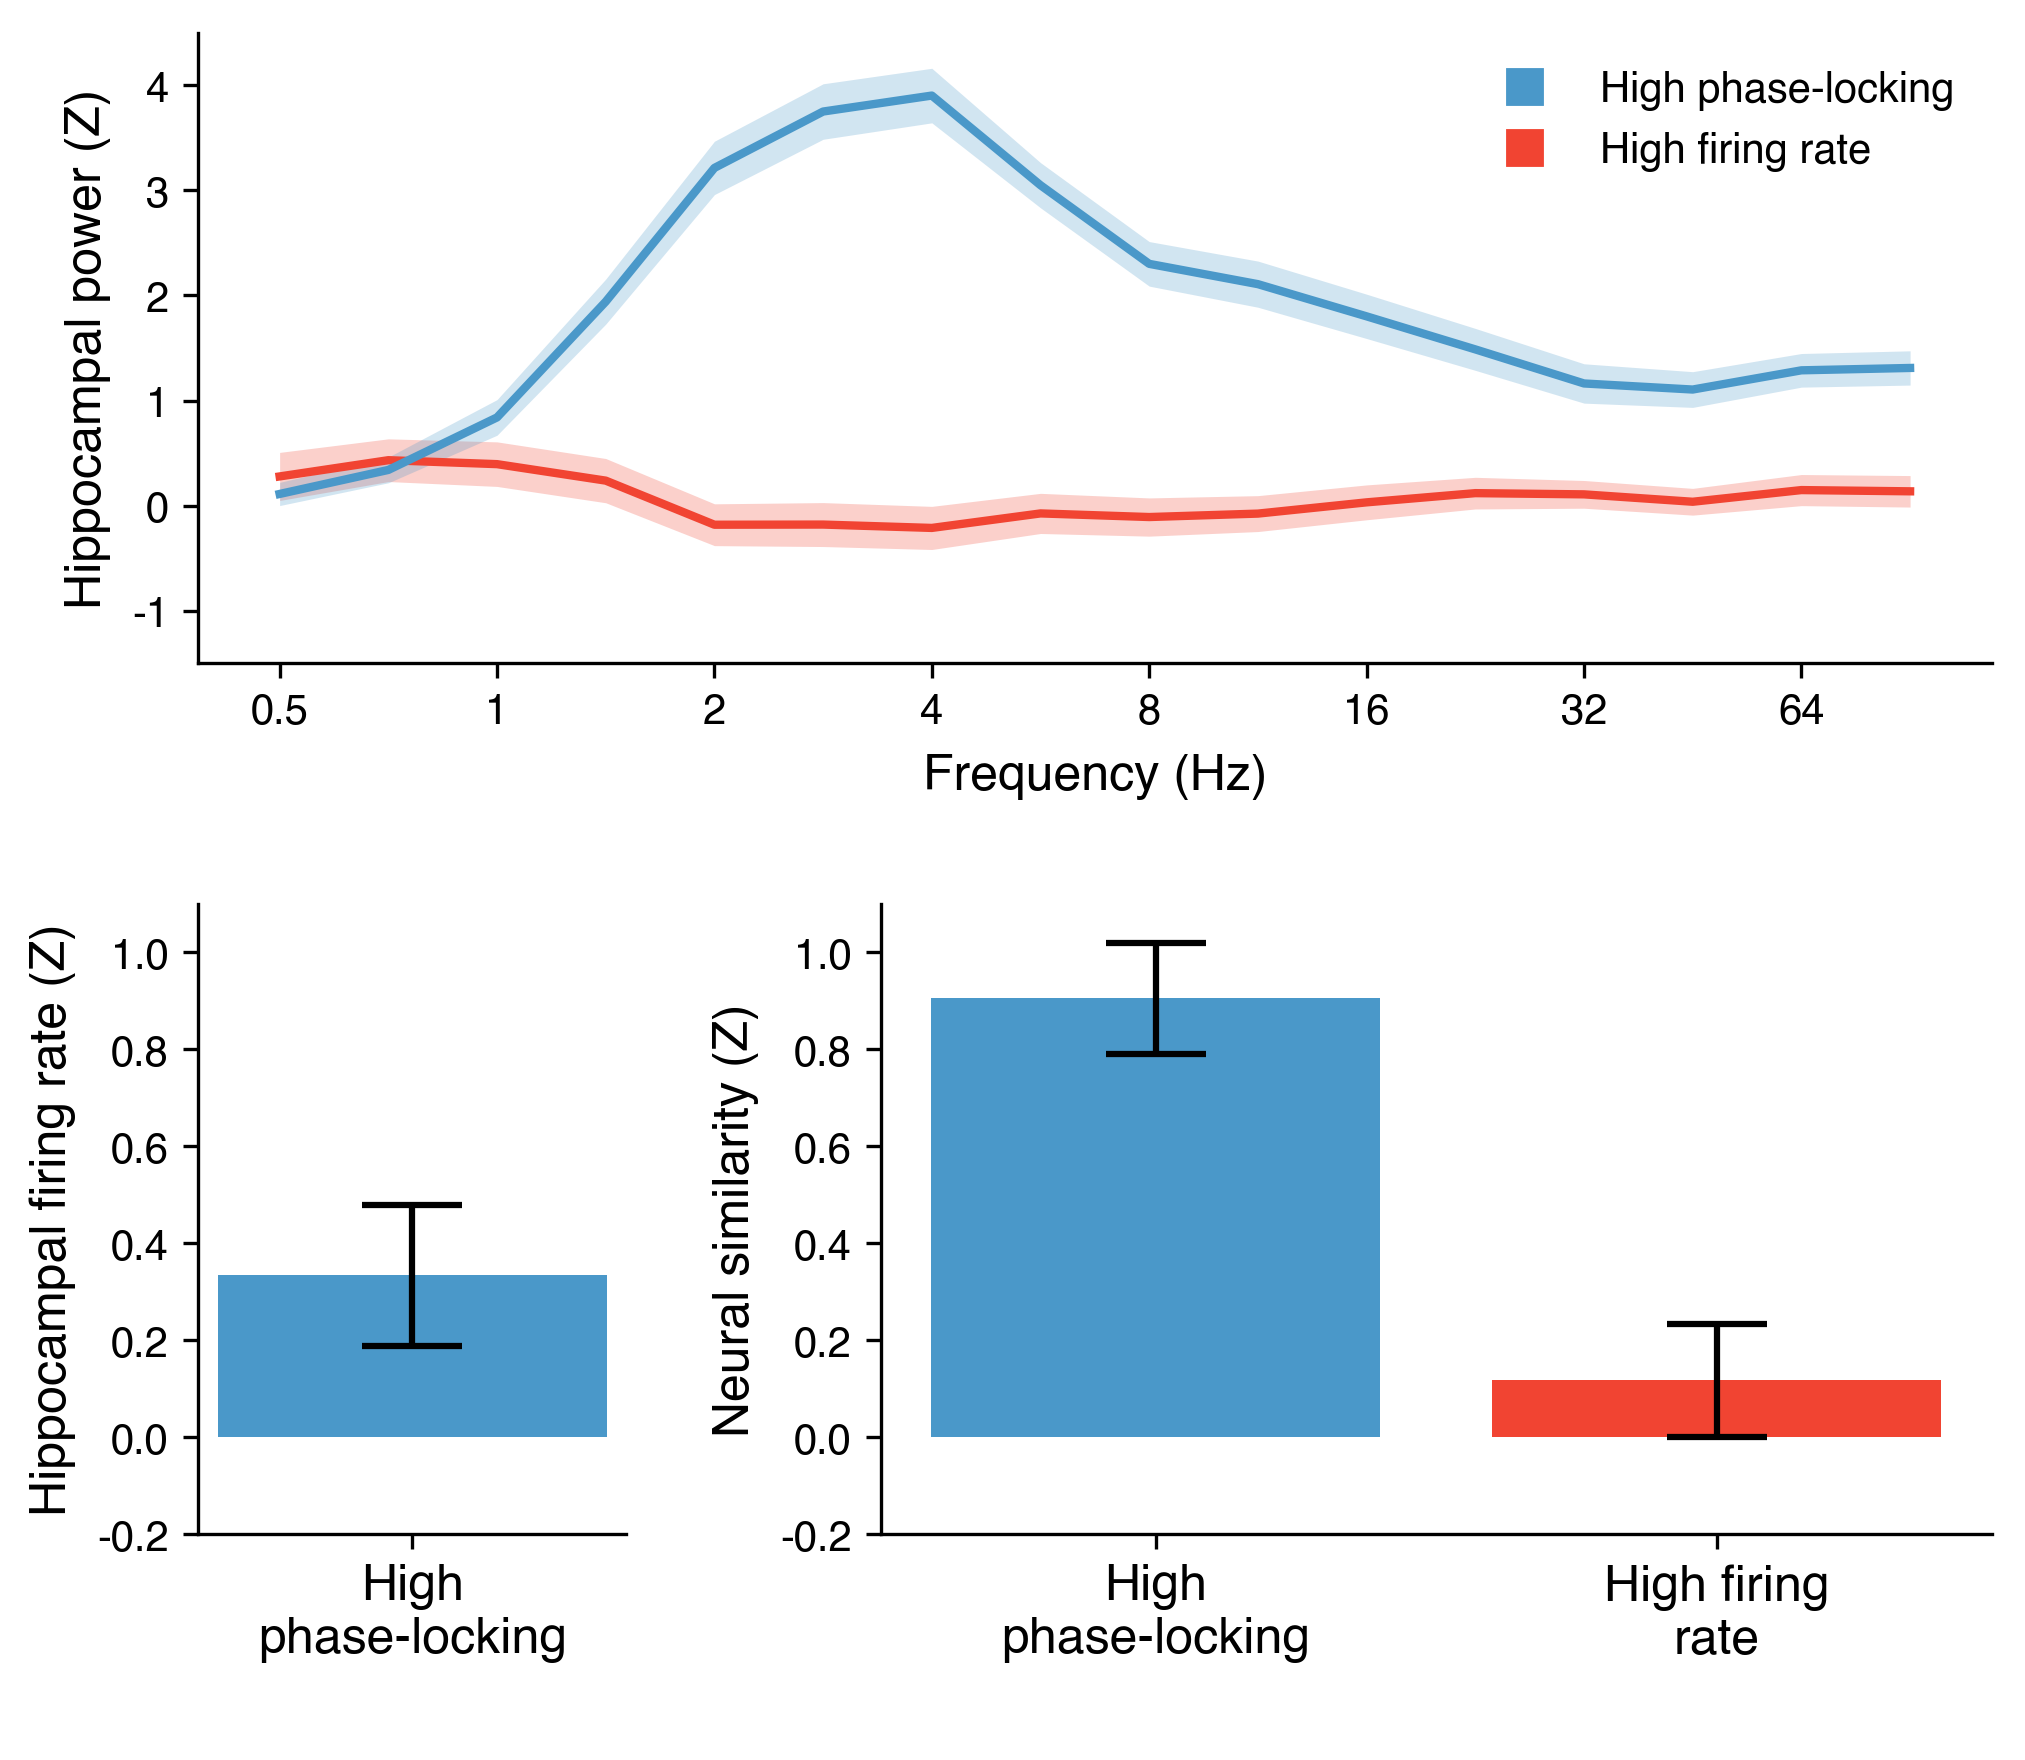

In [146]:
fig = plt.figure(figsize=(colws[2], colws[2]*1.2), dpi=300)
# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
# ax2 = plt.subplot2grid((2, 2), (1, 0))
# ax3 = plt.subplot2grid((2, 2), (1, 1))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=1)
ax3 = plt.subplot2grid((3, 3), (1, 1), colspan=2)
ax = [ax1, ax2, ax3]

tickfontsize = 10
labelfontsize = 12
figfontsize = 15

power_cats = ['z_power', 'z_power_corrs']
spike_cats = ['high_firing_rate', 'target_phase_locking']
color_inds = [1, 0]

i = 0
for iSpike_cat, spike_cat in enumerate(spike_cats):
    dat = np.array(roi_powers['z_power'][spike_cat])
    means = np.nanmean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[iSpike_cat]], alpha=0.25, linewidth=0)
    ax[i].plot(x_ax, means, color=colors[color_inds[iSpike_cat]], linewidth=2)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1.5, 4.5])
ax[i].set_yticks(np.arange(-1, 4.5, 1, dtype=np.int))
ax[i].set_yticklabels(np.arange(-1, 4.5, 1, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Hippocampal power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='High phase-locking', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='High firing rate', markerfacecolor=colors[1], markersize=tickfontsize)]
legend = ax[i].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

# --------------------------------------------
i = 1
spike_cats = ['target_phase_locking']
spike_cat_dat = []
z_dat = []
for spike_cat in spike_cats:
    spike_cat_dat.extend(list(np.repeat(spike_cat, len(roi_frs['hpc_fr_meanSub'][spike_cat]))))
    z_dat.extend(list(roi_frs['hpc_fr_meanSub'][spike_cat]))
dat = pd.DataFrame(np.array([spike_cat_dat, z_dat]).T, columns=['spike_cat', 'z'])
dat['spike_cat'] = dat['spike_cat'].astype('category').cat.reorder_categories(spike_cats, ordered=True)
dat['z'] = dat['z'].astype(np.float64)

ax[i] = sns.barplot(x='spike_cat', y='z', data=dat, ax=ax[i],
                    ci=None, palette=[colors[0], colors[1]], saturation=1)
# ax[i].errorbar(np.arange(2), dat.groupby('spike_cat')['z'].mean().values, 
#                yerr=dat.groupby('spike_cat')['z'].apply(lambda x: stats.sem(x)).values,
#                ecolor='k', elinewidth=1, capsize=12, capthick=1, linewidth=0)
ax[i].errorbar(np.arange(1), dat['z'].mean(), yerr=stats.sem(dat['z']),
               ecolor='k', elinewidth=1.5, capsize=12, capthick=1.5, linewidth=0)
ax[i].set_xticklabels(['High\nphase-locking', 'High firing\nrate'], fontsize=labelfontsize)
ax[i].set_ylim([-0.2, 1.1])
ax[i].set_yticks(np.arange(-0.2, 1.1, 0.2))
ax[i].set_yticklabels(np.round(np.arange(-0.2, 1.1, 0.2), 1), fontsize=tickfontsize)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Hippocampal firing rate (Z)', fontsize=labelfontsize, labelpad=5)

# --------------------------------------------
i = 2
spike_cats = ['target_phase_locking', 'high_firing_rate']
spike_cat_dat = []
z_dat = []
for spike_cat in spike_cats:
    spike_cat_dat.extend(list(np.repeat(spike_cat, len(roi_powers['z_power_corrs'][spike_cat]))))
    z_dat.extend(list(roi_powers['z_power_corrs'][spike_cat]))
dat = pd.DataFrame(np.array([spike_cat_dat, z_dat]).T, columns=['spike_cat', 'z'])
dat['spike_cat'] = dat['spike_cat'].astype('category').cat.reorder_categories(spike_cats, ordered=True)
dat['z'] = dat['z'].astype(np.float64)

ax[i] = sns.barplot(x='spike_cat', y='z', data=dat, ax=ax[i],
                    ci=None, palette=[colors[0], colors[1]], saturation=1)
ax[i].errorbar(np.arange(2), dat.groupby('spike_cat')['z'].mean().values, 
               yerr=dat.groupby('spike_cat')['z'].apply(lambda x: stats.sem(x)).values,
               ecolor='k', elinewidth=1.5, capsize=12, capthick=1.5, linewidth=0)
ax[i].set_xticklabels(['High\nphase-locking', 'High firing\nrate'], fontsize=labelfontsize)
ax[i].set_ylim([-0.2, 1.1])
ax[i].set_yticks(np.arange(-0.2, 1.1, 0.2))
ax[i].set_yticklabels(np.round(np.arange(-0.2, 1.1, 0.2), 1), fontsize=tickfontsize)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neural similarity (Z)', fontsize=labelfontsize, labelpad=5)

# fig.text(0, 0.97, 'A', fontsize=figfontsize)
# fig.text(0.5, 0.97, 'B', fontsize=figfontsize)
fig.tight_layout(pad=1.08, w_pad=2, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/hpc_lfp_power_and_power_correlations_top20%_spike_selection.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/hpc_lfp_power_and_power_correlations_top20%_spike_selection.png', 
                format='png', dpi=300, bbox_inches='tight')

## Power and power correlation relations with spike phase and firing rate

In [174]:
files = glob('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/lfp_all_regions/*.pkl')
print('{} files'.format(len(files)))

0 files


In [246]:
# FDR correct p-values
power_cats = ['power_pvals', 'power_corr_pvals']
spike_cats = ['target_phase_locking', 'firing_rate', 'local_phase_locking']
pval_cats = ['max_z', 'max_z_ind', 'bs_ind', 'pval', 'sig_fdr']

p_stats = OrderedDict([(power_cat, 
                        OrderedDict([(spike_cat, 
                                      OrderedDict([(pval_cat, [])
                                                   for pval_cat in pval_cats]))
                                     for spike_cat in spike_cats]))
                       for power_cat in power_cats])

for f in files:
    # Load power data.
    power_dat = dio.open_pickle(f)
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    subj, sess = subj_sess.split('_')
    unit = int(fsplit[2][5:])
    subj_sess_unit = '{}_{}'.format(subj_sess, unit)
    lfp_roi = fsplit[3][4:]
    
    for power_cat in power_cats:
        for spike_cat in spike_cats:
            for pval_cat in power_dat['target'][power_cat][spike_cat].keys():
                p_stats[power_cat][spike_cat][pval_cat].append(power_dat['target'][power_cat][spike_cat][pval_cat])
            output.append([subj, sess, unit, subj_sess, subj_sess_unit, lfp_roi, power_cat, spike_cat, *list(power_dat['target'][power_cat][spike_cat].values())])
                
for power_cat in power_cats:
    for spike_cat in spike_cats:
        pvals_in = p_stats[power_cat][spike_cat]['pval']
        p_stats[power_cat][spike_cat]['sig_fdr'] = sm.stats.multipletests(pvals_in, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]

In [248]:
for power_cat in power_cats:
    for spike_cat in spike_cats:
        print(power_cat, spike_cat, np.sum(p_stats[power_cat][spike_cat]['sig_fdr']), np.mean(p_stats[power_cat][spike_cat]['sig_fdr']))
        print('pos_max_z', np.mean(np.array(p_stats[power_cat][spike_cat]['max_z'])[np.where(p_stats[power_cat][spike_cat]['sig_fdr'])[0]]>0))
        print('mean_freq_ind', np.mean(np.array(p_stats[power_cat][spike_cat]['max_z_ind'])[np.where(p_stats[power_cat][spike_cat]['sig_fdr'])[0]]))
        print('mean(|max_z|)', np.mean(np.abs(p_stats[power_cat][spike_cat]['max_z'])[np.where(p_stats[power_cat][spike_cat]['sig_fdr'])[0]]))
        print('')

power_pvals target_phase_locking 587 1.0
pos_max_z 0.9131175468483816
mean_freq_ind 5.177172061328791
mean(|max_z|) 10.831515

power_pvals firing_rate 551 0.938671209540034
pos_max_z 0.6370235934664247
mean_freq_ind 3.798548094373866
mean(|max_z|) 6.7718754

power_pvals local_phase_locking 374 0.637137989778535
pos_max_z 0.7112299465240641
mean_freq_ind 6.542780748663102
mean(|max_z|) 5.3636966

power_corr_pvals target_phase_locking 240 0.4088586030664395
pos_max_z 0.5916666666666667
mean_freq_ind 6.95
mean(|max_z|) 4.584425

power_corr_pvals firing_rate 517 0.8807495741056218
pos_max_z 0.6131528046421664
mean_freq_ind 3.9632495164410058
mean(|max_z|) 5.0057397

power_corr_pvals local_phase_locking 288 0.4906303236797274
pos_max_z 0.5902777777777778
mean_freq_ind 6.465277777777778
mean(|max_z|) 4.733783



In [249]:
# FDR correct p-values
power_cats_ = ['power_pvals']
spike_cats = ['target_phase_locking', 'firing_rate', 'local_phase_locking']
pval_cats = ['max_z', 'max_z_ind', 'bs_ind', 'pval', 'sig_fdr']

p_stats_local = OrderedDict([(power_cat, 
                              OrderedDict([(spike_cat, 
                                            OrderedDict([(pval_cat, [])
                                                         for pval_cat in pval_cats]))
                                           for spike_cat in spike_cats]))
                             for power_cat in power_cats_])
for f in files:
    # Load power data.
    power_dat = dio.open_pickle(f)
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    
    for power_cat in power_cats_:
        for spike_cat in spike_cats:
            for pval_cat in power_dat['local'][power_cat][spike_cat].keys():
                p_stats_local[power_cat][spike_cat][pval_cat].append(power_dat['local'][power_cat][spike_cat][pval_cat])
                
for power_cat in power_cats_:
    for spike_cat in spike_cats:
        pvals_in = p_stats_local[power_cat][spike_cat]['pval']
        p_stats_local[power_cat][spike_cat]['sig_fdr'] = sm.stats.multipletests(pvals_in, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]

In [251]:
for power_cat in power_cats_:
    for spike_cat in spike_cats:
        print(power_cat, spike_cat, np.sum(p_stats_local[power_cat][spike_cat]['sig_fdr']), np.mean(p_stats_local[power_cat][spike_cat]['sig_fdr']))
        print('pos_max_z', np.mean(np.array(p_stats_local[power_cat][spike_cat]['max_z'])[np.where(p_stats_local[power_cat][spike_cat]['sig_fdr'])[0]]>0))
        print('mean_freq_ind', np.mean(np.array(p_stats_local[power_cat][spike_cat]['max_z_ind'])[np.where(p_stats_local[power_cat][spike_cat]['sig_fdr'])[0]]))
        print('mean(|max_z|)', np.mean(np.abs(p_stats_local[power_cat][spike_cat]['max_z'])[np.where(p_stats_local[power_cat][spike_cat]['sig_fdr'])[0]]))
        print('')

power_pvals target_phase_locking 370 0.6303236797274276
pos_max_z 0.7783783783783784
mean_freq_ind 8.105405405405405
mean(|max_z|) 5.3485136

power_pvals firing_rate 556 0.9471890971039182
pos_max_z 0.5989208633093526
mean_freq_ind 4.178057553956834
mean(|max_z|) 6.942838

power_pvals local_phase_locking 532 0.9063032367972743
pos_max_z 0.868421052631579
mean_freq_ind 5.725563909774436
mean(|max_z|) 10.009897



In [322]:
power_dat['target']['z_power_corrs']

OrderedDict([('firing_rate',
              array([-3.1935282 ,  0.29523665, -0.38059574,  1.9557796 , -1.4095103 ,
                      2.1417592 , -0.19120912,  0.7425652 ,  1.1244787 , -0.07160626,
                      1.4155097 , -1.1879936 , -2.1956167 , -2.2612174 , -1.2718229 ,
                     -0.89330983], dtype=float32)),
             ('target_phase_locking',
              array([-2.2198913 ,  0.9671257 ,  1.2835393 ,  0.45203638,  4.0914173 ,
                      0.8457468 ,  2.603707  , -3.2642028 ,  0.26931983,  0.5955146 ,
                     -0.27032217,  1.1296376 ,  0.8254052 , -0.34225482,  0.5064002 ,
                      0.993664  ], dtype=float32)),
             ('local_phase_locking',
              array([ 1.5301898 ,  1.9916571 , -0.33609396, -6.003964  , -1.0991235 ,
                      3.5189865 ,  3.3661172 ,  0.7806962 ,  1.3397158 ,  0.52618176,
                      1.4391419 ,  1.0893223 , -0.10744686,  2.8848855 ,  2.5014539 ,
                  

In [323]:
spike_cats

['target_phase_locking', 'firing_rate', 'local_phase_locking']

In [325]:
power_cats = ['z_power', 'z_power_corrs']
spike_cats = ['target_phase_locking', 'firing_rate', 'local_phase_locking']
roi_powers = OrderedDict([(power_cat, OrderedDict([(spike_cat, [])
                                                   for spike_cat in spike_cats]))
                          for power_cat in power_cats])
roi_powers

OrderedDict([('z_power',
              OrderedDict([('target_phase_locking', []),
                           ('firing_rate', []),
                           ('local_phase_locking', [])])),
             ('z_power_corrs',
              OrderedDict([('target_phase_locking', []),
                           ('firing_rate', []),
                           ('local_phase_locking', [])]))])

In [373]:
power_cats = ['z_power', 'z_power_corrs']
spike_cats = ['target_phase_locking', 'firing_rate', 'local_phase_locking']

# roi_powers[power_cat][spike_cat] will contain an roi x freq array
# that we can use to Z-score each frequency across rois
roi_powers = OrderedDict([(power_cat, OrderedDict([(spike_cat, {'raw': [], 'z': []})
                                                   for spike_cat in spike_cats]))
                          for power_cat in power_cats])
for f in files:
    # Load power data.
    power_dat = dio.open_pickle(f)
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    
    roi_powers_ = OrderedDict([(power_cat, OrderedDict([(spike_cat, [])
                                                        for spike_cat in spike_cats]))
                               for power_cat in power_cats])
    for power_cat in power_cats:
        for spike_cat in spike_cats:
            for roi in power_dat.keys():
                try:
                    roi_powers_[power_cat][spike_cat].append(power_dat[roi][power_cat][spike_cat])
                except:
                    continue
                
    # Z-score power at each frequency across all ROIs in the session.
    target_ind = list(power_dat.keys()).index('target')
    for power_cat in power_cats:
        for spike_cat in spike_cats:
            pows = np.array(roi_powers_[power_cat][spike_cat]) # roi x freq
            zpows = (pows - np.mean(pows, axis=0)) / np.std(pows, axis=0)
            roi_powers[power_cat][spike_cat]['raw'].append(pows[target_ind, :])
            roi_powers[power_cat][spike_cat]['z'].append(zpows[target_ind, :])

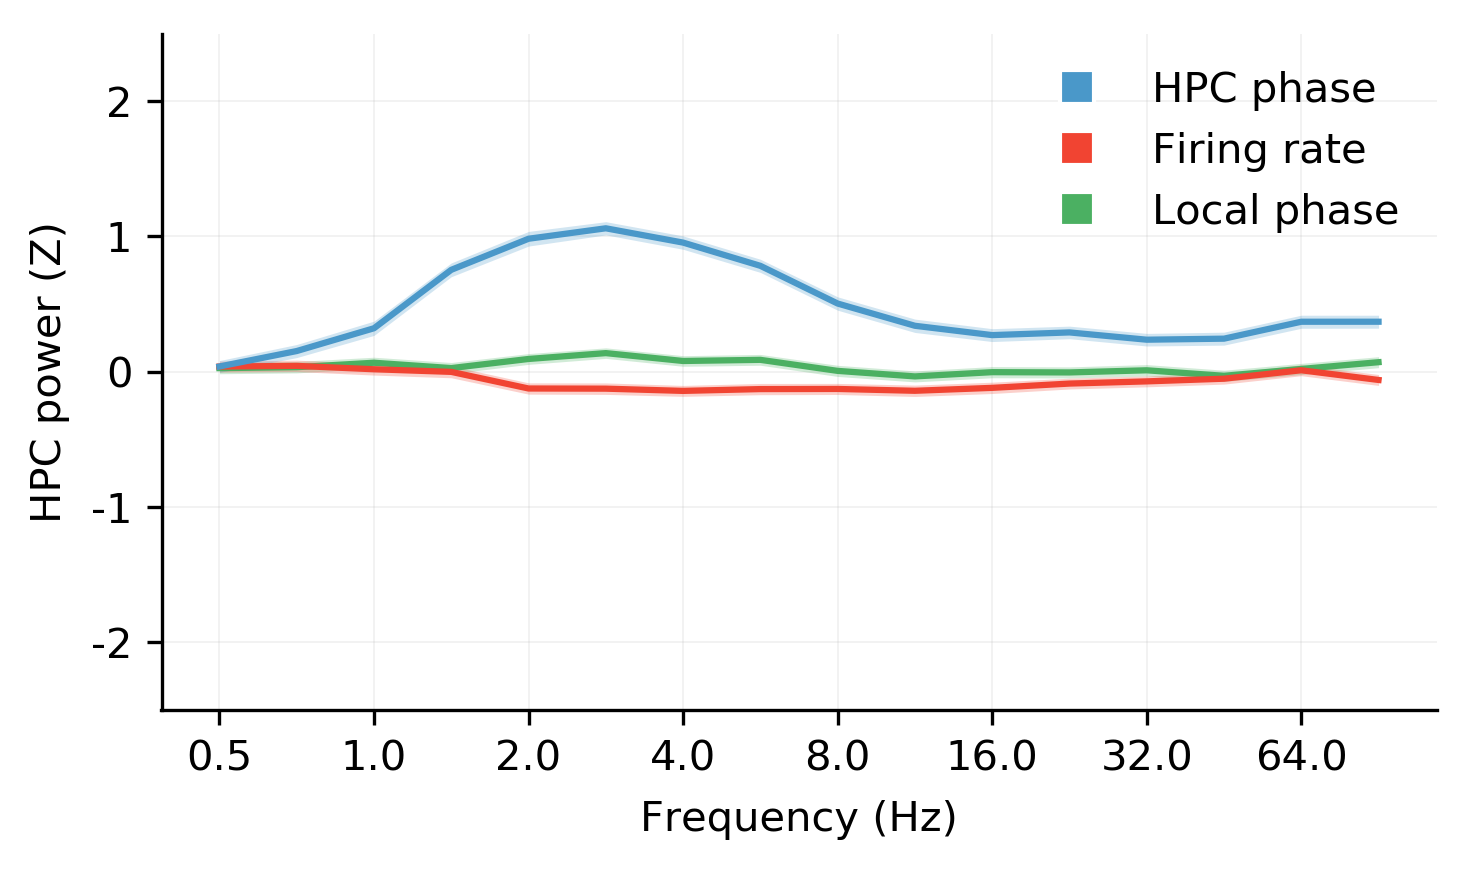

In [381]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

i = 0
color_inds = [2, 1, 0]
for iCon, con in enumerate(['local_phase_locking', 'firing_rate', 'target_phase_locking']):
    dat = np.array(roi_powers['z_power'][con]['z'])
    means = np.nanmean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[iCon]], alpha=0.25, linewidth=0)
    ax[i].plot(x_ax, means, color=colors[color_inds[iCon]], linewidth=1.5)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels(np.round(freqs[::2], 1), fontsize=tickfontsize)
ax[i].set_ylim([-2.5, 2.5])
ax[i].set_yticks(np.arange(-2, 2.5, 1, dtype=np.int))
ax[i].set_yticklabels(np.arange(-2, 2.5, 1, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='HPC phase', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Firing rate', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Local phase', markerfacecolor=colors[2], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_across_freqs_top20%_spike_selection_oneline.png'
                .format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

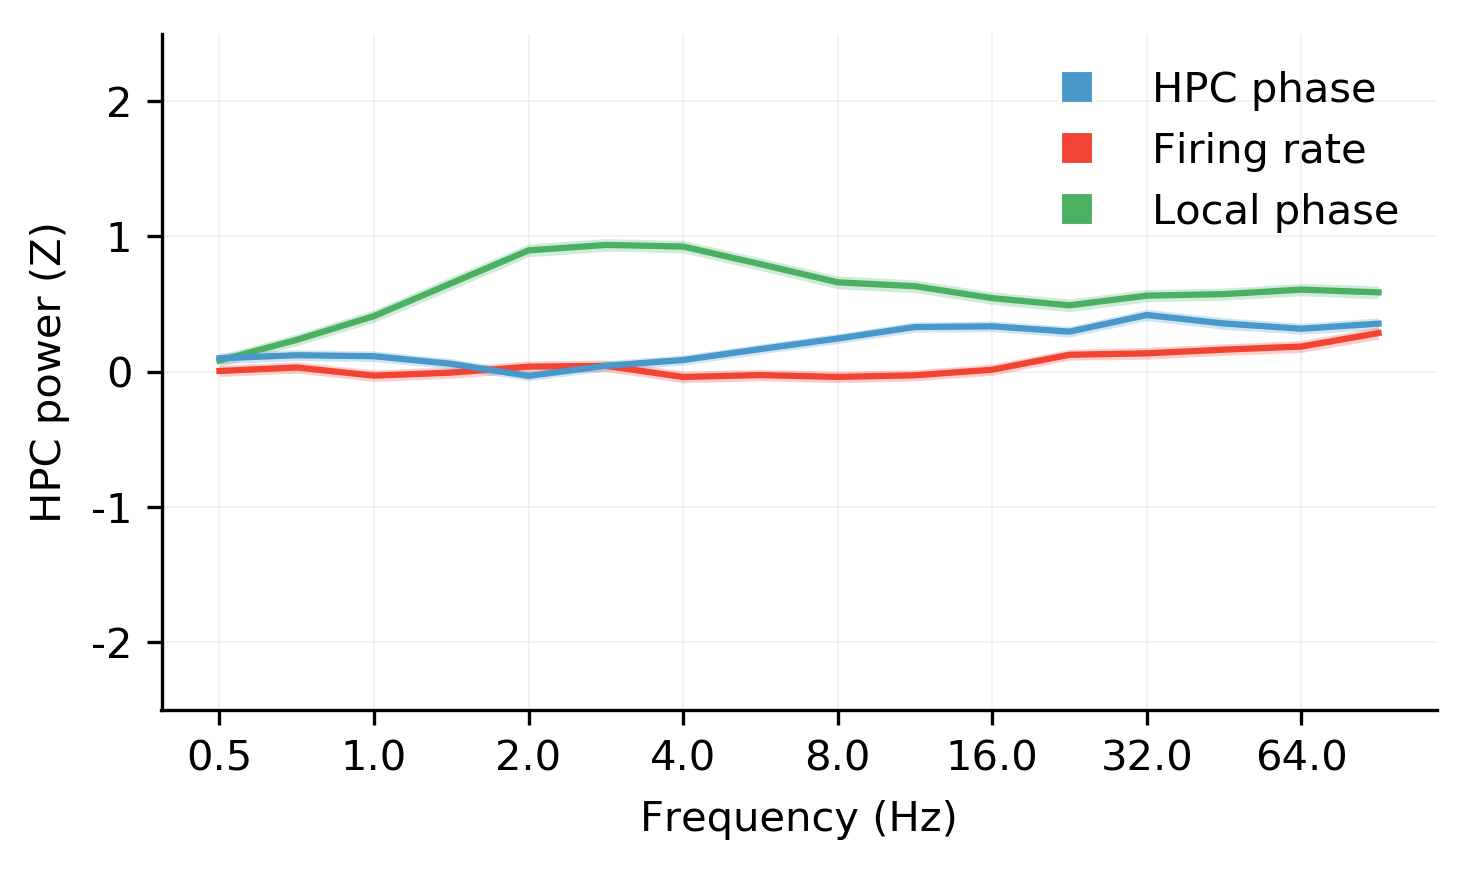

In [372]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

i = 0
color_inds = [2, 1, 0]
for iCon, con in enumerate(['local_phase_locking', 'firing_rate', 'target_phase_locking']):
    dat = np.array(roi_powers['z_power'][con]['z'])
    means = np.nanmean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[iCon]], alpha=0.25, linewidth=0)
    ax[i].plot(x_ax, means, color=colors[color_inds[iCon]], linewidth=1.5)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels(np.round(freqs[::2], 1), fontsize=tickfontsize)
ax[i].set_ylim([-2.5, 2.5])
ax[i].set_yticks(np.arange(-2, 2.5, 1, dtype=np.int))
ax[i].set_yticklabels(np.arange(-2, 2.5, 1, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='HPC phase', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Firing rate', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Local phase', markerfacecolor=colors[2], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_across_freqs_top20%_spike_selection_oneline.png'
                .format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

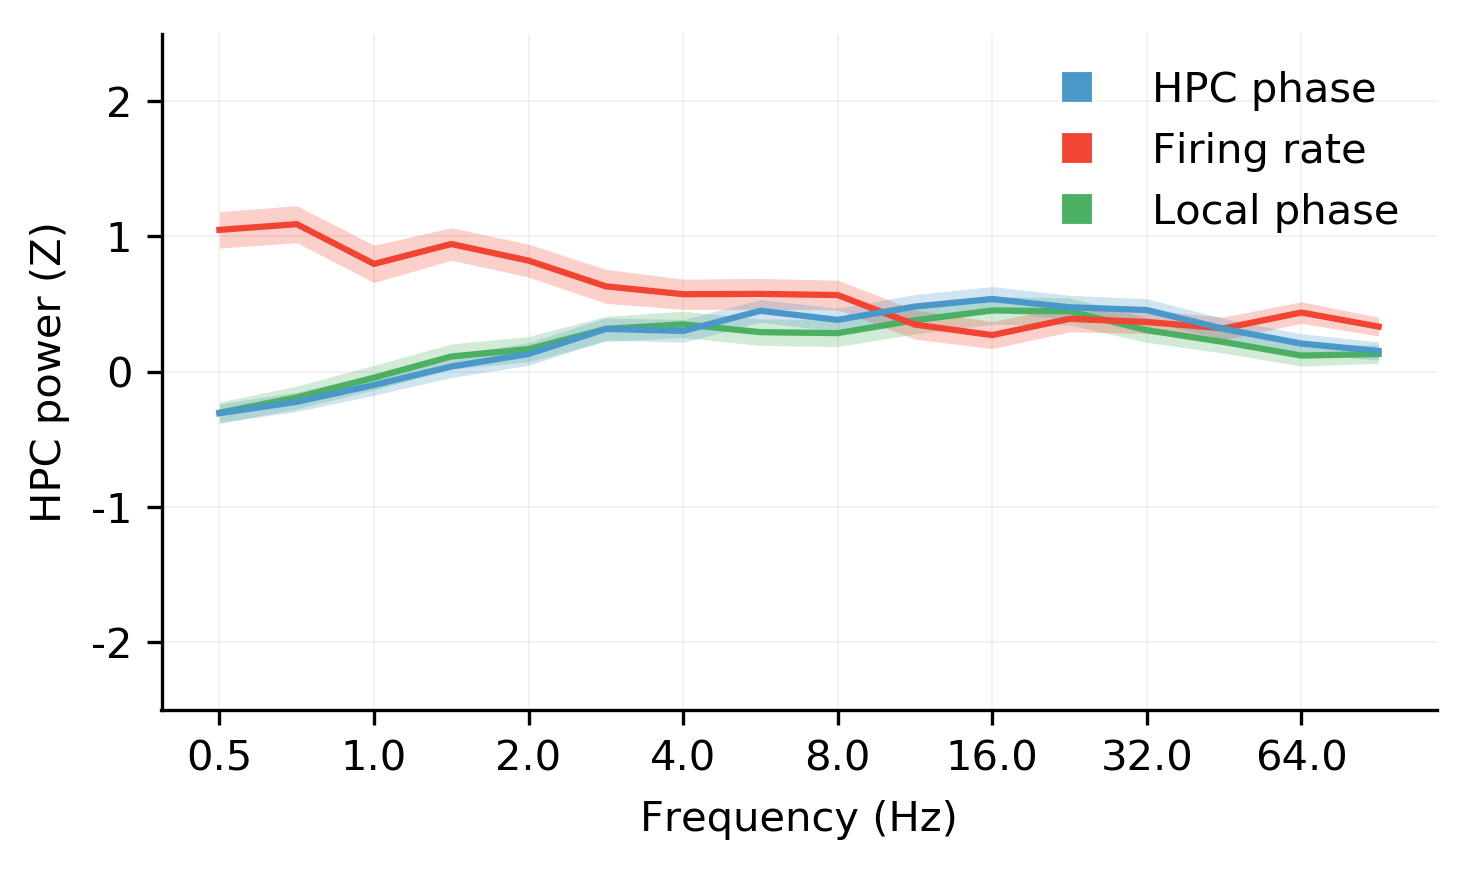

In [312]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

i = 0
color_inds = [2, 1, 0]
for iCon, con in enumerate(['local_phase_locking', 'firing_rate', 'target_phase_locking']):
    dat = np.array([dio.open_pickle(f)['target']['z_power_corrs'][con] for f in files])
    means = np.nanmean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[iCon]], alpha=0.25, linewidth=0)
    ax[i].plot(x_ax, means, color=colors[color_inds[iCon]], linewidth=1.5)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels(np.round(freqs[::2], 1), fontsize=tickfontsize)
ax[i].set_ylim([-2.5, 2.5])
ax[i].set_yticks(np.arange(-2, 2.5, 1, dtype=np.int))
ax[i].set_yticklabels(np.arange(-2, 2.5, 1, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='HPC phase', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Firing rate', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Local phase', markerfacecolor=colors[2], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_across_freqs_top20%_spike_selection_oneline.png'
                .format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

[351, 200, 536, 51]


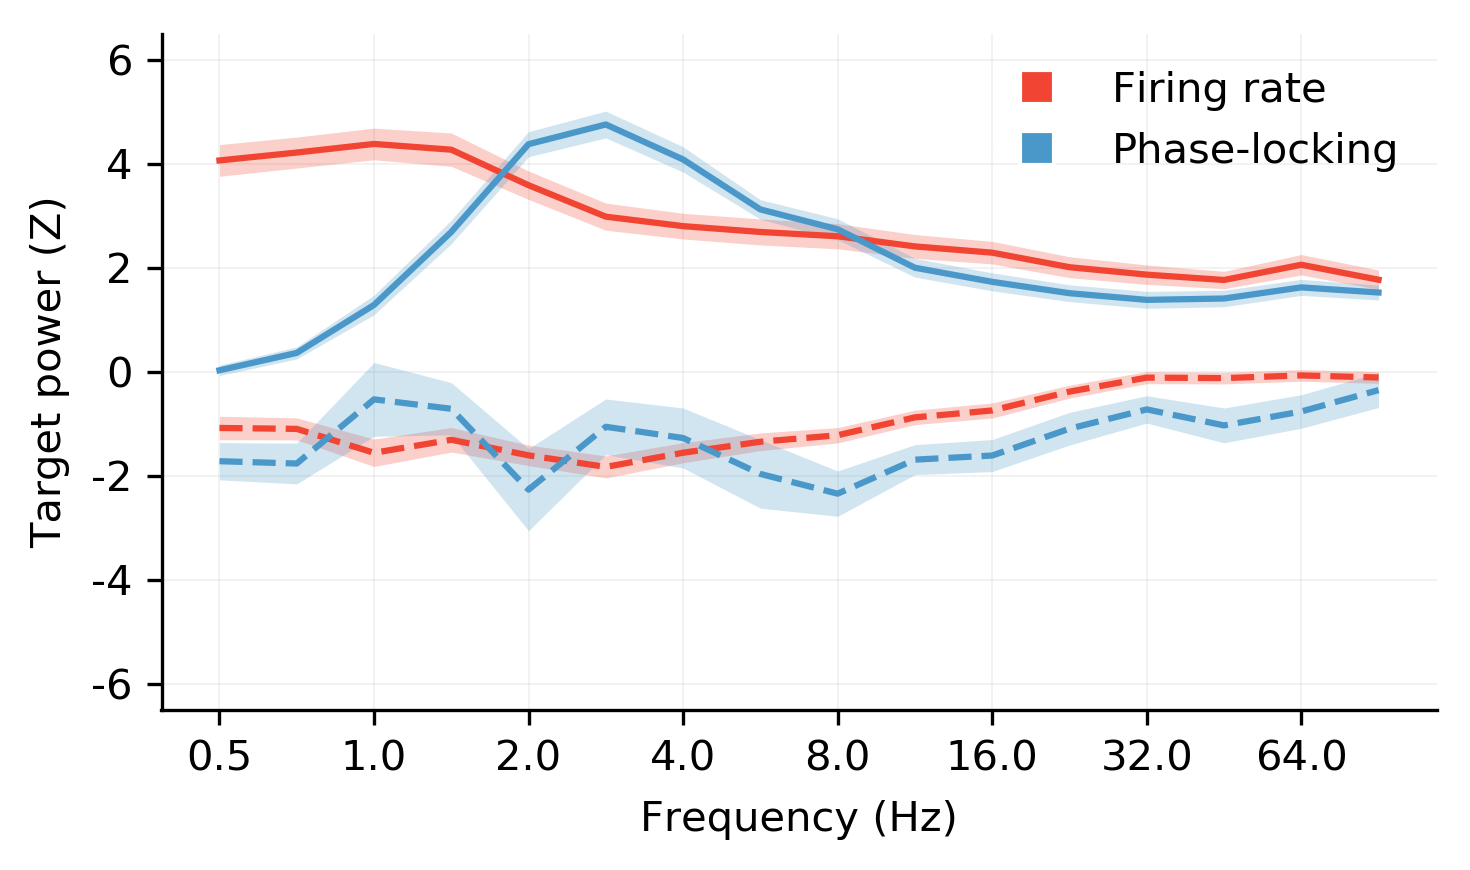

In [313]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

power_cat = 'power_pvals'
cons = [np.where(p_stats[power_cat]['firing_rate']['sig_fdr'] * p_stats[power_cat]['firing_rate']['max_z']>0)[0],
        np.where(p_stats[power_cat]['firing_rate']['sig_fdr'] * p_stats[power_cat]['firing_rate']['max_z']<0)[0],
        np.where(p_stats[power_cat]['target_phase_locking']['sig_fdr'] * p_stats[power_cat]['target_phase_locking']['max_z']>0)[0],
        np.where(p_stats[power_cat]['target_phase_locking']['sig_fdr'] * p_stats[power_cat]['target_phase_locking']['max_z']<0)[0]]

print([len(x) for x in cons])

i = 0
color_inds = [1, 0, 2]

for iCon, con in enumerate(cons):
    if iCon < 2:
        spike_cat = 'firing_rate'
    else:
        spike_cat = 'target_phase_locking'
    dat = np.array([dio.open_pickle(f)['target']['z_power'][spike_cat] for f in files])[con]
    means = np.mean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[int(iCon/2)]], alpha=0.25, linewidth=0)
    if (iCon+1) % 2 != 0:
        ax[i].plot(x_ax, means, color=colors[color_inds[int(iCon/2)]], linewidth=1.5)
    else:
        ax[i].plot(x_ax, means, linestyle='--', color=colors[color_inds[int(iCon/2)]], linewidth=1.5)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels(np.round(freqs[::2], 1), fontsize=tickfontsize)
ax[i].set_ylim([-6.5, 6.5])
ax[i].set_yticks(np.arange(-6, 6.5, 2, dtype=np.int))
ax[i].set_yticklabels(np.arange(-6, 6.5, 2, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Target power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Firing rate', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Phase-locking', markerfacecolor=colors[0], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_across_freqs_top20%_spike_selection_oneline.png'
                .format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

[333, 223, 462, 70]


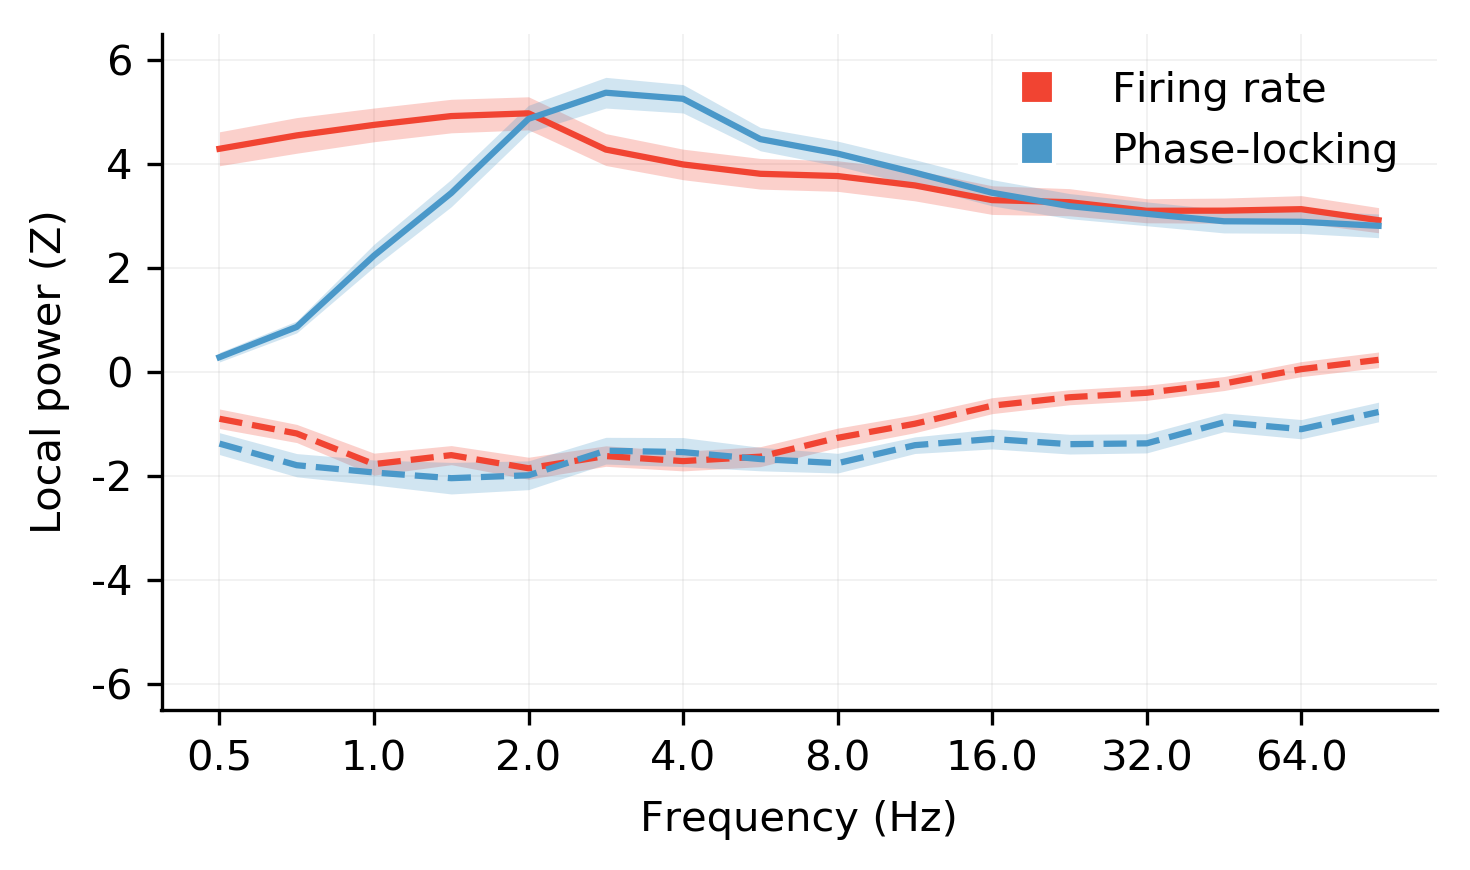

In [303]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

cons = [np.where(p_stats_local['power_pvals']['firing_rate']['sig_fdr'] * p_stats_local['power_pvals']['firing_rate']['max_z']>0)[0],
        np.where(p_stats_local['power_pvals']['firing_rate']['sig_fdr'] * p_stats_local['power_pvals']['firing_rate']['max_z']<0)[0],
        np.where(p_stats_local['power_pvals']['local_phase_locking']['sig_fdr'] * p_stats_local['power_pvals']['local_phase_locking']['max_z']>0)[0],
        np.where(p_stats_local['power_pvals']['local_phase_locking']['sig_fdr'] * p_stats_local['power_pvals']['local_phase_locking']['max_z']<0)[0]]

print([len(x) for x in cons])

i = 0
color_inds = [1, 0, 2]

for iCon, con in enumerate(cons):
    if iCon < 2:
        spike_cat = 'firing_rate'
    else:
        spike_cat = 'local_phase_locking'
    dat = np.array([dio.open_pickle(f)['local']['z_power'][spike_cat] for f in files])[con]
    means = np.mean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[int(iCon/2)]], alpha=0.25, linewidth=0)
    if (iCon+1) % 2 != 0:
        ax[i].plot(x_ax, means, color=colors[color_inds[int(iCon/2)]], linewidth=1.5)
    else:
        ax[i].plot(x_ax, means, linestyle='--', color=colors[color_inds[int(iCon/2)]], linewidth=1.5)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels(np.round(freqs[::2], 1), fontsize=tickfontsize)
ax[i].set_ylim([-6.5, 6.5])
ax[i].set_yticks(np.arange(-6, 6.5, 2, dtype=np.int))
ax[i].set_yticklabels(np.arange(-6, 6.5, 2, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Local power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Firing rate', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Phase-locking', markerfacecolor=colors[0], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_across_freqs_top20%_spike_selection_oneline.png'
                .format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

In [181]:
for f in files:
    # Load power data.
    power_dat = dio.open_pickle(f)
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    
    # Load the phase-locking info.
    info_f = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power',
                          'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                          .format(subj_sess, unit, lfp_roi))
    if os.path.exists(info_f):
        info = dio.open_pickle(info_f)
    else:
        continue
        
    

U369_env1 4 RMH


## HPC power during peak cortex-to-HPC phase-locking

In [215]:
# Gather files. 
# There should be one file for each significantly phase-locked cortex-to-HPC connection. 
# Each file contains outputs from calc_power_by_pl_fr_unit_to_region() -- Z-scored HPC
# power at each frequency for top 20% spike selections vs. a null distribution of 20% spikes

on_target = True

if on_target:
    input_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/target_lfp/*.pkl'))
else:
    input_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/off_target_lfp/*.pkl'))

pl_fname = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power',
                        'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
pl_files = []
output_files = []
missing_files = []
for f in input_files:
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    if os.path.exists(pl_fname.format(subj_sess, unit, lfp_roi)):
        info = dio.open_pickle(pl_fname.format(subj_sess, unit, lfp_roi))
        if info.sig_z_fdr:
            output_files.append(f)
    else:
        missing_files.append(pl_fname.format(subj_sess, unit, lfp_roi))

print('{} files'.format(len(output_files)))
print('{} missing files'.format(len(missing_files)))

587 files
0 missing files


In [149]:
# Get mean power during the top 20% of phase-locked spikes relative to HPC power,
# for the peak phase-locking frequency and for adjacent frequencies
start_time = time()

# What is the power at spike time for the locked frequency relative to neighboring frequencies?
power_near_locked_freq =[]

for f in output_files:
    unit_dat = dio.open_pickle(f)
    
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    info_f = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power',
                          'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                          .format(subj_sess, unit, lfp_roi))
    if os.path.exists(info_f):
        info = dio.open_pickle(info_f)
    else:
        continue
    
    power_near_locked_freq_ = np.nan * np.ones(11)
    for i, iFreq_step in enumerate(range(-5, 6)):
        iFreq = info.tl_locked_freq_z + iFreq_step
        if (iFreq >= 0) and (iFreq < len(freqs)):
            power_near_locked_freq_[i] = unit_dat['phase_locking'][iFreq]
    power_near_locked_freq.append(power_near_locked_freq_)
        
power_near_locked_freq = np.array(power_near_locked_freq)
            
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 0.53 secs


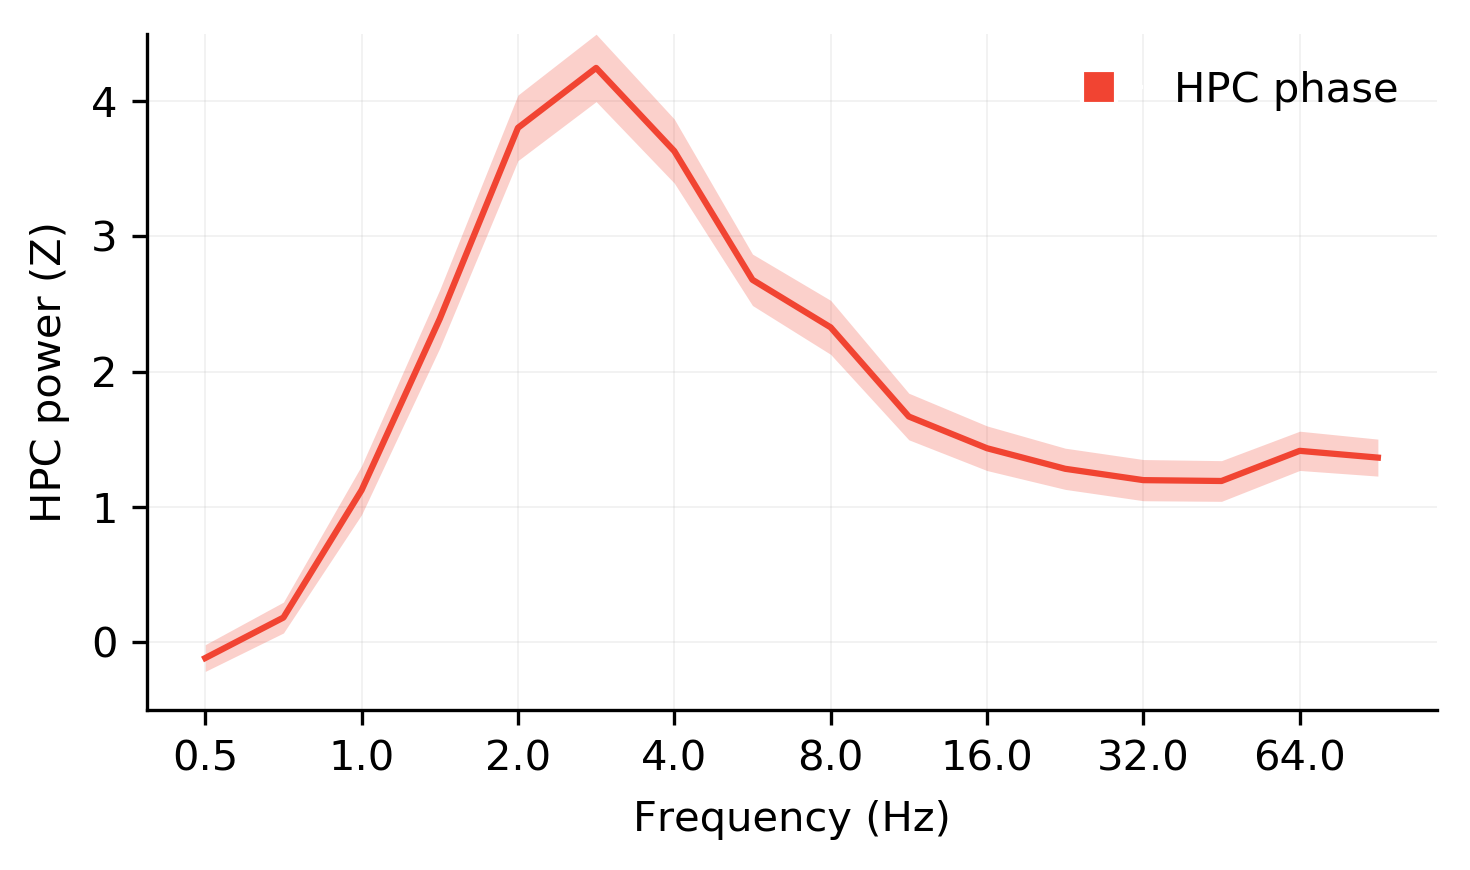

In [218]:
# Plot HPC power across frequencies for each of the top 20% spike selection
# criteria (HPC phase-locking, local phase-locking, firing rate)
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

i = 0
color_inds = [1]
for iCon, con in enumerate(['phase_locking']):
    dat = np.array([dio.open_pickle(f)[con] for f in output_files])
    means = np.nanmean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[iCon]], alpha=0.25, linewidth=0)
    ax[i].plot(x_ax, means, color=colors[color_inds[iCon]], linewidth=1.5)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels(np.round(freqs[::2], 1), fontsize=tickfontsize)
ax[i].set_ylim([-0.5, 4.5])
ax[i].set_yticks(np.arange(4.5, dtype=np.int))
ax[i].set_yticklabels(np.arange(4.5, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='HPC phase', markerfacecolor=colors[1], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_across_freqs_top20%_spike_selection_oneline.png'
                .format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

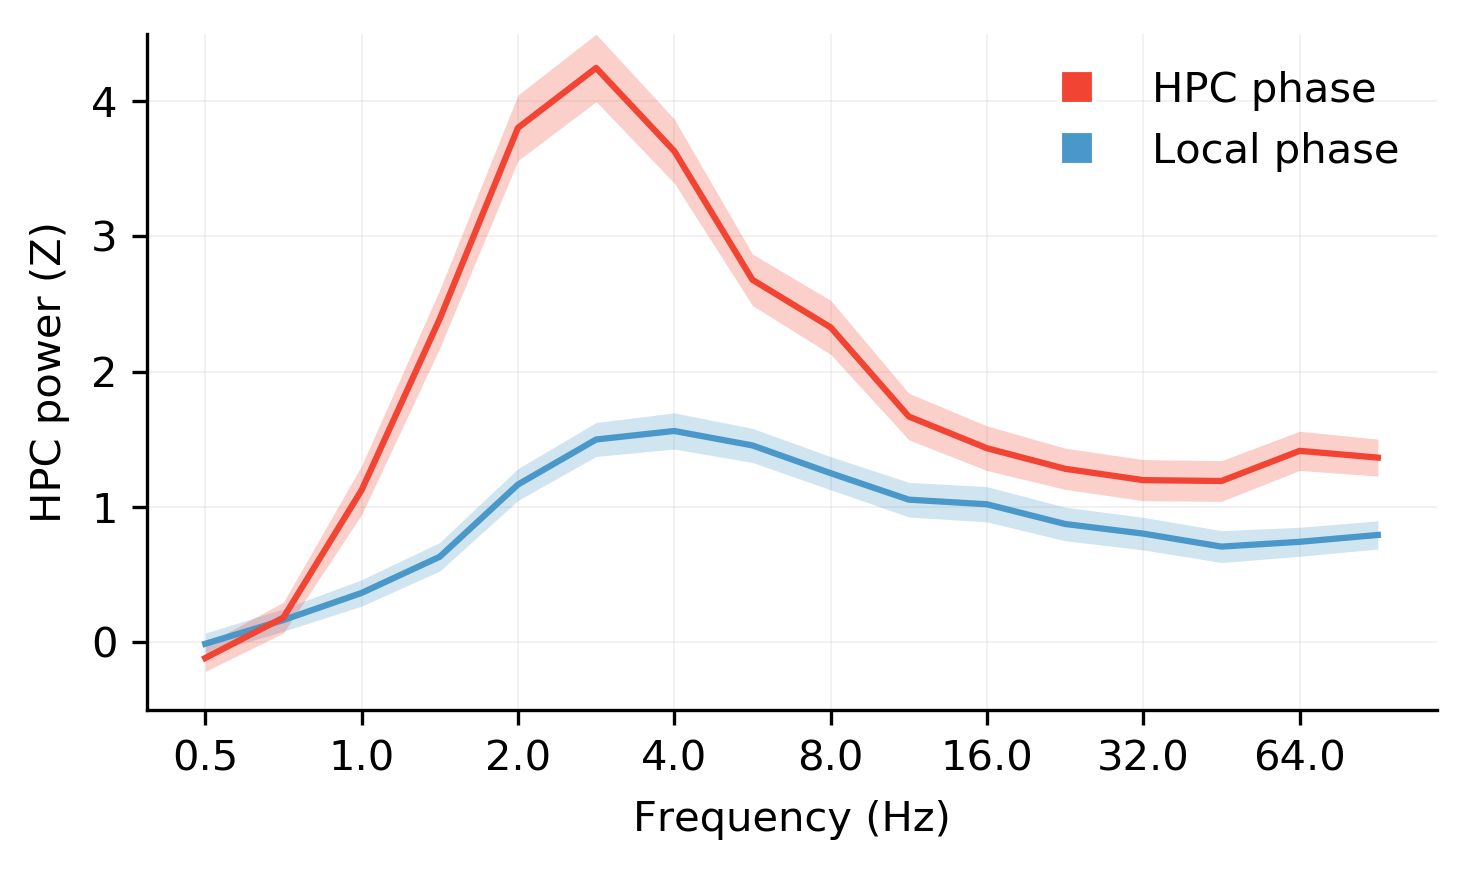

In [222]:
# Plot HPC power across frequencies for each of the top 20% spike selection
# criteria (HPC phase-locking, local phase-locking, firing rate)
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

i = 0
color_inds = [0, 1]
for iCon, con in enumerate(['local_phase_locking', 'phase_locking']):
    dat = np.array([dio.open_pickle(f)[con] for f in output_files])
    means = np.nanmean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[iCon]], alpha=0.25, linewidth=0)
    ax[i].plot(x_ax, means, color=colors[color_inds[iCon]], linewidth=1.5)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels(np.round(freqs[::2], 1), fontsize=tickfontsize)
ax[i].set_ylim([-0.5, 4.5])
ax[i].set_yticks(np.arange(4.5, dtype=np.int))
ax[i].set_yticklabels(np.arange(4.5, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='HPC phase', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Local phase', markerfacecolor=colors[0], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_across_freqs_top20%_spike_selections_twolines.png'
                .format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

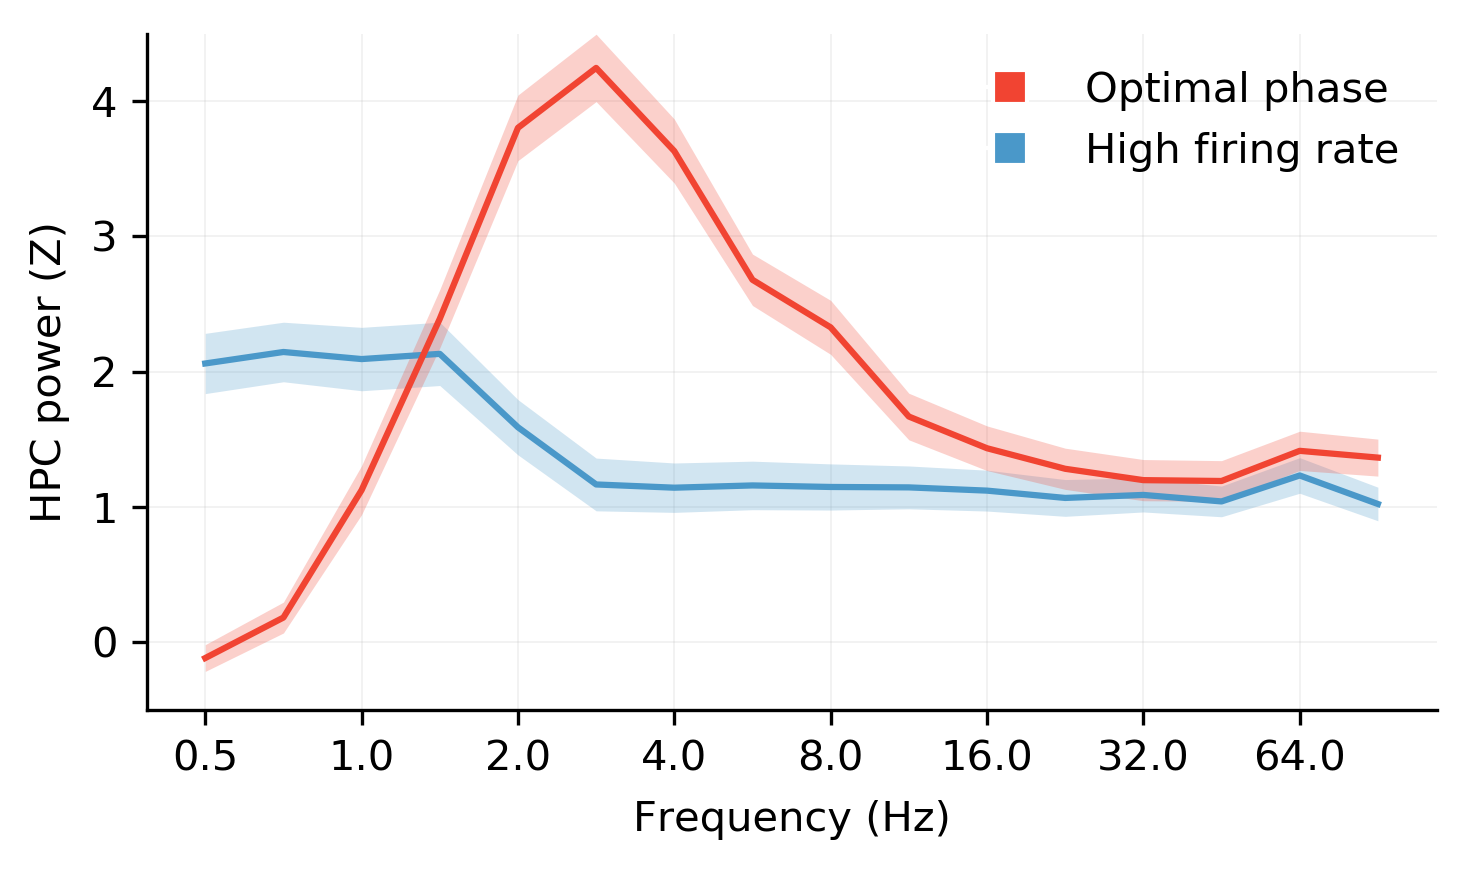

In [231]:
# Plot HPC power across frequencies for each of the top 20% spike selection
# criteria (HPC phase-locking, local phase-locking, firing rate)
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

i = 0
color_inds = [0, 1]
for iCon, con in enumerate(['firing_rate', 'phase_locking']):
    dat = np.array([dio.open_pickle(f)[con] for f in output_files])
    means = np.nanmean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[iCon]], alpha=0.25, linewidth=0)
    ax[i].plot(x_ax, means, color=colors[color_inds[iCon]], linewidth=1.5)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels(np.round(freqs[::2], 1), fontsize=tickfontsize)
ax[i].set_ylim([-0.5, 4.5])
ax[i].set_yticks(np.arange(4.5, dtype=np.int))
ax[i].set_yticklabels(np.arange(4.5, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Optimal phase', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='High firing rate', markerfacecolor=colors[0], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_across_freqs_top20%_spike_selections_twolines_fr.png'
                .format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

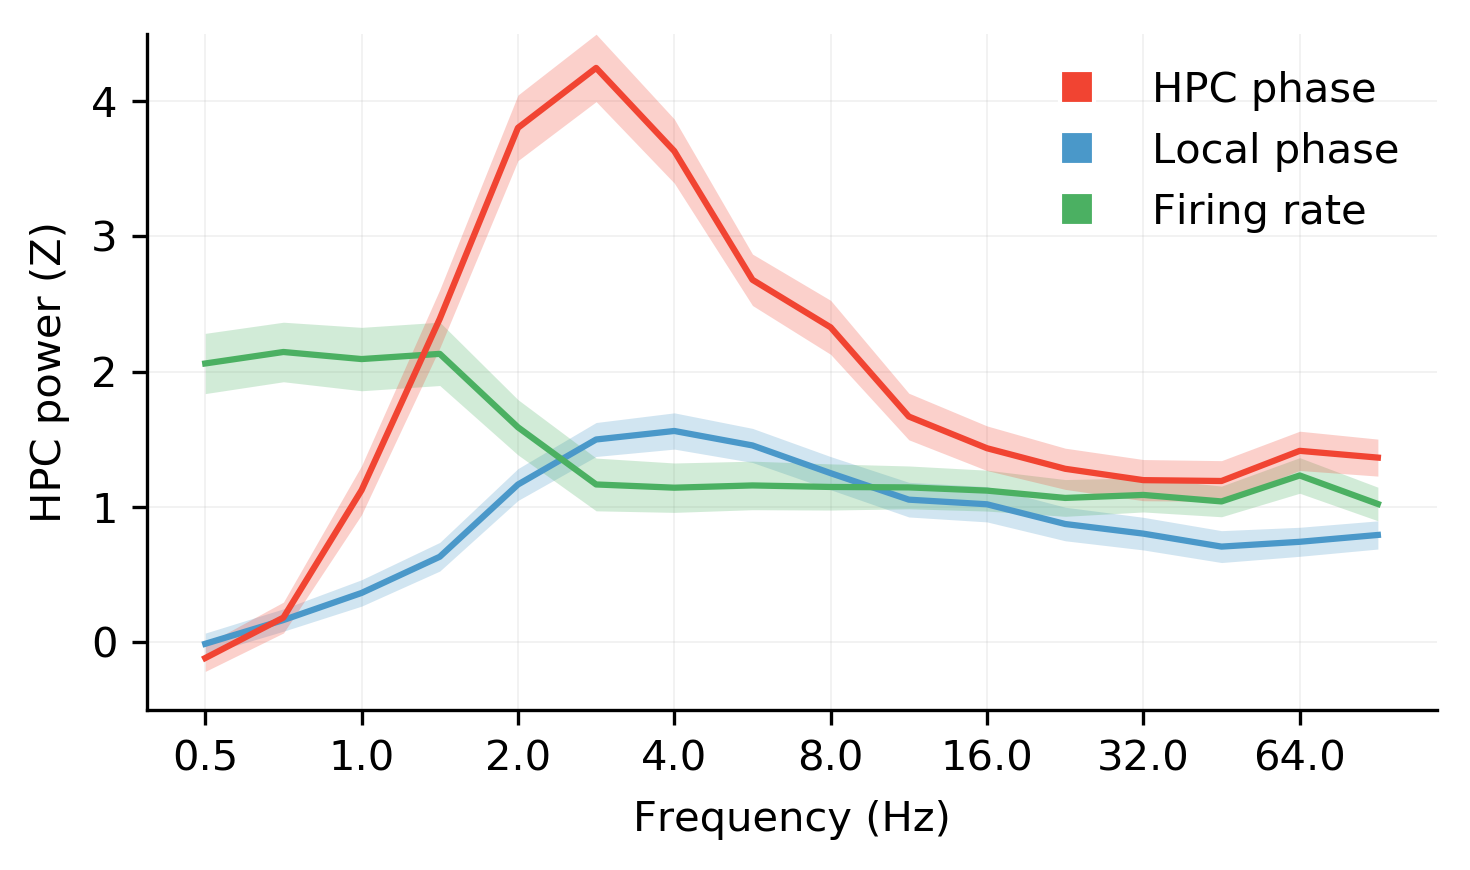

In [221]:
# Plot HPC power across frequencies for each of the top 20% spike selection
# criteria (HPC phase-locking, local phase-locking, firing rate)
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

i = 0
color_inds = [0, 2, 1]
for iCon, con in enumerate(['local_phase_locking', 'firing_rate', 'phase_locking']):
    dat = np.array([dio.open_pickle(f)[con] for f in output_files])
    means = np.nanmean(dat, axis=0)
    sems = stats.sem(dat, axis=0, nan_policy='omit')

    x_ax = np.arange(len(freqs))
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[iCon]], alpha=0.25, linewidth=0)
    ax[i].plot(x_ax, means, color=colors[color_inds[iCon]], linewidth=1.5)

ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels(np.round(freqs[::2], 1), fontsize=tickfontsize)
ax[i].set_ylim([-0.5, 4.5])
ax[i].set_yticks(np.arange(4.5, dtype=np.int))
ax[i].set_yticklabels(np.arange(4.5, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='HPC phase', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Local phase', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Firing rate', markerfacecolor=colors[2], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if True:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_across_freqs_top20%_spike_selections.png'
                .format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

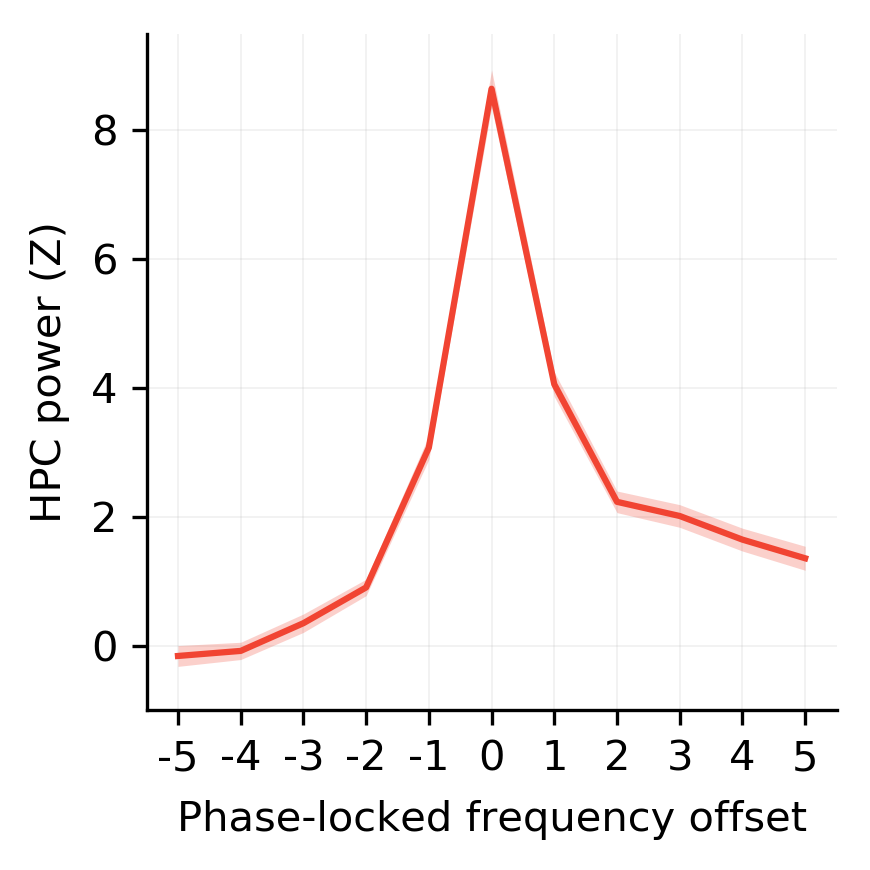

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
ax = np.ravel(ax)

i = 0
means = np.nanmean(power_near_locked_freq, axis=0)
sems = stats.sem(power_near_locked_freq, axis=0, nan_policy='omit')

x_ax = np.arange(-5, 6, dtype=np.int)
ax[i].fill_between(np.arange(len(x_ax)), means - sems, means + sems, 
                   color=colors[1], alpha=0.25, linewidth=0)
ax[i].plot(np.arange(len(x_ax)), means, color=colors[1], linewidth=1.5)
ax[i].set_xticks(range(len(x_ax)))
ax[i].set_xticklabels(x_ax, fontsize=tickfontsize)
ax[i].set_ylim([-1, 9.5])
ax[i].set_yticks(np.arange(0, 8.5, dtype=np.int)[::2])
ax[i].set_yticklabels(np.arange(0, 8.5, dtype=np.int)[::2], fontsize=tickfontsize)
ax[i].set_xlabel('Phase-locked frequency offset', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC power (Z)', fontsize=labelfontsize, labelpad=5)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_lfp_power_for_top20%_phase_locked_spikes_near_preferred_freq.png'.format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

In [ ]:
pl_df.query("(edge=='ctx-hpc') & (u)")

In [ ]:
hpc_pl_df = pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").reset_index(drop=True).copy()

In [180]:
# Gather files. 
# There should be one file for each significantly phase-locked cortex-to-HPC connection. 
# Each file contains outputs from calc_power_by_pl_fr_unit_to_region() -- Z-scored HPC
# power at each frequency for top 20% spike selections vs. a null distribution of 20% spikes

hpc_pl_df = pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").reset_index(drop=True).copy()

# Variables
target_fname = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/target_lfp',
                              'power_by_phase_locking_and_fr-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
off_target_fname = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/off_target_lfp',
                                'power_by_phase_locking_and_fr-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
pl_fname = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power',
                        'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
pl_files = []
output_files = []
missing_files = []

on_vs_off_target_power = []
missing_rows = []
for ind, row in hpc_pl_df.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    lfp_roi = row.lfp_hemroi
    iFreq = row.tl_locked_freq_z
    
    # Load on and off target power data
    try:
        target_dat = dio.open_pickle(target_fname.format(subj_sess, unit, lfp_roi))['phase_locking']
        off_target_dat = dio.open_pickle(off_target_fname.format(subj_sess, unit, lfp_roi))['phase_locking']
    except:
        missing_rows.append([subj_sess, unit, lfp_roi])
        continue
        
    # Append power at the HPC preferred frequency
    on_vs_off_target_power.append([target_dat[iFreq], off_target_dat[iFreq]])
    
on_vs_off_target_power = pd.DataFrame(on_vs_off_target_power, columns=['on_target', 'off_target'])
on_vs_off_target_power['on_minus_off'] = on_vs_off_target_power['on_target'] - on_vs_off_target_power['off_target']
    
print(on_vs_off_target_power.shape)
print('{} missing files'.format(len(missing_rows)))

(587, 3)
0 missing files


In [181]:
stats.ttest_rel(on_vs_off_target_power.on_target, on_vs_off_target_power.off_target)

Ttest_relResult(statistic=28.347168719632545, pvalue=5.847482049460765e-112)

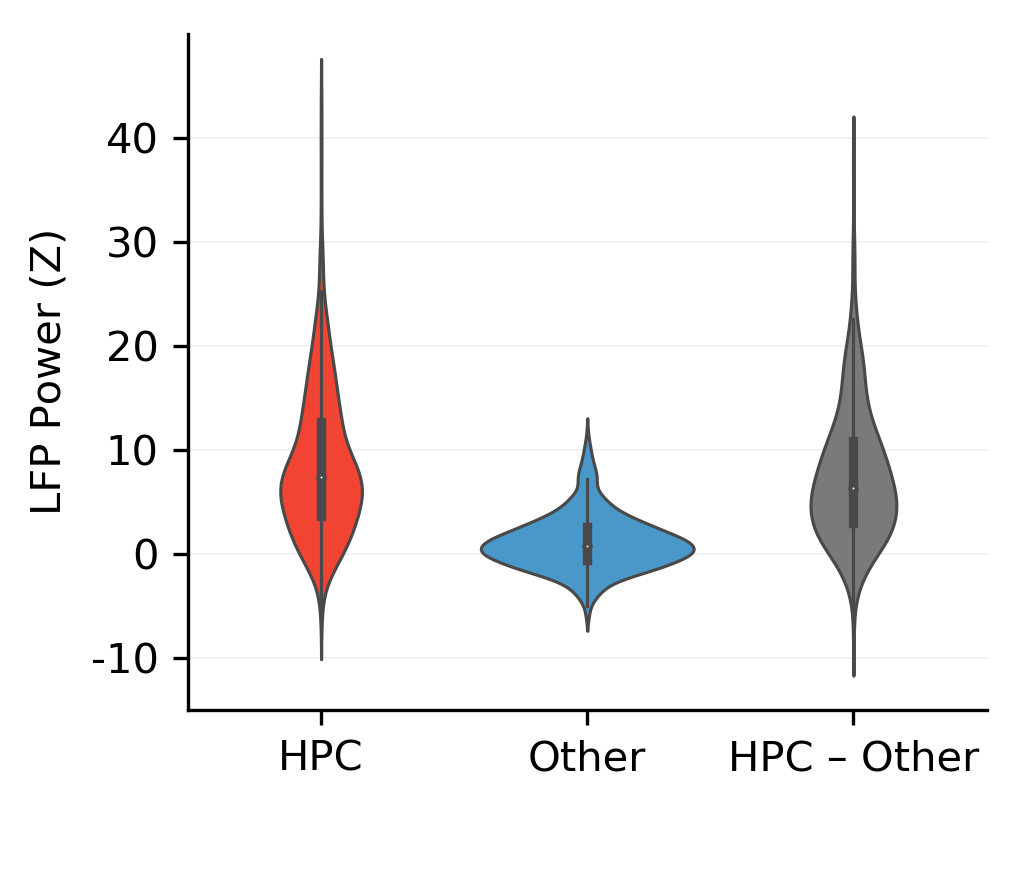

In [224]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), dpi=300)
ax = np.ravel(ax)

i = 0
sns.violinplot(x='lfp_type', y='value', linewidth=0.75,
               data=on_vs_off_target_power.stack().reset_index().rename(columns={'level_1': 'lfp_type', 0: 'value'}).drop(columns=['level_0']),
               palette=[colors[1], colors[0], colors[5]], saturation=100, alpha=0.5, ax=ax[i])
#ax[i].set_xticks(range(len(x_ax)))
ax[i].set_xticklabels(['HPC', 'Other', 'HPC – Other'], fontsize=tickfontsize)
ax[i].set_ylim([-15, 50])
ax[i].set_yticks(np.arange(-10, 50, step=10, dtype=np.int))
ax[i].set_yticklabels(np.arange(-10, 50, step=10, dtype=np.int), fontsize=tickfontsize)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('LFP Power (Z)', fontsize=labelfontsize, labelpad=5)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_vs_off-target_lfp_power_for_top20%_phase_locked_spikes_at_hpc_preferred_freq.png'.format(info.subj_sess, info.unit, info.lfp_hemroi), 
                format='png', dpi=300, bbox_inches='tight')

## Other

In [84]:
# Get power at the locked frequency for top 20% of HPC-locked spikes relative to HPC power,
# for the phase-locked frequency and for adjacent frequencies
start_time = time()

t0 = 4000
power_time_steps = np.linspace(-2000, 2000, num=8001)

# What is the time (in ms) at which maxmimum power is observed at the locked frequency, relative to spike time?
power_time_shifts = OrderedDict([('phase_locking', []), ('local_phase_locking', [])])

# How do the times of maximum power and maximum phase-locking strength compare?
pl_power_time = []

# What is the power at spike time for the locked frequency relative to neighboring frequencies?
power_near_locked_freq = OrderedDict([('phase_locking', []), ('local_phase_locking', [])])

for f in output_files:
    unit_dat = dio.open_pickle(f)
    
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    info_f = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power',
                          'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                          .format(subj_sess, unit, lfp_roi))
    if os.path.exists(info_f):
        info = dio.open_pickle(info_f)
    else:
        continue
    for con in power_cons.keys():
        power_time_shift = power_time_steps[unit_dat[con][info.tl_locked_freq_z, :].argmax()]
        power_time_shifts[con].append(power_time_shift)
        
        if con == 'phase_locking':
            pl_power_time.append([-info.tl_locked_time_z, power_time_shift])
        
        power_near_locked_freq_ = np.nan * np.ones(11)
        for i, iFreq_step in enumerate(range(-5, 6)):
            iFreq = info.tl_locked_freq_z + iFreq_step
            if (iFreq >= 0) and (iFreq < len(freqs)):
                power_near_locked_freq_[i] = unit_dat[con][iFreq, t0]
        power_near_locked_freq[con].append(power_near_locked_freq_)
        
pl_power_time = np.array(pl_power_time)
            
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 0.70 secs


In [102]:
print(stats.describe(power_time_shifts['phase_locking']))
print(stats.ttest_1samp(power_time_shifts['phase_locking'], 0))
print(stats.describe(power_time_shifts['local_phase_locking']))
print(stats.ttest_1samp(power_time_shifts['local_phase_locking'], 0))

DescribeResult(nobs=443, minmax=(-2000.0, 2000.0), mean=16.59367945823928, variance=212774.12638529972, skewness=-0.18932847749260506, kurtosis=8.472065003140868)
Ttest_1sampResult(statistic=0.7571556223668572, pvalue=0.4493600606307)
DescribeResult(nobs=443, minmax=(-2000.0, 2000.0), mean=-65.2020316027088, variance=1090274.4720999356, skewness=-0.03145618722278175, kurtosis=-0.49692579966525985)
Ttest_1sampResult(statistic=-1.3143016989024783, pvalue=0.18942632142985316)


In [106]:
#stats.sem(np.array(power_near_locked_freq[con])[:, 0], nan_policy='omit')
#stats.sem([1, 2, 3, 4, 5, np.nan, np.nan], nan_policy='omit'), np.nanstd([1, 2, 3, 4, 5, np.nan, np.nan])
stats.sem(power_near_locked_freq['phase_locking'], axis=0, nan_policy='omit')

(11,)

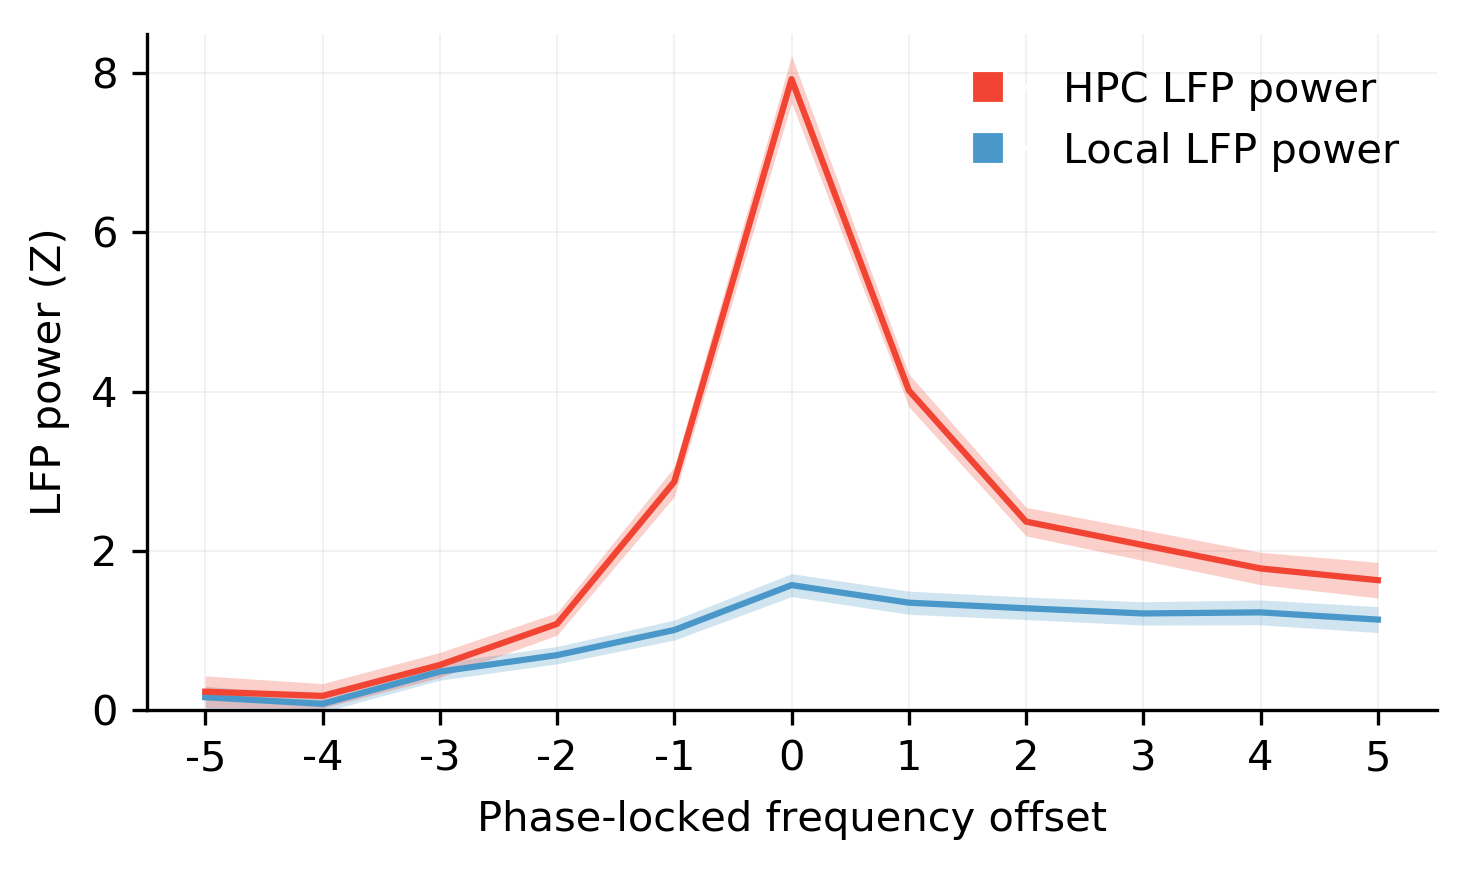

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 10
figfontsize = 14

i = 0
means = {'hpc': np.nanmean(power_near_locked_freq['phase_locking'], axis=0),
         'local': np.nanmean(power_near_locked_freq['local_phase_locking'], axis=0)}
sems = {'hpc': stats.sem(power_near_locked_freq['phase_locking'], axis=0, nan_policy='omit'),
        'local': stats.sem(power_near_locked_freq['local_phase_locking'], axis=0, nan_policy='omit')}

x_ax = np.arange(-5, 6, dtype=np.int)
ax[i].fill_between(np.arange(len(x_ax)), means['local'] - sems['local'], means['local'] + sems['local'], 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[i].fill_between(np.arange(len(x_ax)), means['hpc'] - sems['hpc'], means['hpc'] + sems['hpc'], 
                   color=colors[1], alpha=0.25, linewidth=0)
ax[i].plot(np.arange(len(x_ax)), means['local'], color=colors[0], linewidth=1.5)
ax[i].plot(np.arange(len(x_ax)), means['hpc'], color=colors[1], linewidth=1.5)
ax[i].set_xticks(range(len(x_ax)))
ax[i].set_xticklabels(x_ax, fontsize=tickfontsize)
ax[i].set_ylim([0, 8.5])
ax[i].set_yticks(np.arange(8.5, dtype=np.int)[::2])
ax[i].set_yticklabels(np.arange(8.5, dtype=np.int)[::2], fontsize=tickfontsize)
ax[i].set_xlabel('Phase-locked frequency offset', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('LFP power (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='HPC LFP power', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Local LFP power', markerfacecolor=colors[0], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/lfp_power_around_maximally_phase_locked_spikes.png'.format(info.subj_sess, info.unit, info.lfp_hemroi), 
            format='png', dpi=300, bbox_inches='tight')

In [715]:
start_time = time()

power_cons = OrderedDict([('phase_locking', []),
                          ('local_phase_locking', [])])
for f in output_files:
    unit_dat = dio.open_pickle(f)
    
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    info_f = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power',
                          'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                          .format(subj_sess, unit, lfp_roi))
    if os.path.exists(info_f):
        info = dio.open_pickle(info_f)
    else:
        continue
    if True: #(info.locked_freq_ind_z >= 4) & (info.locked_freq_ind_z <= 9):
        for con in power_cons.keys():
            power_cons[con].append(unit_dat[con])
    
print(np.array(power_cons[con]).shape)
for con in power_cons.keys():
    power_cons[con] = np.mean(power_cons[con], axis=0) # freq x time; mean across units
            
print('Done in {:.2f} secs'.format(time() - start_time))

(443, 16, 8001)
Done in 10.32 secs


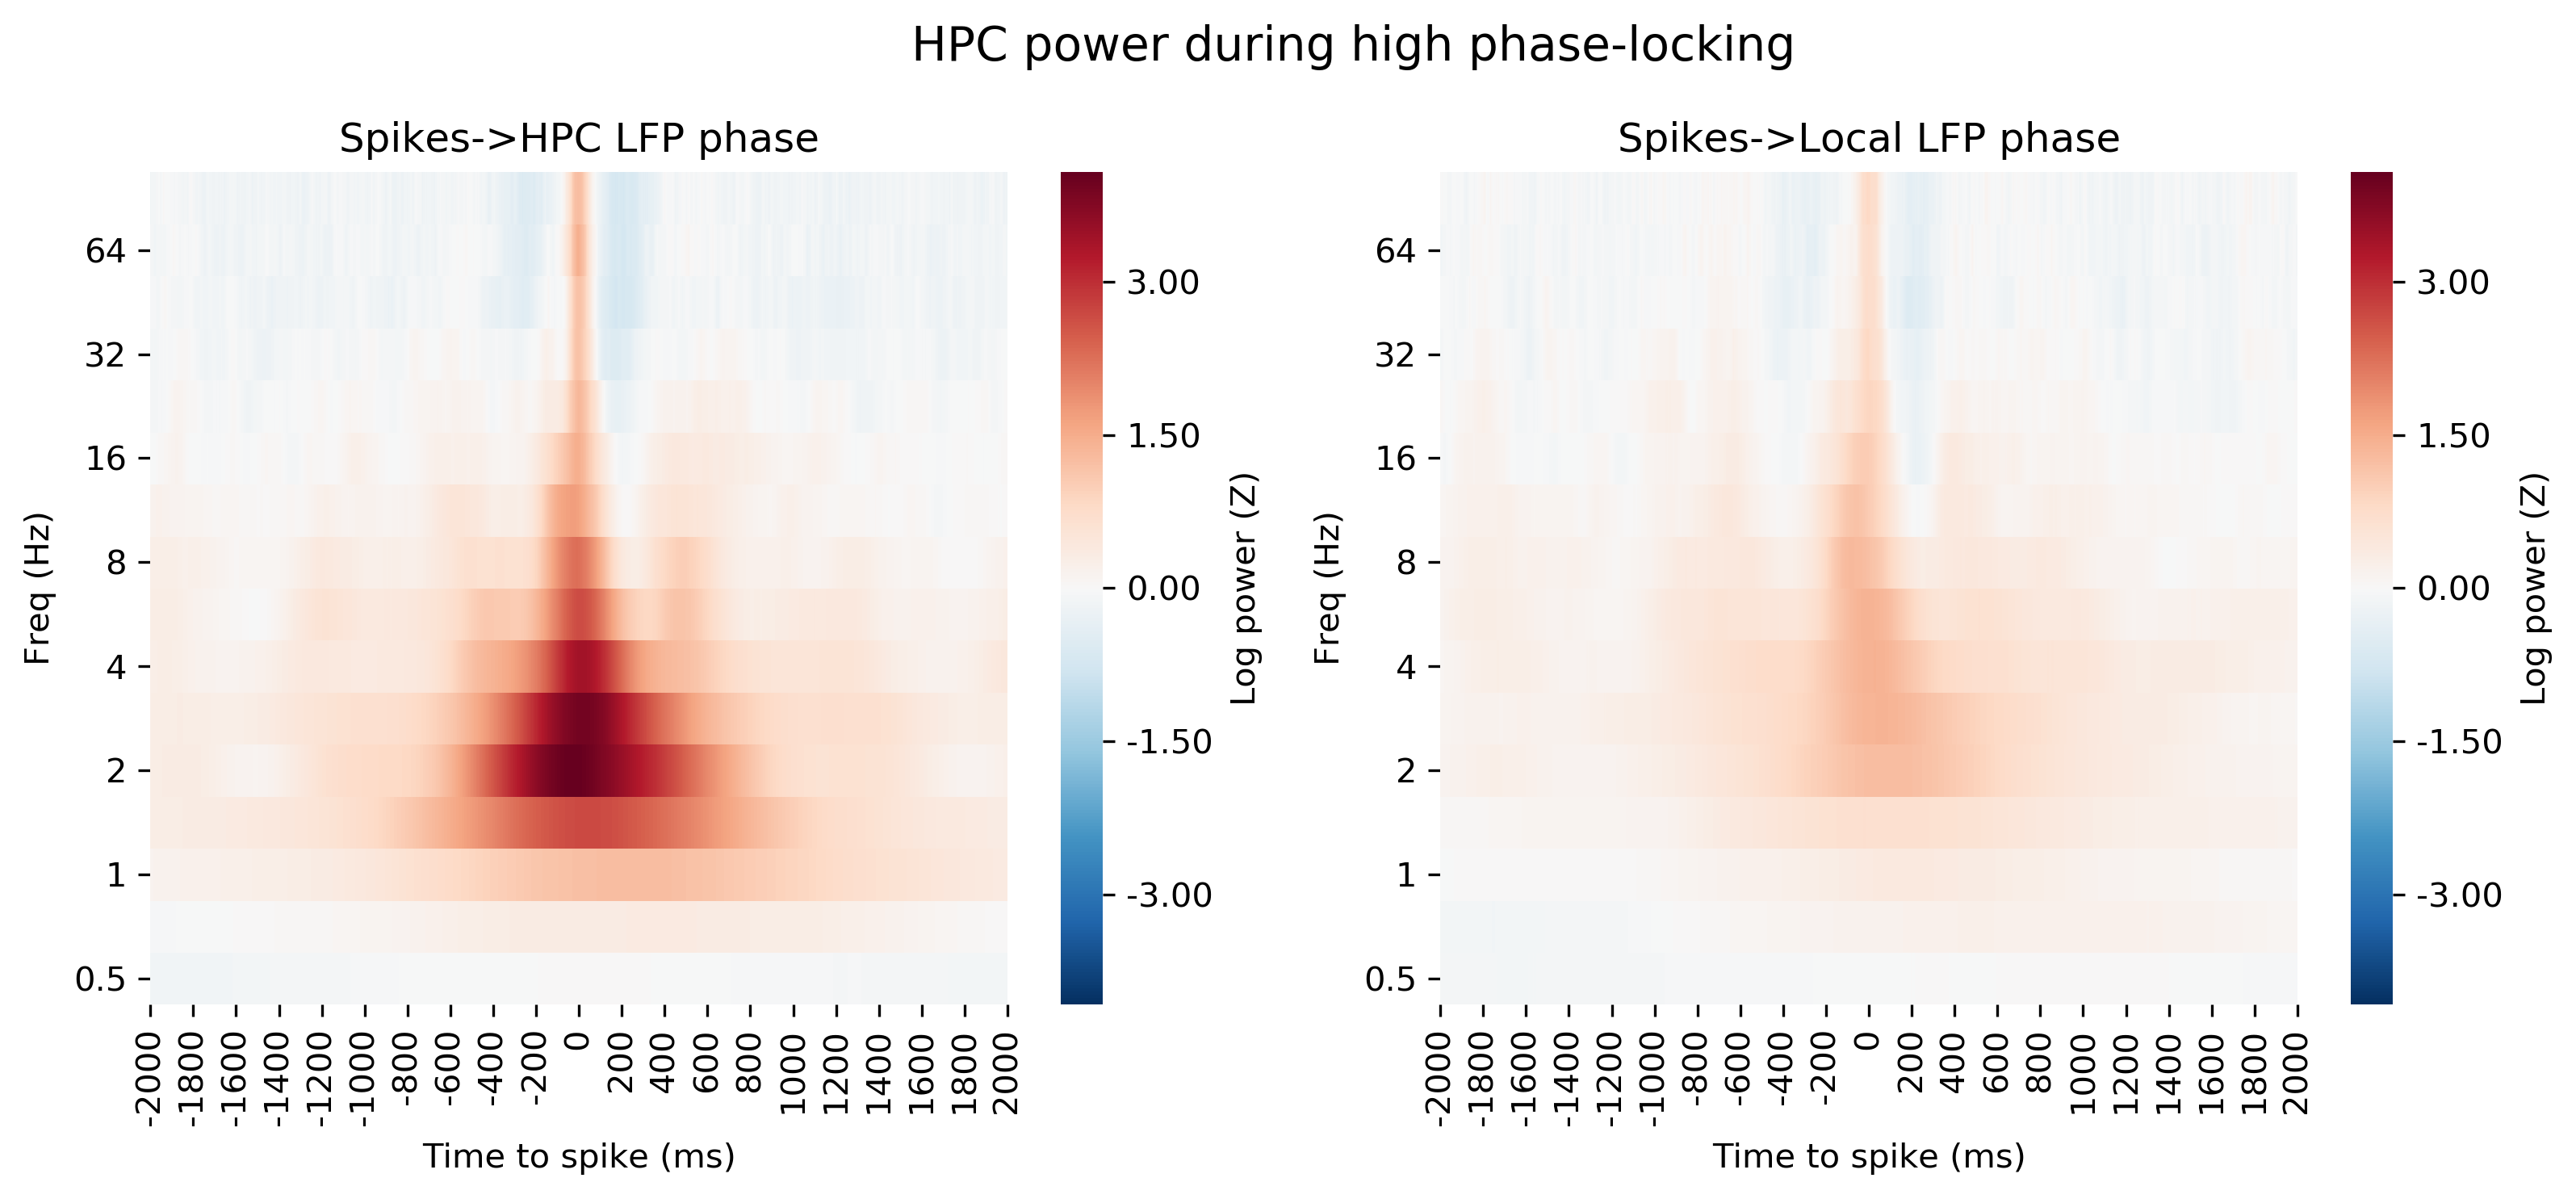

In [716]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
ax = np.ravel(ax)

icpt = 0

vmax = np.max(np.vstack((np.abs(power_cons['phase_locking']), np.abs(power_cons['local_phase_locking']))))
vmin = -vmax

for i, con in enumerate(['phase_locking', 'local_phase_locking']):
    ax[i+icpt] = sns.heatmap(power_cons[con], vmin=vmin, vmax=vmax,
                             cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
    #ax[i+icpt].axvline(x=4000, color='k', linewidth=0.5, alpha=1)
    ax[i+icpt].set_xticks(np.arange(0, 8001)[::400])
    ax[i+icpt].set_xticklabels(np.linspace(-2000, 2000, num=8001)[::400].astype(int), fontsize=tickfs)
    ax[i+icpt].set_yticks(np.arange(len(freqs))[::2] + 0.5)
    ax[i+icpt].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfs)
    ax[i+icpt].invert_yaxis()
    ax[i+icpt].set_xlabel('Time to spike (ms)', fontsize=labfs)
    ax[i+icpt].set_ylabel('Freq (Hz)', fontsize=labfs)
    cbar = ax[i+icpt].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfs)
    cbar.ax.ticklabel_format()
    cbar.set_label('Log power (Z)', fontsize=labfs)
    
    if i == 0:
        ax[i+icpt].set_title('Spikes->HPC LFP phase', fontsize=figfs, y=1.02)
    else:
        ax[i+icpt].set_title('Spikes->Local LFP phase', fontsize=figfs, y=1.02)
        
fig.suptitle('HPC power during high phase-locking', fontsize=figfs+2, y=0.98)
fig.tight_layout(w_pad=1.1, h_pad=1.05, rect=(0.03, 0, 0.93, 0.93))

In [650]:
max_powers = []
for f in output_files:
    unit_dat = dio.open_pickle(f)
    max_freq, max_time = np.unravel_index(unit_dat['phase_locking'].argmax(), unit_dat['phase_locking'].shape)
    max_powers.append([max_freq, max_time])
max_powers = np.array(max_powers)

Text(0.5, 0, 'Time to spike (ms)')

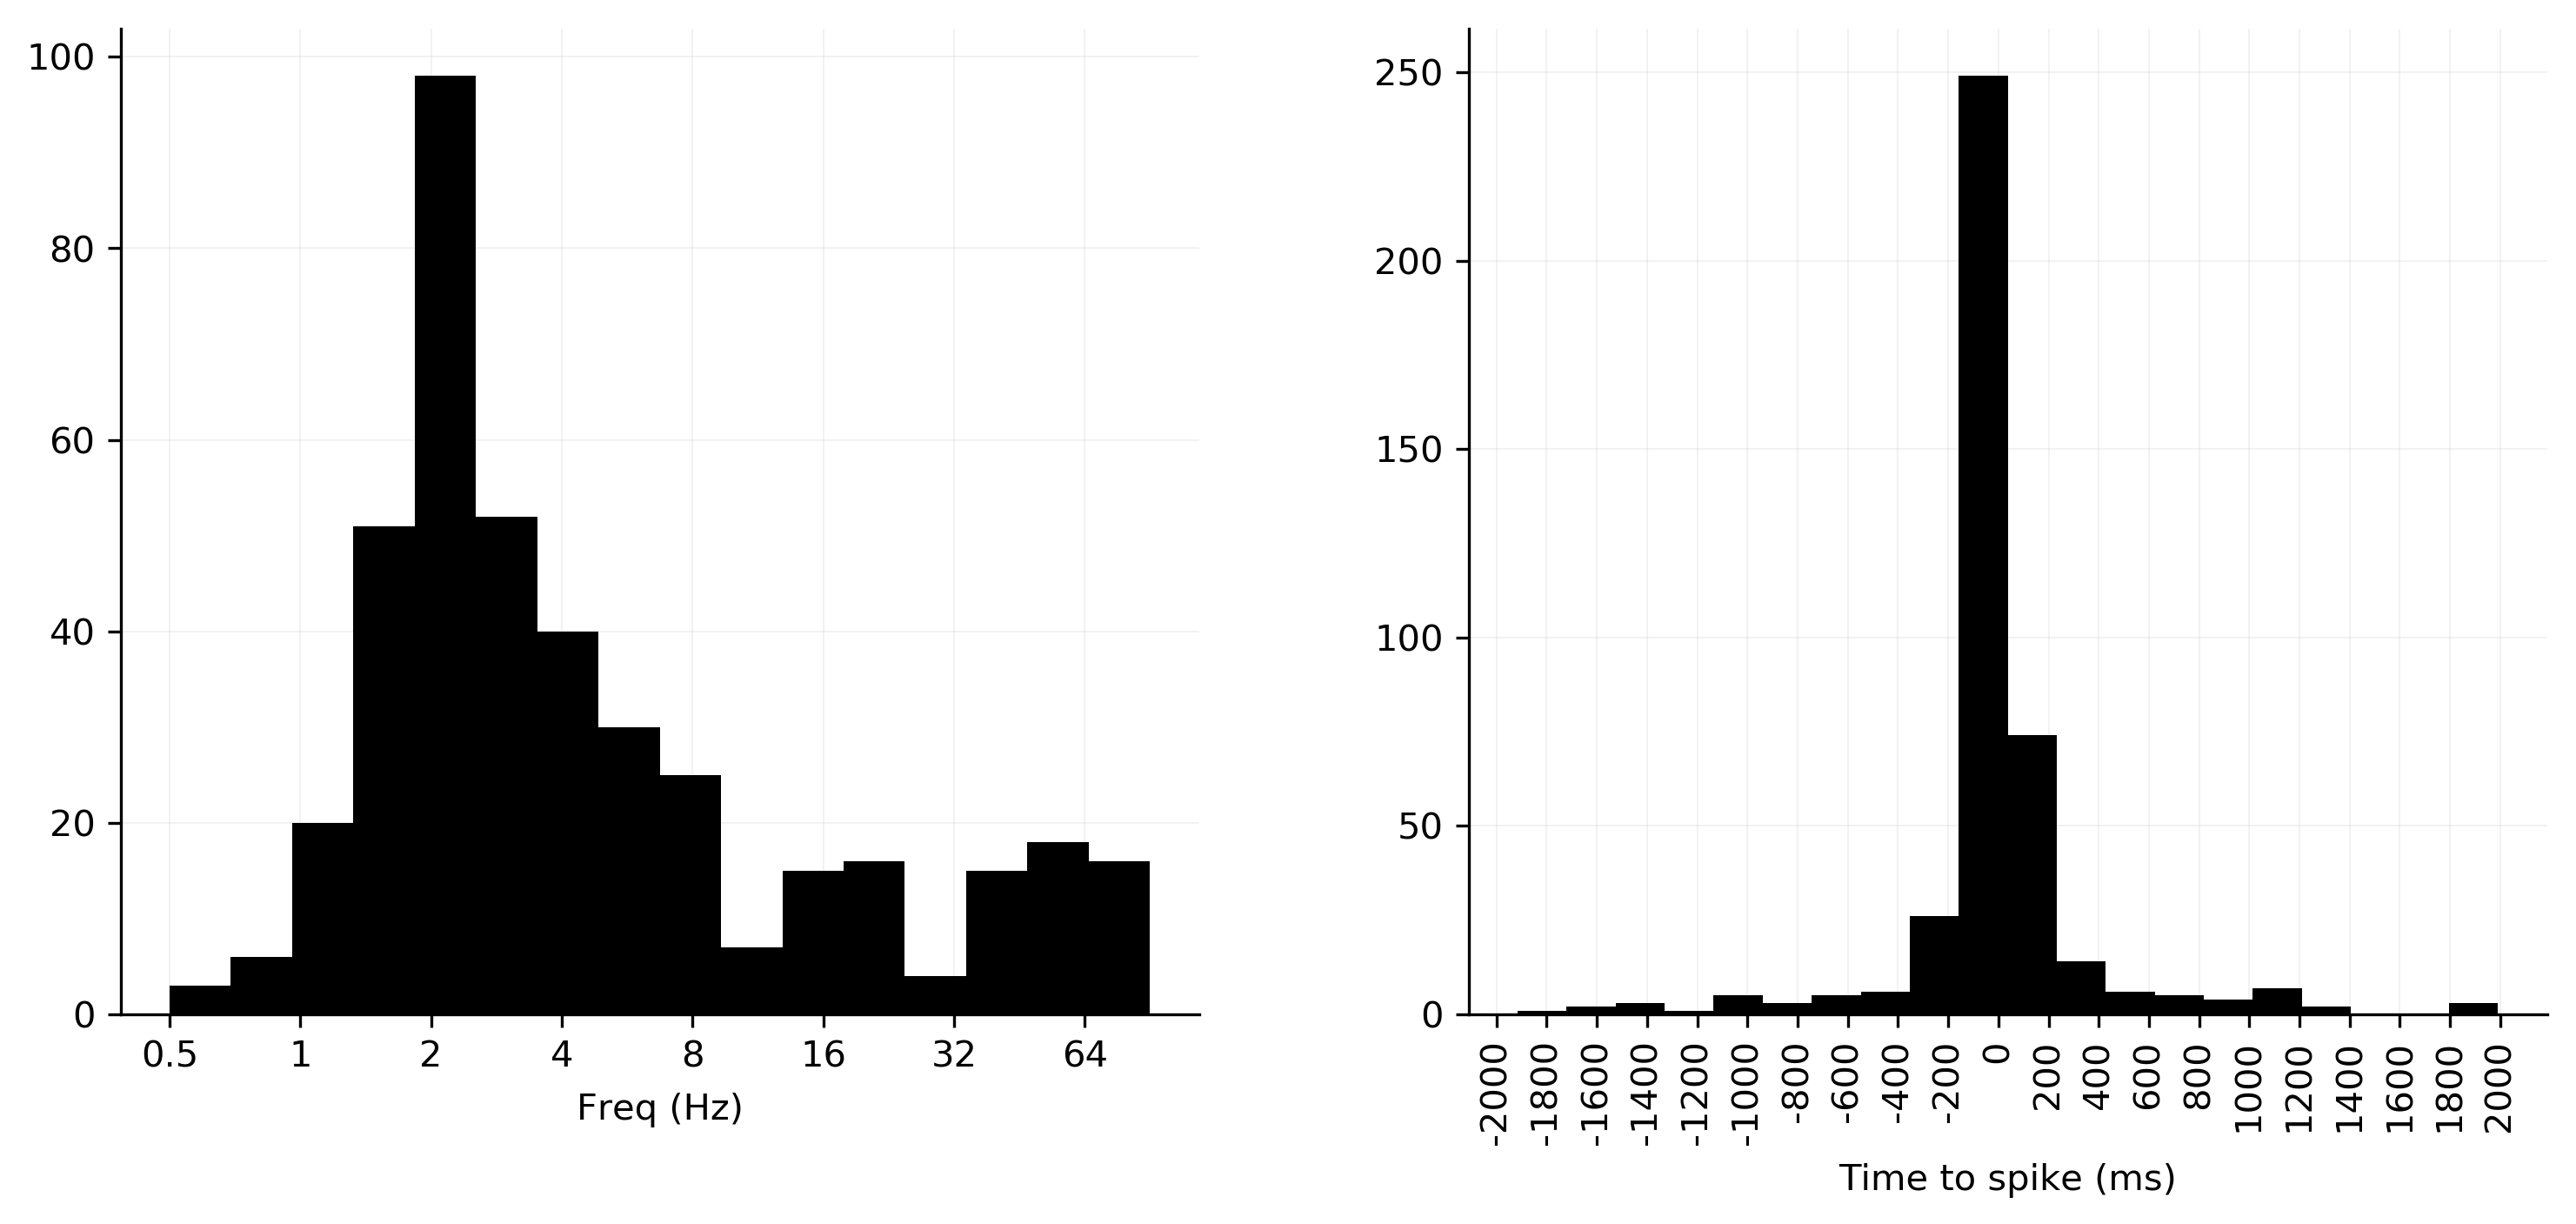

In [651]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i].hist(max_powers[:, 0], 16, color='k')
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), fontsize=tickfs)
ax[i].set_xlabel('Freq (Hz)', fontsize=labfs)

i = 1
ax[i].hist(max_powers[:, 1], 20, color='k')
ax[i].set_xticks(np.arange(0, 8001)[::400])
ax[i].set_xticklabels(np.linspace(-2000, 2000, num=8001)[::400].astype(int), rotation=90, fontsize=tickfs)
ax[i].set_xlabel('Time to spike (ms)', fontsize=labfs)

In [657]:
pd.Series(max_powers[:, 1]).describe(), np.median(max_powers[:, 1])

(count     416.000000
 mean     4022.524038
 std       781.024952
 min       168.000000
 25%      3935.000000
 50%      4010.500000
 75%      4093.000000
 max      7982.000000
 dtype: float64, 4010.5)

In [ ]:
max_powers = []
for f in output_files:
    unit_dat = dio.open_pickle(f)
    max_freq, max_time = np.unravel_index(unit_dat['phase_locking'].argmax(), unit_dat['phase_locking'].shape)
    max_powers.append([max_freq, max_time])
max_powers = np.array(max_powers)

In [668]:
freqs[4:9]

array([2.        , 2.82842712, 4.        , 5.65685425, 8.        ])

In [684]:
power_times = []
power_time_rows = []
for f in output_files:
    unit_dat = dio.open_pickle(f)
    subj_sess = os.path.basename(f).split('-')[1]
    unit = os.path.basename(f).split('-')[2][5:]
    lfp_roi = os.path.basename(f).split('-')[3][4:]
    info_f = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power',
                          'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                          .format(subj_sess, unit, lfp_roi))
    if os.path.exists(info_f):
        info = dio.open_pickle(info_f)
    else:
        continue
    info['pl_power'] = unit_dat['phase_locking']
    #if (info.locked_freq_ind_z >= 4) & (info.locked_freq_ind_z <= 9):
    power_times.append(power_time_steps[info.pl_power[info.locked_freq_ind_z, :].argmax()])
    power_time_rows.append(info.pl_power[info.locked_freq_ind_z, :])

power_times = np.array(power_times)
power_time_rows = np.array(power_time_rows)

xsort = power_times.argsort()
power_time_rows = power_time_rows[xsort, :]
power_times.shape, power_time_rows.shape

((436,), (436, 8001))

In [687]:
np.expand_dims(np.max(power_time_rows, axis=1), axis=1).shape

(436, 1)

In [690]:
np.min(power_time_rows / np.expand_dims(np.max(power_time_rows, axis=1), axis=1))

-5.9880123

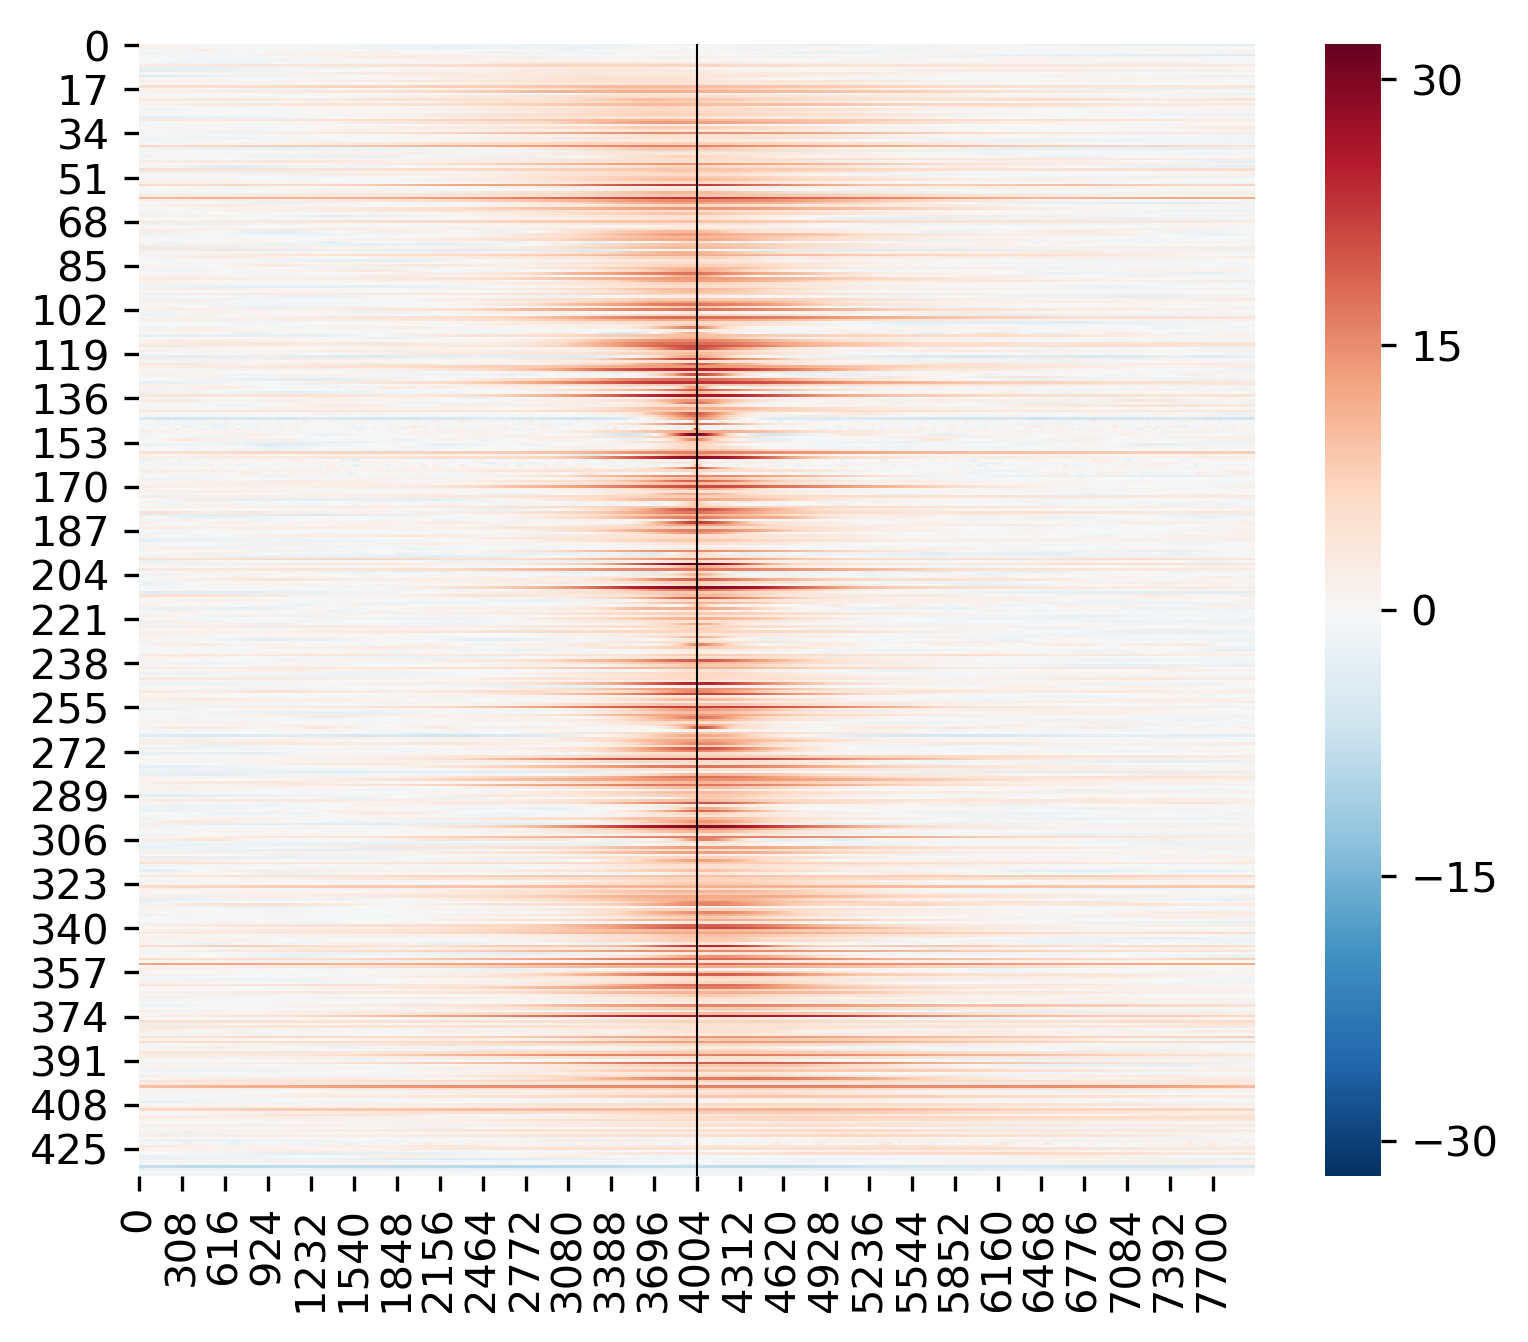

In [693]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=300)
ax = np.ravel(ax)

i = 0
sns.heatmap(power_time_rows, vmin=-32, vmax=32, cmap='RdBu_r', ax=ax[i])
ax[i].axvline(x=4000, color='k', linewidth=0.5, alpha=1)

In [678]:
stats.ttest_1samp(power_times, 0)

Ttest_1sampResult(statistic=1.2735110451490572, pvalue=0.20387808054637474)

In [675]:
np.mean(power_times), np.median(power_times)

(16.108771929824563, 9.0)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   4.,   2.,
          5.,  13.,  82., 108.,  35.,  12.,   5.,   5.,   1.,   2.,   1.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-1.765000e+03, -1.727425e+03, -1.689850e+03, -1.652275e+03,
        -1.614700e+03, -1.577125e+03, -1.539550e+03, -1.501975e+03,
        -1.464400e+03, -1.426825e+03, -1.389250e+03, -1.351675e+03,
        -1.314100e+03, -1.276525e+03, -1.238950e+03, -1.201375e+03,
        -1.163800e+03, -1.126225e+03, -1.08865

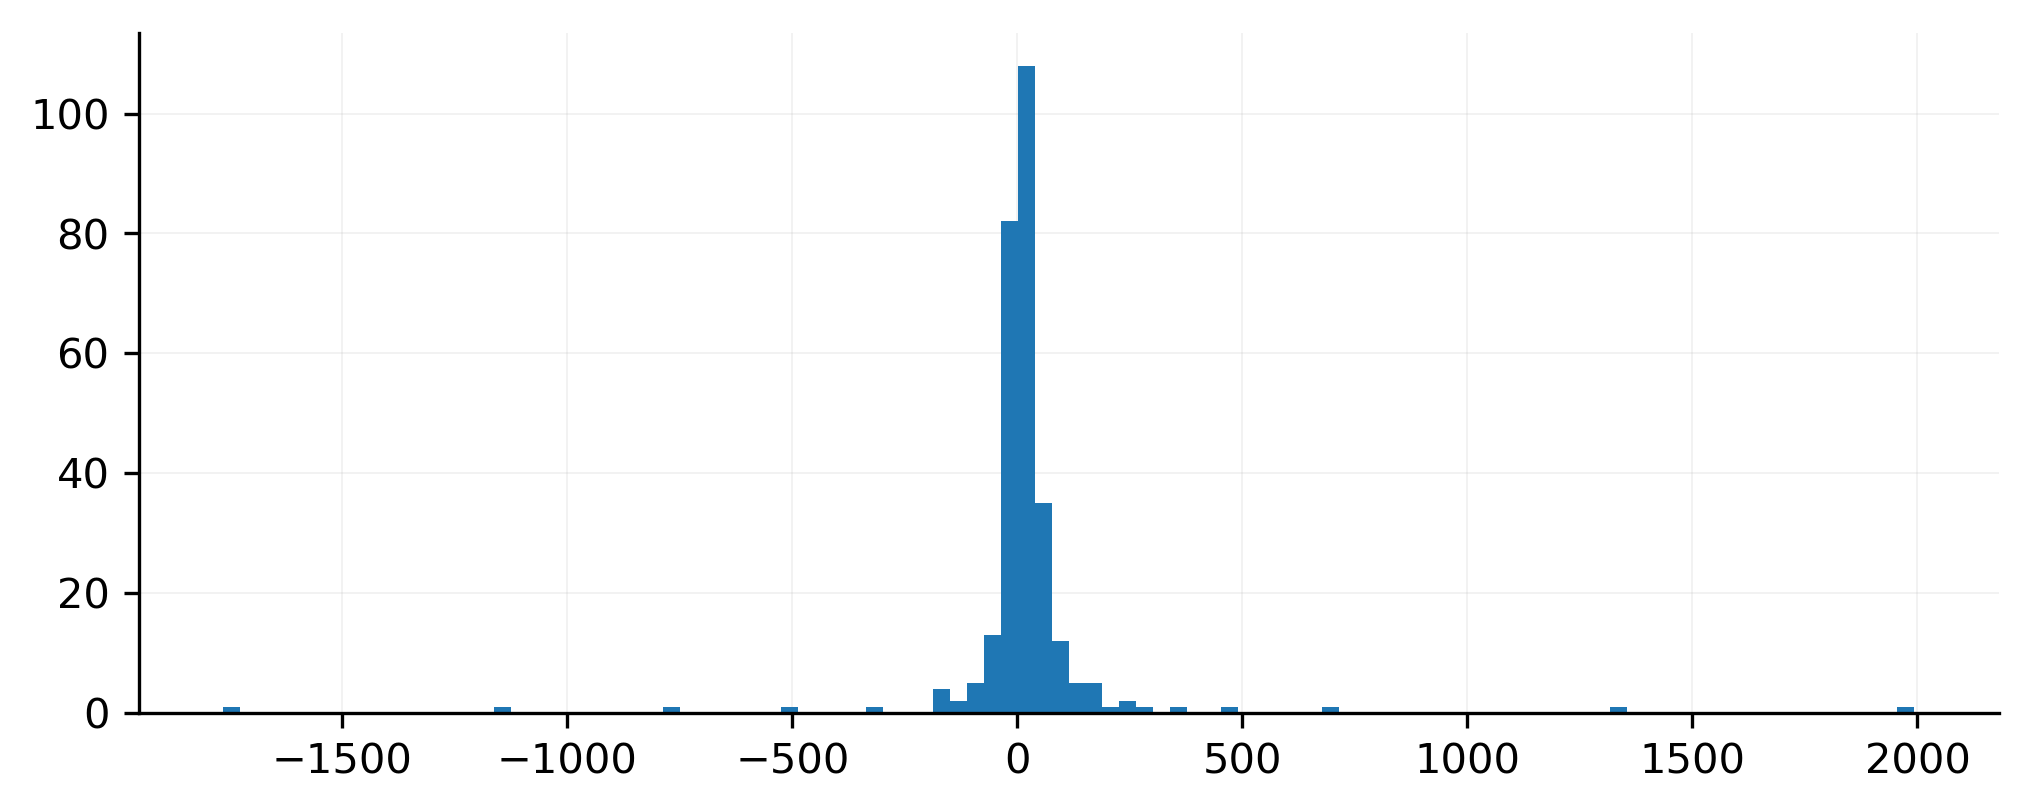

In [676]:
plt.hist(power_times, 100)

## Power across spikes

In [718]:
# Gather output files.
input_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/mean_power_across_spikes/*.pkl'))
pl_fname = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power',
                        'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
pl_files = []
output_files = {'sig': [], 'ns': []}
missing_files = []
for f in input_files:
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    if os.path.exists(pl_fname.format(subj_sess, unit, lfp_roi)):
        info = dio.open_pickle(pl_fname.format(subj_sess, unit, lfp_roi))
        if info.sig_z_fdr:
            output_files['sig'].append(f)
        else:
            output_files['ns'].append(f)
    else:
        missing_files.append(pl_fname.format(subj_sess, unit, lfp_roi))

print(len(output_files['sig']), len(output_files['ns']))
print('{} missing files'.format(len(missing_files)))

470 1840
0 missing files


In [719]:
start_time = time()

unit_powers = OrderedDict([('sig', []),
                           ('ns', [])])
for pl_stat in ['sig', 'ns']:
    for f in output_files[pl_stat]:
        unit_dat = dio.open_pickle(f)
        fsplit = os.path.basename(f).split('-')
        subj_sess = fsplit[1]
        unit = int(fsplit[2][5:])
        lfp_roi = fsplit[3][4:]
        info_f = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power',
                              'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                              .format(subj_sess, unit, lfp_roi))
        if os.path.exists(info_f):
            info = dio.open_pickle(info_f)
        else:
            continue
        unit_powers[pl_stat].append(unit_dat)
    unit_powers[pl_stat] = np.array(unit_powers[pl_stat])
    print(unit_powers[pl_stat].shape)
            
tvals, pvals = stats.ttest_ind(unit_powers['sig'], unit_powers['ns'], axis=0, equal_var=False)
unit_powers['tvals'] = tvals
unit_powers['pvals'] = pvals
for pl_stat in ['sig', 'ns']:
    unit_powers[pl_stat] = np.mean(unit_powers[pl_stat], axis=0) # freq x time; mean over units
            
print('Done in {:.2f} secs'.format(time() - start_time))

(470, 16, 8001)
(1840, 16, 8001)
Done in 7.21 secs


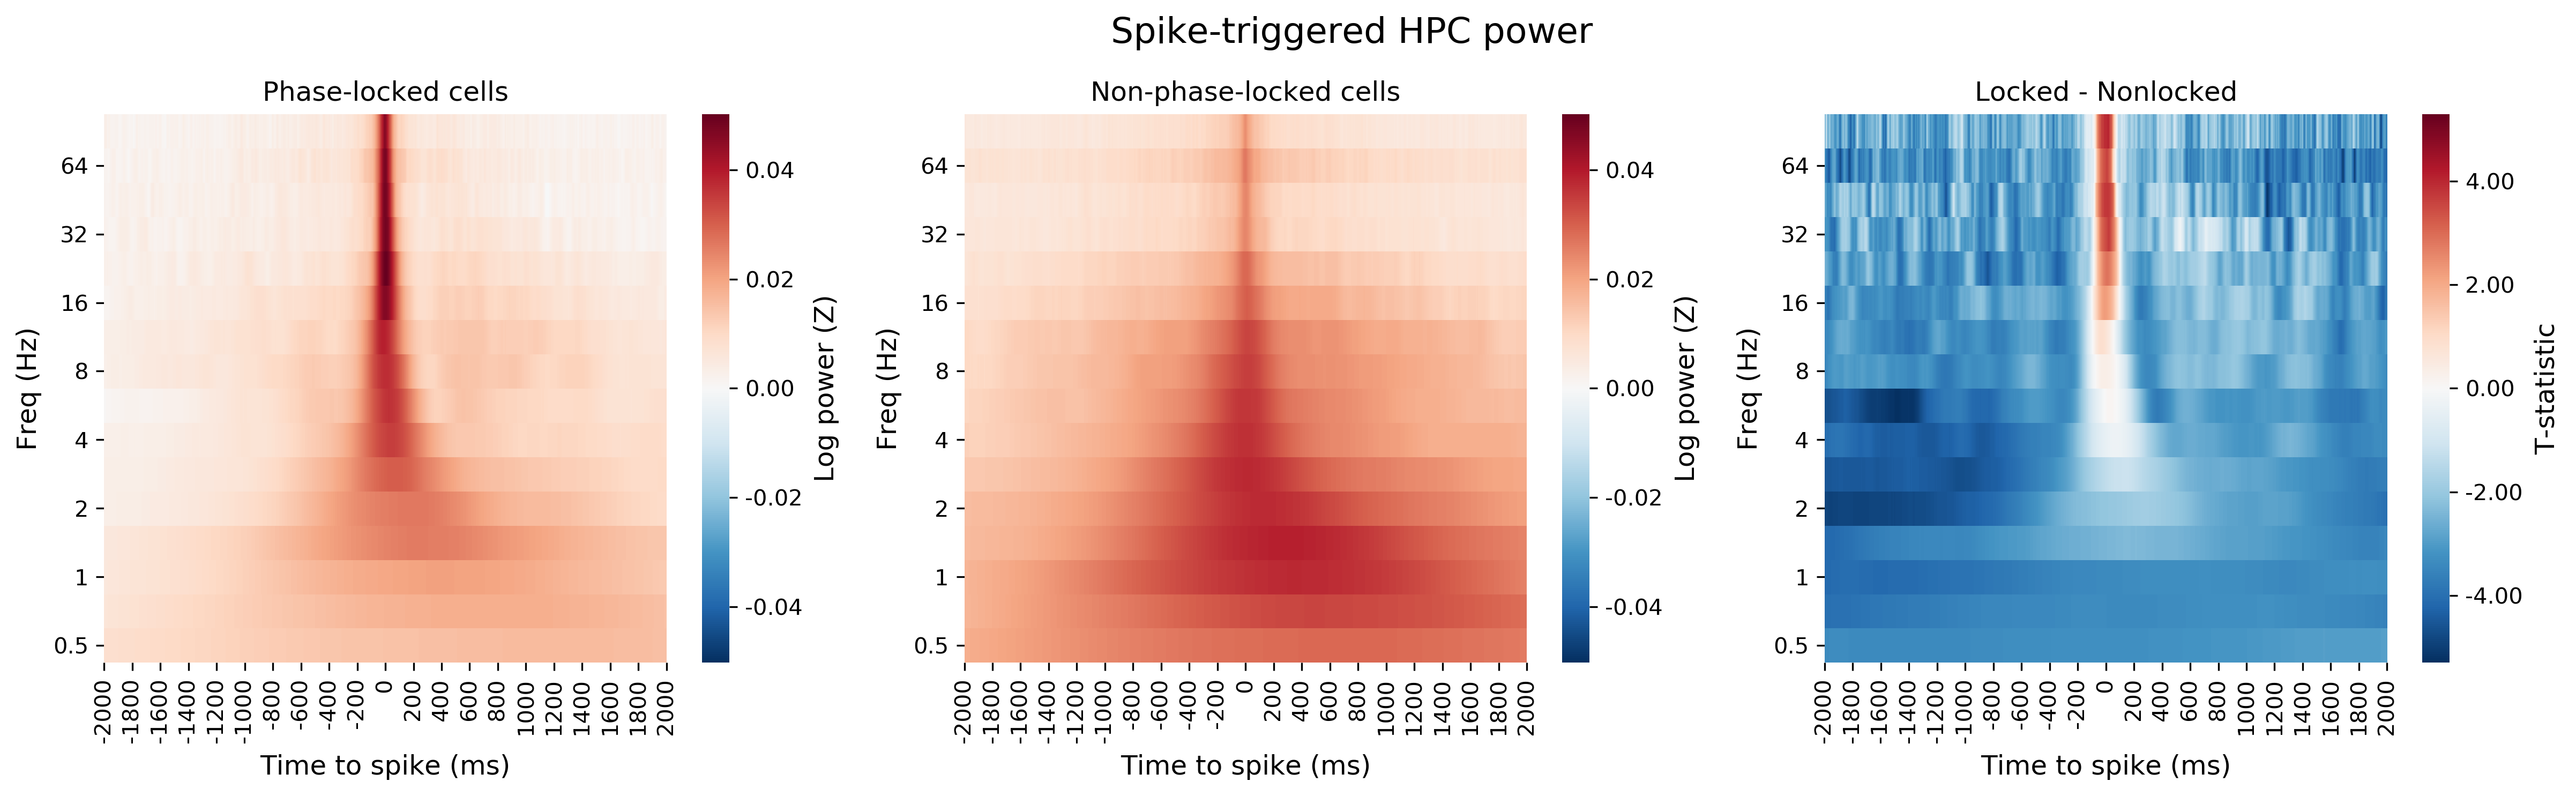

In [721]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=300)
ax = np.ravel(ax)

icpt = 0
alpha = 0.05

for i, con in enumerate(['sig', 'ns', 'tvals']):
    if i < 2:
        vmax = np.max(np.vstack((np.abs(unit_powers['sig']), np.abs(unit_powers['ns']))))
        vmin = -vmax
        ax[i+icpt] = sns.heatmap(unit_powers[con], vmin=vmin, vmax=vmax,
                             cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
    else:
        vmax = np.max(np.abs(unit_powers['tvals']))
        vmin = -vmax
        
        ma = unit_powers['pvals'] >= alpha
        ax[i+icpt] = sns.heatmap(unit_powers[con], vmin=vmin, vmax=vmax, #mask=ma,
                             cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
    #ax[i+icpt].axvline(x=4000, color='k', linewidth=0.5, alpha=1)
    ax[i+icpt].set_xticks(np.arange(0, 8001)[::400])
    ax[i+icpt].set_xticklabels(np.linspace(-2000, 2000, num=8001)[::400].astype(int), fontsize=tickfs)
    ax[i+icpt].set_yticks(np.arange(len(freqs))[::2] + 0.5)
    ax[i+icpt].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfs)
    ax[i+icpt].invert_yaxis()
    ax[i+icpt].set_xlabel('Time to spike (ms)', fontsize=labfs+2)
    ax[i+icpt].set_ylabel('Freq (Hz)', fontsize=labfs+2)
    cbar = ax[i+icpt].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfs)
    cbar.ax.ticklabel_format()
    if i < 2:
        cbar.set_label('Log power (Z)', fontsize=labfs+2)
    else:
        cbar.set_label('T-statistic', fontsize=labfs+2)
    
    if i == 0:
        ax[i+icpt].set_title('Phase-locked cells', fontsize=figfs, y=1.02)
    elif i == 1:
        ax[i+icpt].set_title('Non-phase-locked cells', fontsize=figfs, y=1.02)
    else:
        ax[i+icpt].set_title('Locked - Nonlocked', fontsize=figfs, y=1.02)
        
fig.suptitle('Spike-triggered HPC power', fontsize=figfs+4, y=0.98)
fig.tight_layout(w_pad=1.1, h_pad=1.05, rect=(0.03, 0, 0.93, 0.93))

## Older

In [ ]:
start_time = time()

power_cons = OrderedDict()
for ndat in ['phase_locking', 'local_phase_locking']:
    power_cons[ndat] = OrderedDict()
    for qtl in ['q1', 'q2', 'q3', 'q4']:
        power_cons[ndat][qtl] = []
        for f in output_files:
            dat = dio.open_pickle(f)
            power_cons[ndat][qtl].append(dat[ndat][qtl])
        print(ndat, qtl, np.array(power_cons[ndat][qtl]).shape)
    tvals, pvals = stats.ttest_rel(np.array(power_cons[ndat]['q4']),
                                   np.array(power_cons[ndat]['q1']),
                                   axis=0)
    power_cons[ndat]['q4-q1'] = {'tvals': tvals, 'pvals': pvals}
    for qtl in ['q1', 'q2', 'q3', 'q4']:
        power_cons[ndat][qtl] = np.mean(power_cons[ndat][qtl], axis=0) # mean power across units
            
print('Done in {:.2f} secs'.format(time() - start_time))

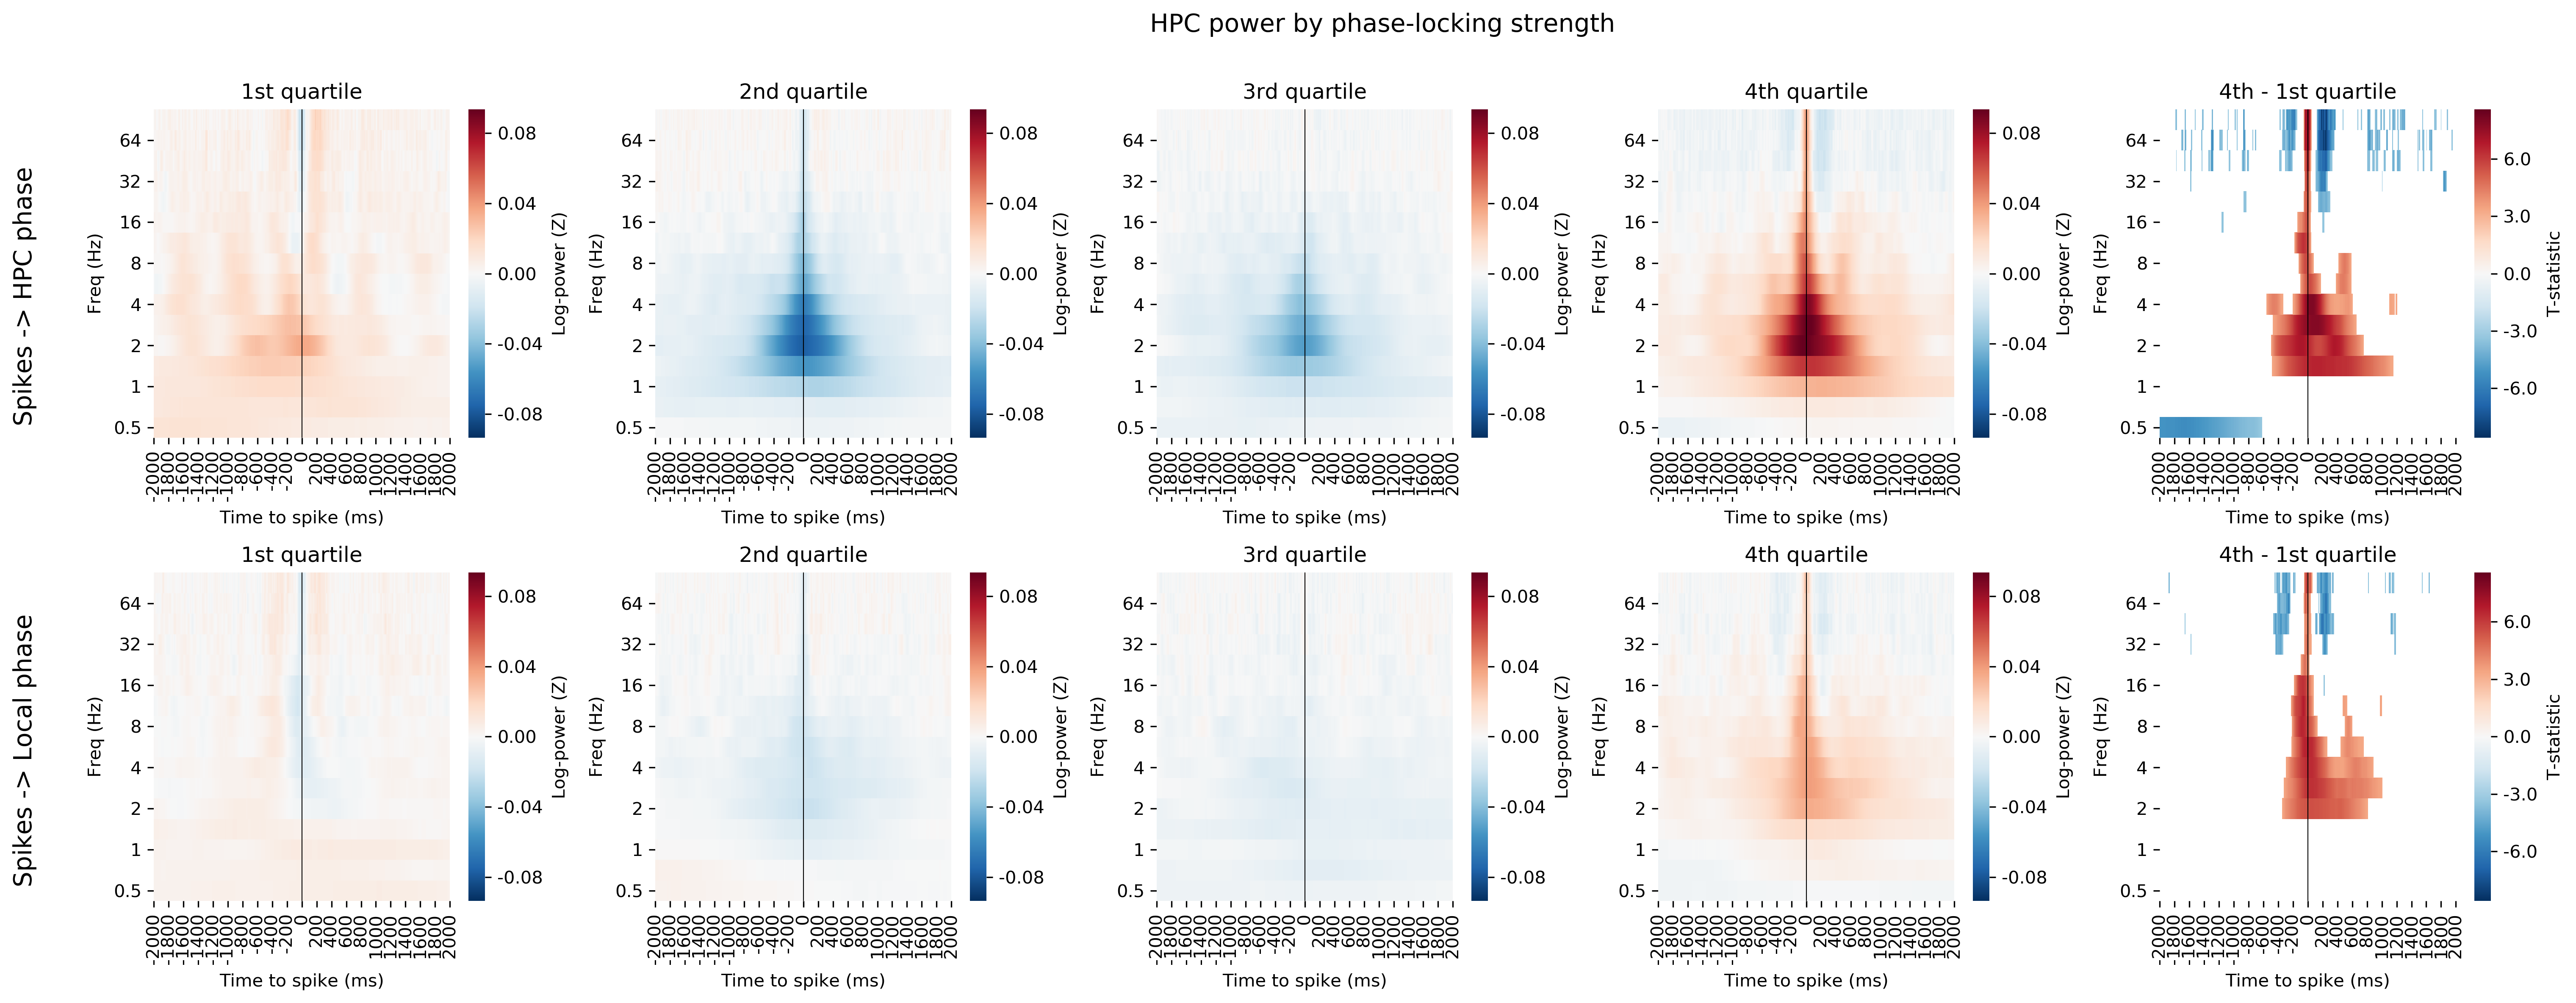

In [474]:
fig, ax = plt.subplots(2, 5, figsize=(22, 8), dpi=300)
ax = np.ravel(ax)

labs = {'q1': '1st quartile', 
        'q2': '2nd quartile',
        'q3': '3rd quartile',
        'q4': '4th quartile',
        'q4-q1': '4th - 1st quartile'}
vmax = 8
vmin = -8
alpha = 0.001

ndat_cats = ['phase_locking', 'local_phase_locking']
for iRow, ndat in enumerate(ndat_cats):
    for iCol, qtl in enumerate(['q1', 'q2', 'q3', 'q4', 'q4-q1']):
        icpt = 5 * iRow
        i = iCol

        if qtl in ['q1', 'q2', 'q3', 'q4']:
            vmax = np.max(np.abs(np.vstack((power_cons[ndat_cats[0]]['q1'], power_cons[ndat_cats[0]]['q2'], power_cons[ndat_cats[0]]['q3'], power_cons[ndat_cats[0]]['q4'],
                                            power_cons[ndat_cats[1]]['q1'], power_cons[ndat_cats[0]]['q2'], power_cons[ndat_cats[0]]['q3'], power_cons[ndat_cats[1]]['q4']))))
            vmin = -vmax
            ax[i+icpt] = sns.heatmap(power_cons[ndat][qtl], vmin=vmin, vmax=vmax, 
                                     cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
        else:
            vmax = np.max(np.vstack((np.abs(power_cons[ndat_cats[0]]['q4-q1']['tvals']), 
                                     np.abs(power_cons[ndat_cats[1]]['q4-q1']['tvals']))))
            vmin = -vmax
            ma = power_cons[ndat]['q4-q1']['pvals']>=alpha
            ax[i+icpt] = sns.heatmap(power_cons[ndat][qtl]['tvals'], vmin=vmin, vmax=vmax, mask=ma,
                                     cmap='RdBu_r', cbar_kws={'format': '%.1f'}, ax=ax[i+icpt])
        ax[i+icpt].axvline(x=4000, color='k', linewidth=0.5, alpha=1)
        ax[i+icpt].set_xticks(np.arange(0, 8001)[::400])
        ax[i+icpt].set_xticklabels(np.linspace(-2000, 2000, num=8001)[::400].astype(int), fontsize=tickfs)
        ax[i+icpt].set_yticks(np.arange(len(freqs))[::2] + 0.5)
        ax[i+icpt].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfs)
        ax[i+icpt].invert_yaxis()
        ax[i+icpt].set_xlabel('Time to spike (ms)', fontsize=labfs)
        ax[i+icpt].set_ylabel('Freq (Hz)', fontsize=labfs)
        cbar = ax[i+icpt].collections[0].colorbar
        cbar.ax.tick_params(labelsize=tickfs)
        cbar.ax.ticklabel_format()
        if qtl in ['q1', 'q2', 'q3', 'q4']:
            cbar.set_label('Log-power (Z)', fontsize=labfs)
        else:
            cbar.set_label('T-statistic', fontsize=labfs)
        ax[i+icpt].set_title(labs[qtl], fontsize=figfs, y=1.02)

fig.suptitle('HPC power by phase-locking strength', fontsize=figfs+2, y=0.98)
fig.text(0.01, 0.81, 'Spikes -> HPC phase', fontsize=figfs+2, rotation=90)
fig.text(0.01, 0.37, 'Spikes -> Local phase', fontsize=figfs+2, rotation=90)
fig.tight_layout(w_pad=1.05, h_pad=1.05, rect=(0.03, 0, 0.93, 0.93))

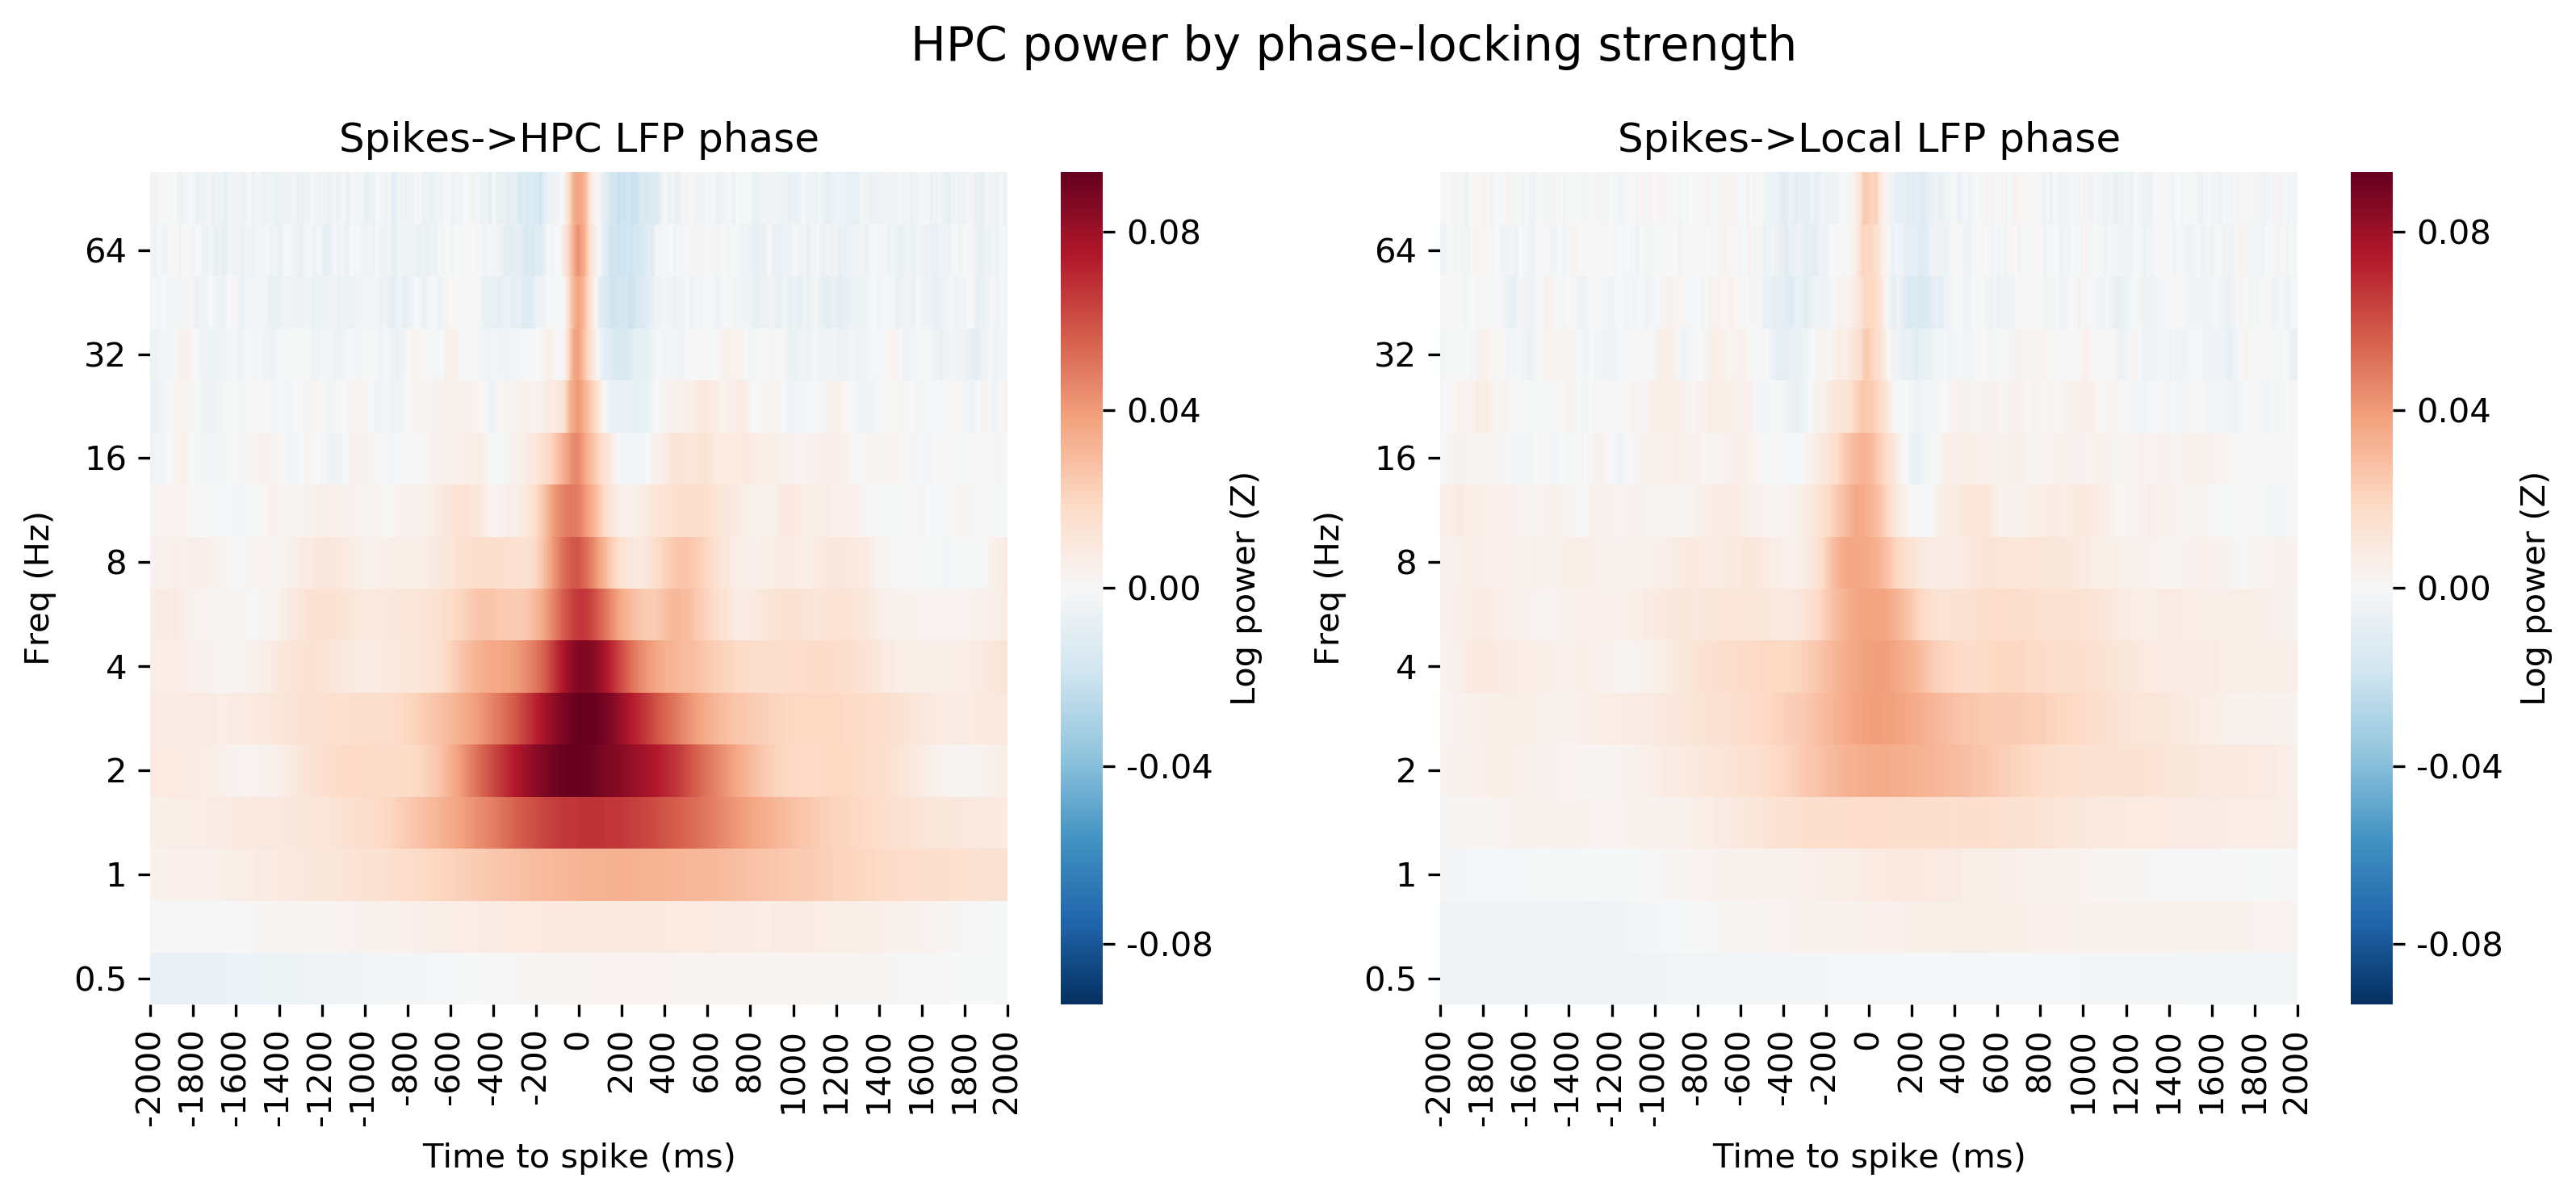

In [520]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
ax = np.ravel(ax)

ndat = 'phase_locking'
sig_type = 'sig'
icpt = 0
i = 0
alpha = 0.05

vmax = np.max(np.vstack((np.abs(power_cons['phase_locking']['q4']), np.abs(power_cons['local_phase_locking']['q4']))))
vmin = -vmax

for i, ndat in enumerate(['phase_locking', 'local_phase_locking']):
    ax[i+icpt] = sns.heatmap(power_cons[ndat]['q4'], vmin=vmin, vmax=vmax,
                             cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
    #ax[i+icpt].axvline(x=4000, color='k', linewidth=0.5, alpha=1)
    ax[i+icpt].set_xticks(np.arange(0, 8001)[::400])
    ax[i+icpt].set_xticklabels(np.linspace(-2000, 2000, num=8001)[::400].astype(int), fontsize=tickfs)
    ax[i+icpt].set_yticks(np.arange(len(freqs))[::2] + 0.5)
    ax[i+icpt].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfs)
    ax[i+icpt].invert_yaxis()
    ax[i+icpt].set_xlabel('Time to spike (ms)', fontsize=labfs)
    ax[i+icpt].set_ylabel('Freq (Hz)', fontsize=labfs)
    cbar = ax[i+icpt].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfs)
    cbar.ax.ticklabel_format()
    cbar.set_label('Log power (Z)', fontsize=labfs)
    
    if i == 0:
        ax[i+icpt].set_title('Spikes->HPC LFP phase', fontsize=figfs, y=1.02)
    else:
        ax[i+icpt].set_title('Spikes->Local LFP phase', fontsize=figfs, y=1.02)
        
fig.suptitle('HPC power by phase-locking strength', fontsize=figfs+2, y=0.98)
fig.tight_layout(w_pad=1.1, h_pad=1.05, rect=(0.03, 0, 0.93, 0.93))

In [469]:
start_time = time()

power_cons_bw = OrderedDict()
for ndat in ['phase_locking', 'local_phase_locking']:
    power_cons_bw[ndat] = []
    for f in output_files:
        dat = dio.open_pickle(f)
        power_cons_bw[ndat].append(dat[ndat]['q4-q1'])

tvals, pvals = stats.ttest_rel(np.array(power_cons_bw['phase_locking']),
                               np.array(power_cons_bw['local_phase_locking']),
                               axis=0)
            
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 4.10 secs


In [459]:
power_cons['phase_locking']['q4-q1']

AttributeError: 'dict' object has no attribute 'shape'

In [282]:
start_time = time()


files = []
for row in u2r_df:
    f = pl_fname.format(row.subj_sess, row.unit, row.lfp_hemroi)
    if os.path.exists(f):
        files.append(f)
print(len(files))

#files = glob(os.path.join(pl_dir, 'phase_locking_stats-U369_env1-*-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl'))
pl_df = pd.DataFrame(dio.open_pickle(files[0])).T
for f in files[1:]:
    pl_df = pl_df.append(dio.open_pickle(f))
pl_df.reset_index(drop=True, inplace=True)

map_dtypes = {'unit_nspikes': np.uint32,
              'unit_nsamp_spikes': np.uint32,
              'unit_fr': np.float32,
              'lfp_is_hpc': np.bool,
              'same_chan': np.bool,
              'same_hemroi': np.bool,
              'same_hem': np.bool,
              'same_roi': np.bool,
              'both_hpc': np.bool,
              'same_roi2': np.bool,
              'locked_freq_ind_z': np.uint8,
              'locked_mrl_z': np.float64,
              'bs_ind_z': np.uint16,
              'bs_pval_z': np.float64,
              'sig_z': np.bool,
              'tl_locked_freq_z': np.uint8,
              'tl_locked_time_z': np.int32,
              'tl_locked_mrl_z': np.float64,
              'pref_phase': np.float64,
              'pref_phase_tl_locked_time_freq_z': np.float64}
for col, dtype in map_dtypes.items():
    pl_df[col] = pl_df[col].astype(dtype)

pl_df['sig_z_fdr'] = False
for edge_type in ['ctx-hpc']:
    pvals_in = np.array(pl_df.loc[(pl_df.edge==edge_type)].bs_pval_z.tolist())
    output = sm.stats.multipletests(pvals_in, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)
    sig_out = list(output[0])
    pvals_out = output[1]
    pl_df.loc[(pl_df.edge==edge_type), 'sig_z_fdr'] = sig_out

print(pl_df.shape)

print('Done in {:.2f} secs'.format(time() - start_time))

2543
(2543, 46)
Done in 55.91 secs


In [302]:
np.unique(pl_df.edge)

array(['ctx-hpc'], dtype=object)

In [286]:
pl_df.groupby(['edge', 'same_hem']).agg({'sig_z_fdr': [len, np.sum, np.mean]})

sig_z_fdr                 
                       len    sum      mean
edge    same_hem                           
ctx-hpc False         1226  190.0  0.154976
        True          1317  354.0  0.268793

In [288]:
subj_sess, unit, lfp_roi

('U396_ses3', 17, 'RAH')

In [294]:
#dio.open_pickle(pl_fname.format(subj_sess, unit, lfp_roi))

In [296]:
power_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr/*'))
pl_fname = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region',
                        'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
pl_files = []
sig_power_files = []
nsig_power_files = []
missing_files = []
for f in power_files:
    fsplit = os.path.basename(f).split('-')
    subj_sess = fsplit[1]
    unit = int(fsplit[2][5:])
    lfp_roi = fsplit[3][4:]
    if os.path.exists(pl_fname.format(subj_sess, unit, lfp_roi)):
        #info = dio.open_pickle(pl_fname.format(subj_sess, unit, lfp_roi))
        info = pl_df.query("(subj_sess=='{}') & (unit=={}) & (lfp_hemroi=='{}')".format(subj_sess, unit, lfp_roi)).iloc[0]
        if info.sig_z_fdr:
            sig_power_files.append(f)
        else:
            nsig_power_files.append(f)
    else:
        missing_files.append(pl_fname.format(subj_sess, unit, lfp_roi))

print(len(sig_power_files), len(nsig_power_files), len(sig_power_files) / (len(sig_power_files) + len(nsig_power_files)))
print('{} missing files'.format(len(missing_files)))

480 1798 0.21071115013169447
0 missing files


In [ ]:
ndat = 'phase_locking'
power_dat = []
for sig_type in ['sig', 'nsig']:
    for f in files[sig_type]:
        power_dat.append(dio.open_pickle(f)[ndat])

In [387]:
# Get indiv examples of spike-triggered power during high phase-locking.
sig_type = 'sig'
ndat = 'phase_locking'
qtl = 'high'
files_ = files[sig_type]
power_cons[sig_type][ndat][qtl] = []
power_examples = []
for f in files_:
    dat = dio.open_pickle(f)
    power_examples.append(dat[ndat][qtl])
power_examples = np.array(power_examples)
power_examples.shape

(480, 16, 8001)

In [ ]:
# 

In [298]:
start_time = time()

files = {'sig': sig_power_files, 
         'nsig': nsig_power_files}
power_cons = OrderedDict([('sig', OrderedDict()), 
                          ('nsig', OrderedDict())])
for sig_type in ['sig', 'nsig']:
    files_ = files[sig_type]
    for ndat in ['phase_locking', 'phase_locking2', 'firing_rate']:
        power_cons[sig_type][ndat] = OrderedDict()
        for qtl in ['low', 'high']:
            power_cons[sig_type][ndat][qtl] = []
            for f in files_:
                dat = dio.open_pickle(f)
                power_cons[sig_type][ndat][qtl].append(dat[ndat][qtl])
            print(sig_type, ndat, qtl, np.array(power_cons[sig_type][ndat][qtl]).shape)
        tvals, pvals = stats.ttest_rel(np.array(power_cons[sig_type][ndat]['high']),
                                       np.array(power_cons[sig_type][ndat]['low']),
                                       axis=0)
        power_cons[sig_type][ndat]['high-low'] = {'tvals': tvals, 'pvals': pvals}
        for qtl in ['low', 'high']:
            power_cons[sig_type][ndat][qtl] = np.mean(power_cons[sig_type][ndat][qtl], axis=0)
            
print('Done in {:.2f} secs'.format(time() - start_time))

sig phase_locking low (480, 16, 8001)
sig phase_locking high (480, 16, 8001)
sig phase_locking2 low (480, 16, 8001)
sig phase_locking2 high (480, 16, 8001)
sig firing_rate low (480, 16, 8001)
sig firing_rate high (480, 16, 8001)
nsig phase_locking low (1798, 16, 8001)
nsig phase_locking high (1798, 16, 8001)
nsig phase_locking2 low (1798, 16, 8001)
nsig phase_locking2 high (1798, 16, 8001)
nsig firing_rate low (1798, 16, 8001)
nsig firing_rate high (1798, 16, 8001)
Done in 137.94 secs


Text(0.5, 1.02, 'Top - bottom quartile')

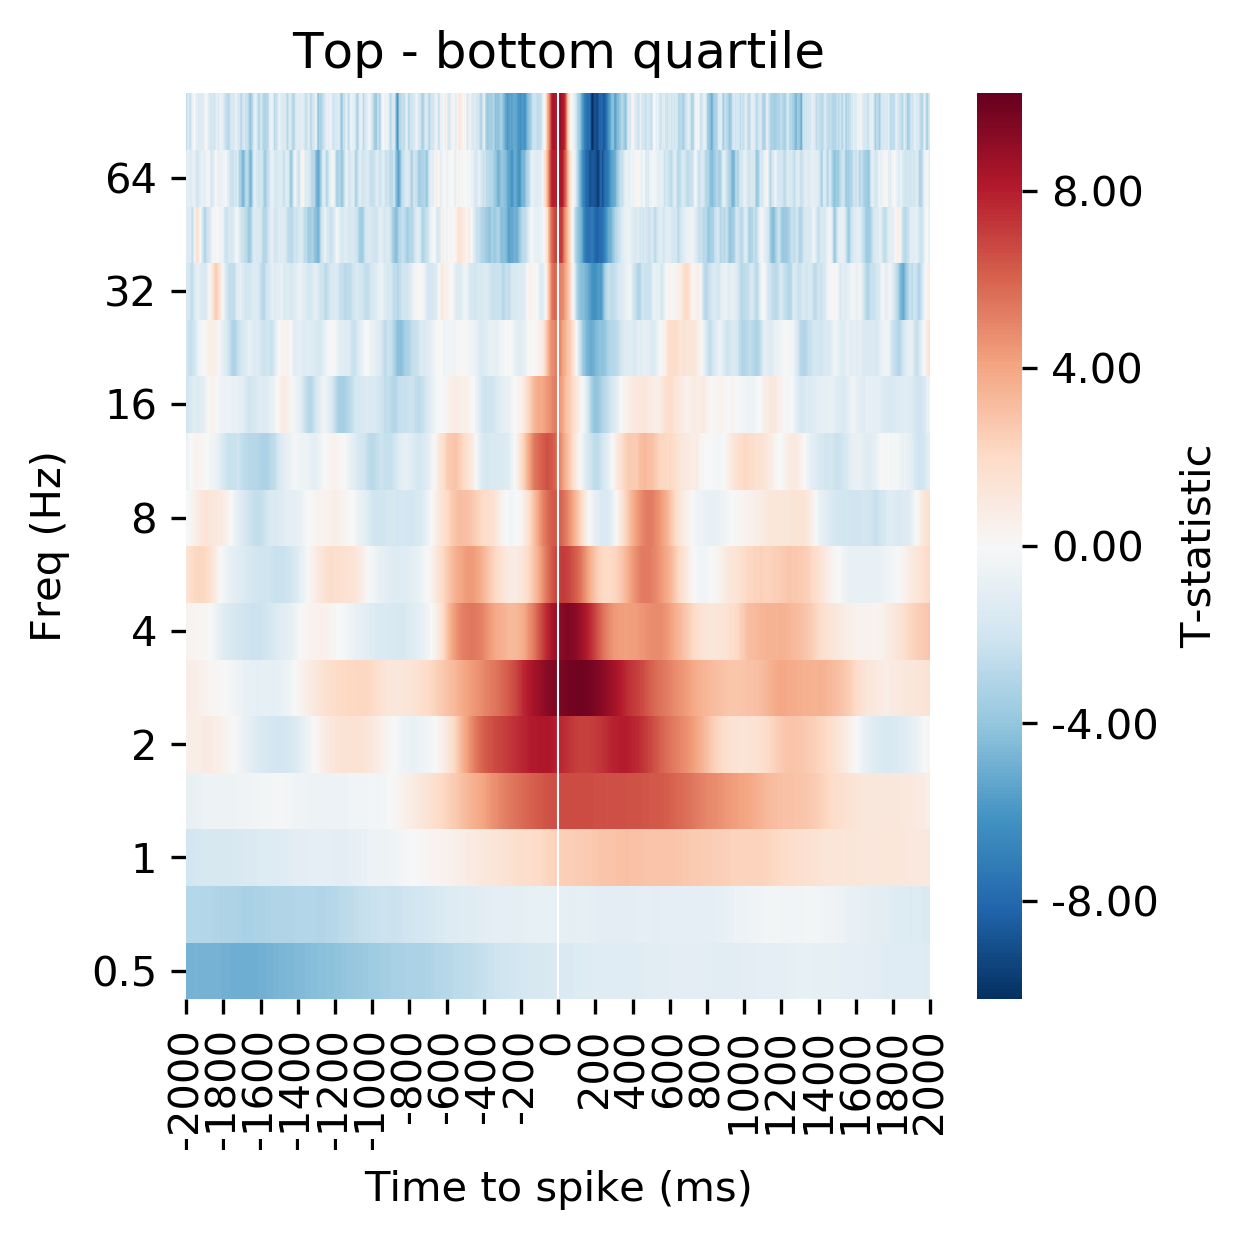

In [393]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

ndat = 'phase_locking'
sig_type = 'sig'
qtl = 'high-low'
icpt = 0
i = 0

ax[i+icpt] = sns.heatmap(power_cons[sig_type][ndat][qtl]['tvals'], vmin=vmin, vmax=vmax,
                         cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
ax[i+icpt].axvline(x=4000, color='w', linewidth=0.5, alpha=1)
ax[i+icpt].set_xticks(np.arange(0, 8001)[::400])
ax[i+icpt].set_xticklabels(np.linspace(-2000, 2000, num=8001)[::400].astype(int), fontsize=tickfs)
ax[i+icpt].set_yticks(np.arange(len(freqs))[::2] + 0.5)
ax[i+icpt].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfs)
ax[i+icpt].invert_yaxis()
ax[i+icpt].set_xlabel('Time to spike (ms)', fontsize=labfs)
ax[i+icpt].set_ylabel('Freq (Hz)', fontsize=labfs)
cbar = ax[i+icpt].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfs)
cbar.ax.ticklabel_format()
cbar.set_label('T-statistic', fontsize=labfs)
ax[i+icpt].set_title(labs[qtl], fontsize=figfs, y=1.02)

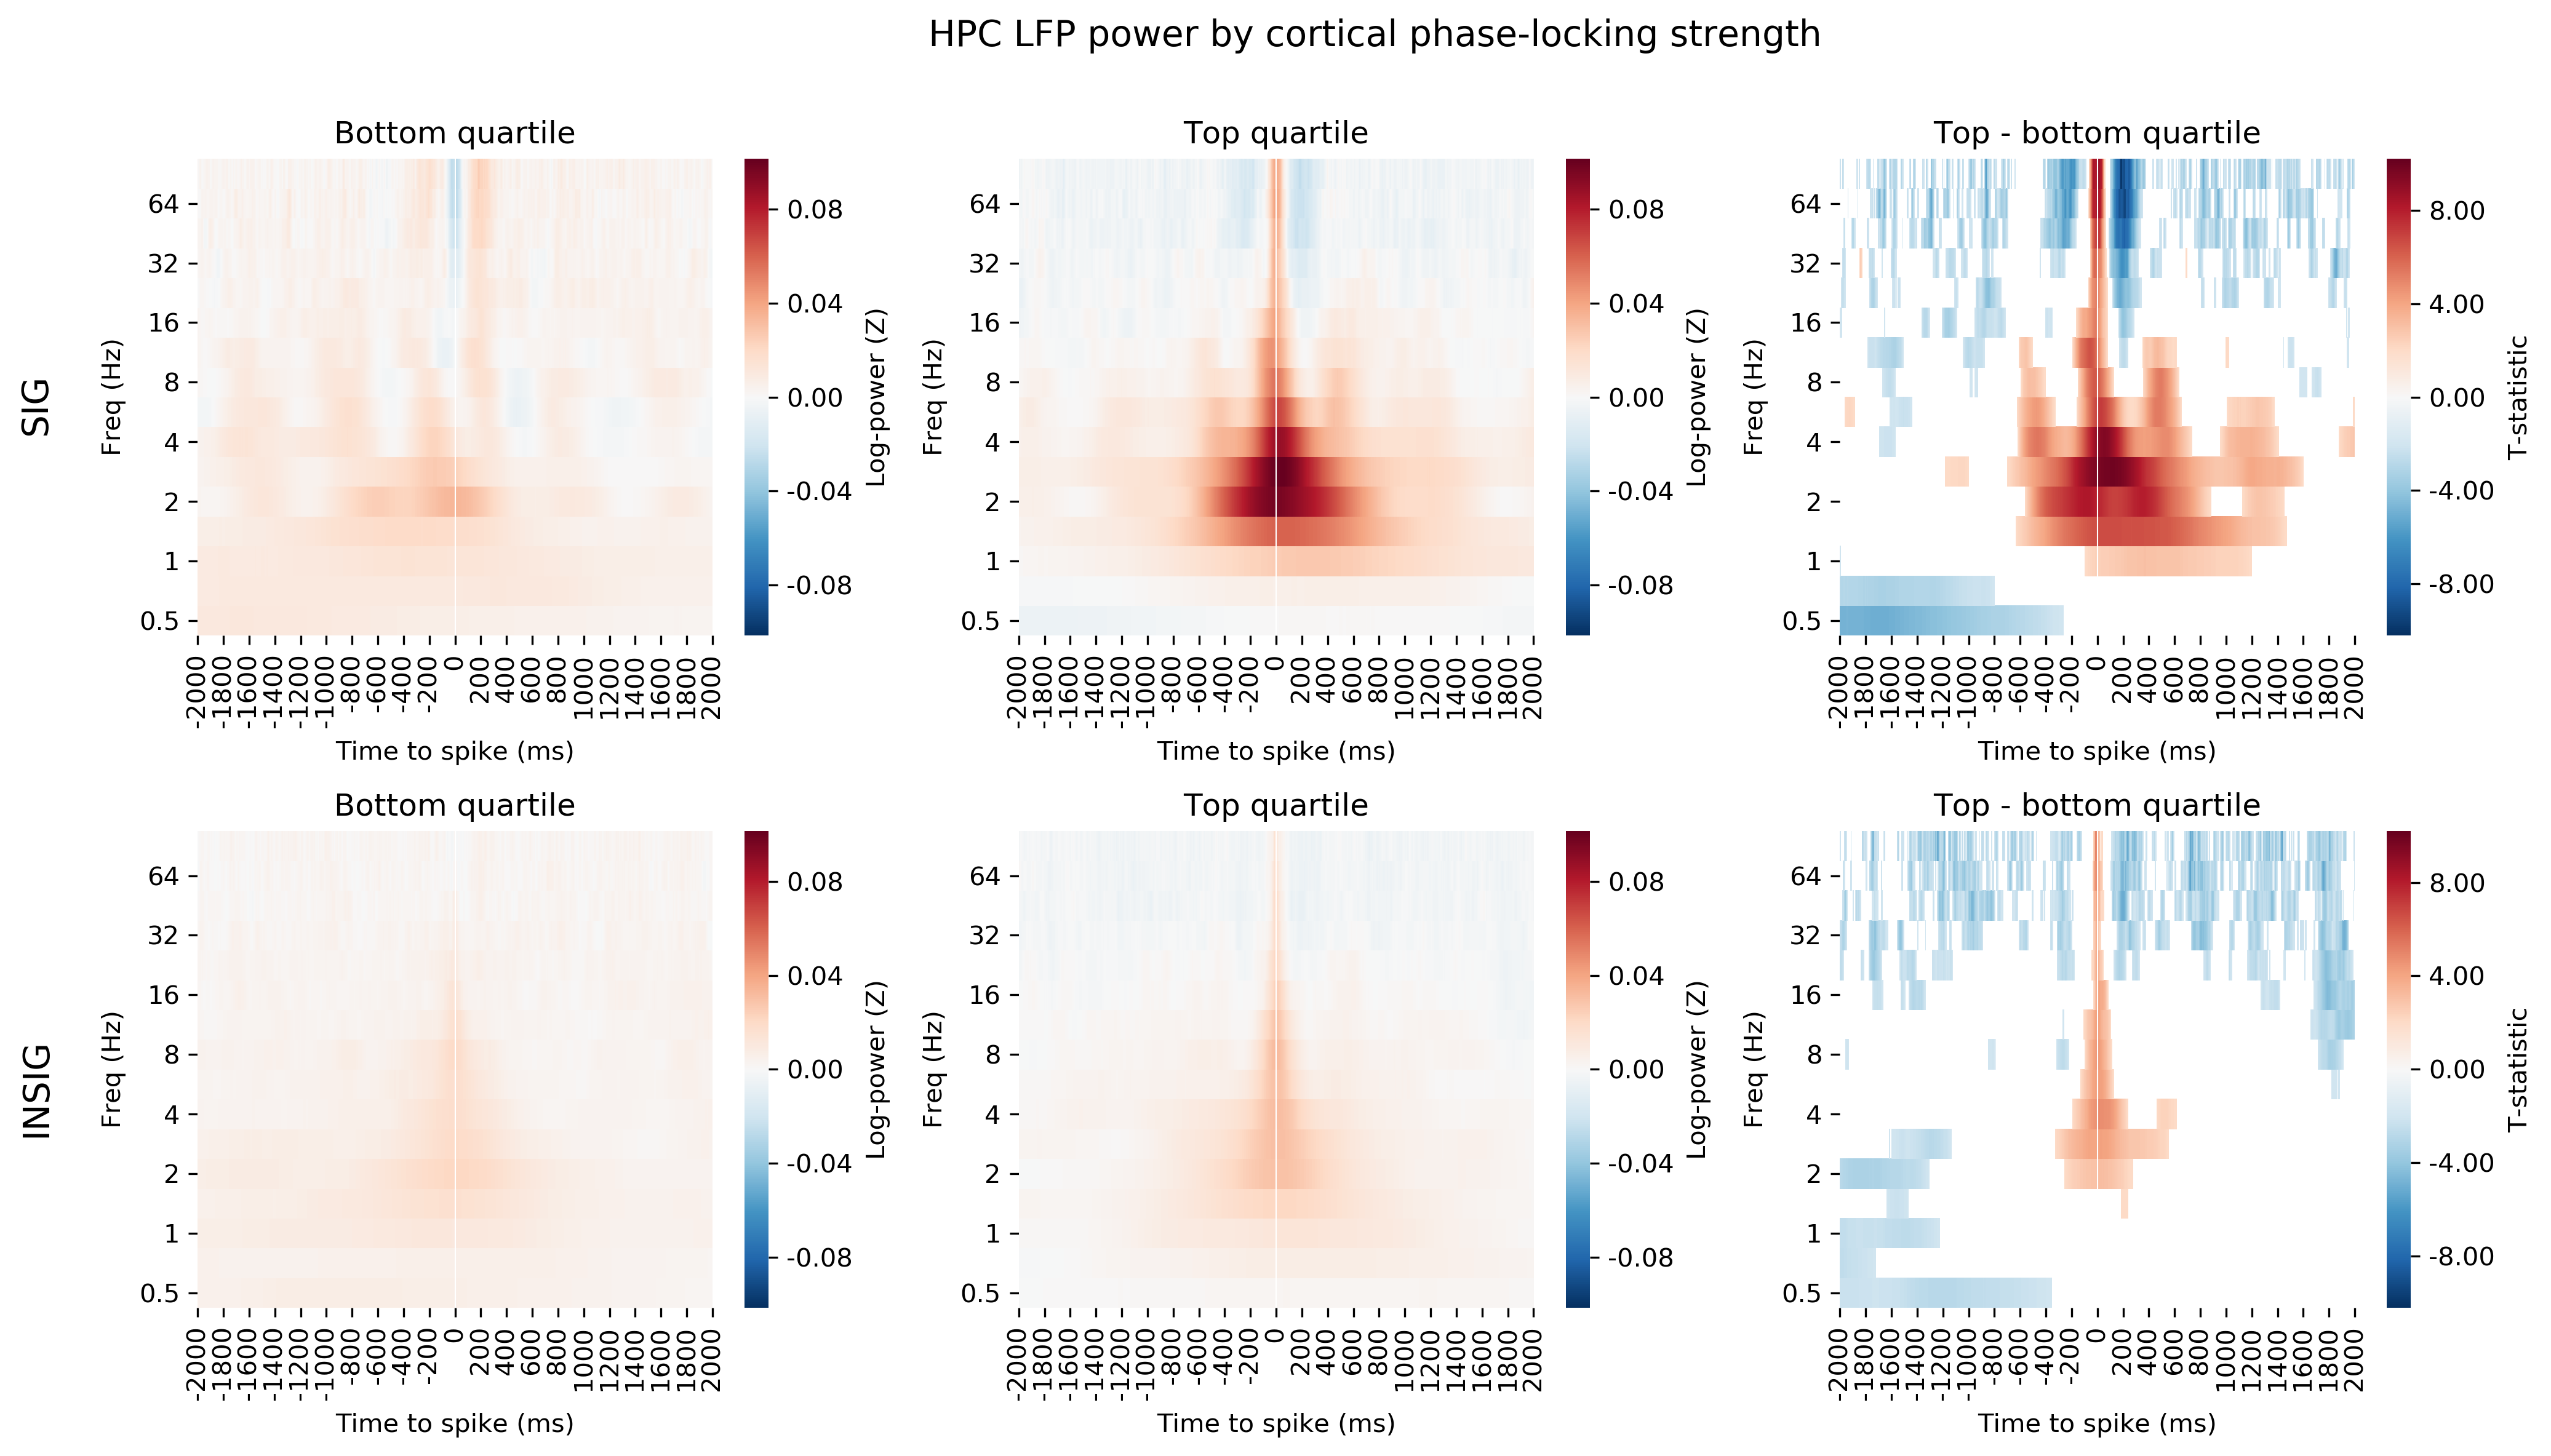

In [375]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8), dpi=300)
ax = np.ravel(ax)

ndat = 'phase_locking'

fig_labs = {'firing_rate': 'HPC LFP power by cortical firing rate',
            'phase_locking': 'HPC LFP power by cortical phase-locking strength',
            'phase_locking2': 'HPC LFP power by cortical phase-locking strength'}
labs = {'low': 'Bottom quartile', 
        'high': 'Top quartile', 
        'high-low': 'Top - bottom quartile'}

sig_types = ['sig', 'nsig']
qtls = ['low', 'high', 'high-low']

for j, sig_type in enumerate(sig_types):
    for i, qtl in enumerate(qtls):
        if j == 0:
            icpt = 0
        else:
            icpt = 3
            
        if qtl in ['low', 'high']:
            vmax = np.max(np.abs(np.vstack((power_cons['sig'][ndat]['low'], power_cons['sig'][ndat]['high'],
                                            power_cons['nsig'][ndat]['low'], power_cons['nsig'][ndat]['high']))))
            vmin = -vmax
            ax[i+icpt] = sns.heatmap(power_cons[sig_type][ndat][qtl], vmin=vmin, vmax=vmax, 
                                     cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
        else:
            vmax = np.max(np.abs(np.vstack((power_cons['sig'][ndat]['high-low']['tvals'], power_cons['nsig'][ndat]['high-low']['tvals']))))
            vmin = -vmax
            ma = np.abs(power_cons[sig_type][ndat]['high-low']['tvals'])<2
            ax[i+icpt] = sns.heatmap(power_cons[sig_type][ndat][qtl]['tvals'], vmin=vmin, vmax=vmax, mask=ma,
                                     cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
        ax[i+icpt].axvline(x=4000, color='w', linewidth=0.5, alpha=1)
        ax[i+icpt].set_xticks(np.arange(0, 8001)[::400])
        ax[i+icpt].set_xticklabels(np.linspace(-2000, 2000, num=8001)[::400].astype(int), fontsize=tickfs)
        ax[i+icpt].set_yticks(np.arange(len(freqs))[::2] + 0.5)
        ax[i+icpt].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfs)
        ax[i+icpt].invert_yaxis()
        ax[i+icpt].set_xlabel('Time to spike (ms)', fontsize=labfs)
        ax[i+icpt].set_ylabel('Freq (Hz)', fontsize=labfs)
        cbar = ax[i+icpt].collections[0].colorbar
        cbar.ax.tick_params(labelsize=tickfs)
        cbar.ax.ticklabel_format()
        if qtl in ['low', 'high']:
            cbar.set_label('Log-power (Z)', fontsize=labfs)
        else:
            cbar.set_label('T-statistic', fontsize=labfs)
        ax[i+icpt].set_title(labs[qtl], fontsize=figfs, y=1.02)

fig.suptitle(fig_labs[ndat], fontsize=figfs+2, y=0.98)
fig.text(0.01, 0.72, 'SIG', fontsize=figfs+2, rotation=90)
fig.text(0.01, 0.27, 'INSIG', fontsize=figfs+2, rotation=90)
fig.tight_layout(w_pad=1.05, h_pad=1.05, rect=(0.03, 0, 0.93, 0.93))

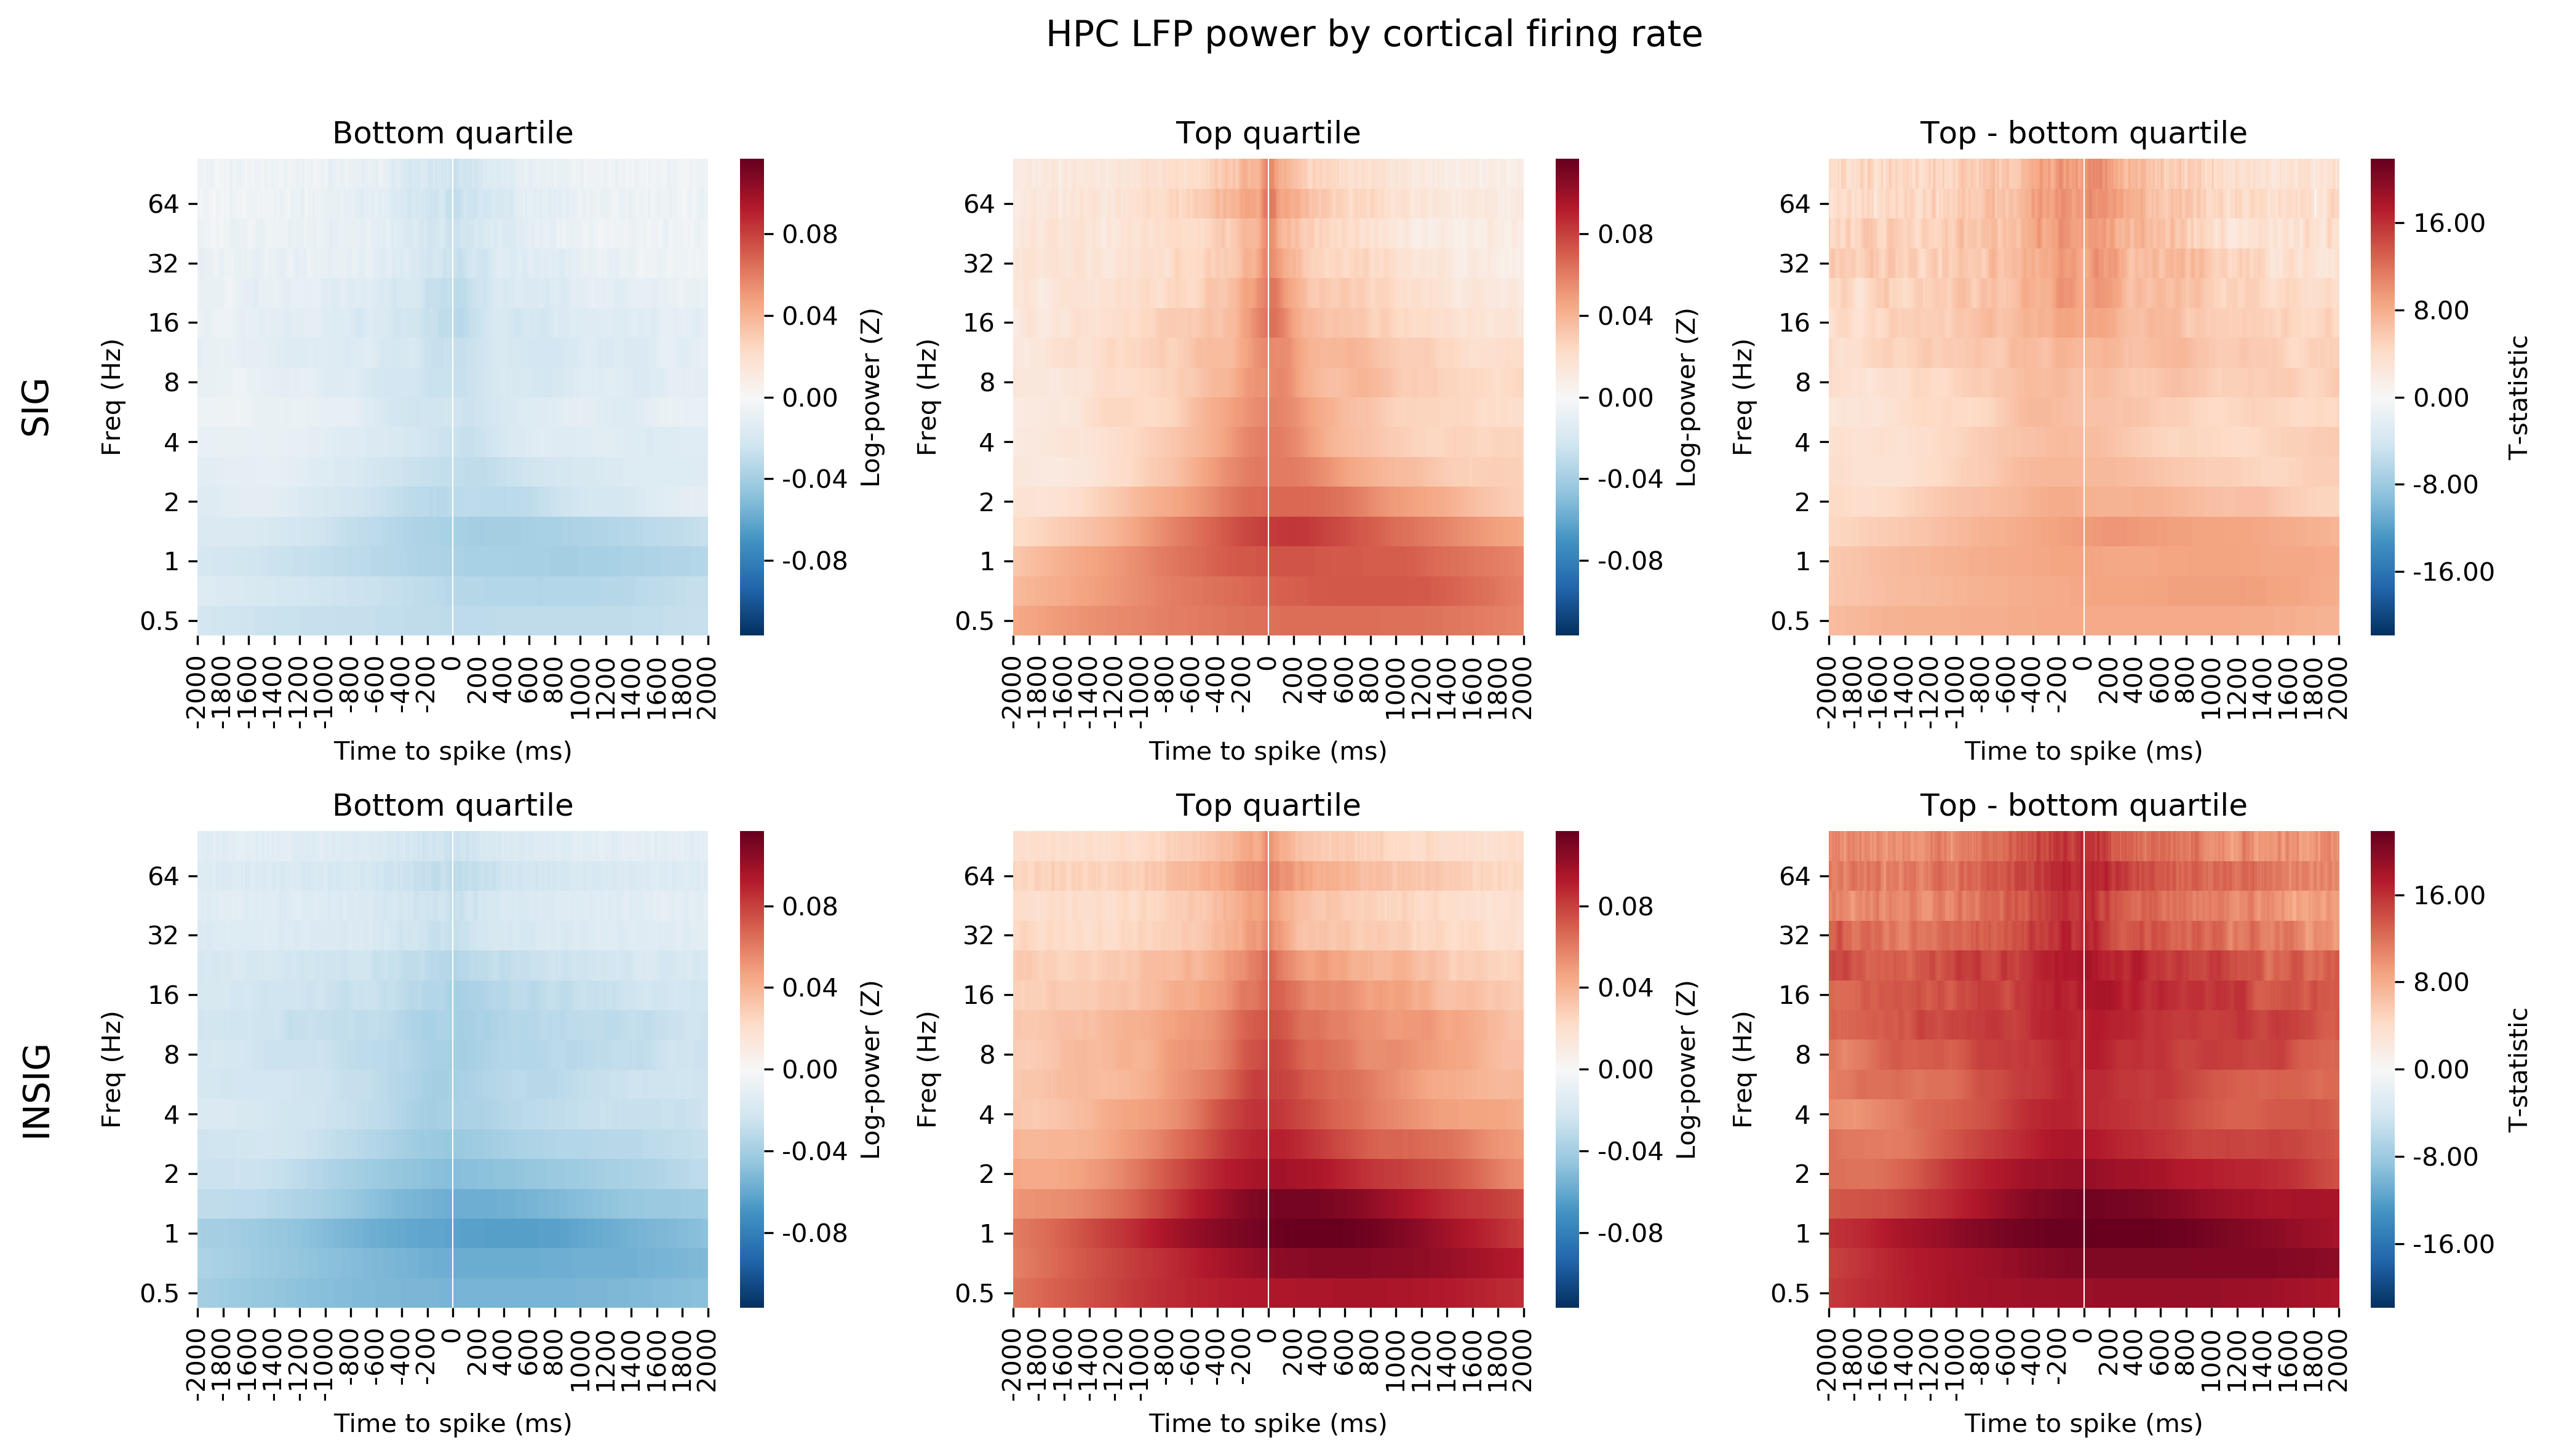

In [301]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8), dpi=300)
ax = np.ravel(ax)

ndat = 'firing_rate'

fig_labs = {'firing_rate': 'HPC LFP power by cortical firing rate',
            'phase_locking': 'HPC LFP power by cortical phase-locking strength',
            'phase_locking2': 'HPC LFP power by cortical phase-locking strength'}
labs = {'low': 'Bottom quartile', 
        'high': 'Top quartile', 
        'high-low': 'Top - bottom quartile'}

sig_types = ['sig', 'nsig']
qtls = ['low', 'high', 'high-low']

for j, sig_type in enumerate(sig_types):
    for i, qtl in enumerate(qtls):
        if j == 0:
            icpt = 0
        else:
            icpt = 3
            
        if qtl in ['low', 'high']:
            vmax = np.max(np.abs(np.vstack((power_cons['sig'][ndat]['low'], power_cons['sig'][ndat]['high'],
                                            power_cons['nsig'][ndat]['low'], power_cons['nsig'][ndat]['high']))))
            vmin = -vmax
            ax[i+icpt] = sns.heatmap(power_cons[sig_type][ndat][qtl], vmin=vmin, vmax=vmax, 
                                     cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
        else:
            vmax = np.max(np.abs(np.vstack((power_cons['sig'][ndat]['high-low']['tvals'], power_cons['nsig'][ndat]['high-low']['tvals']))))
            vmin = -vmax
            ma = np.abs(power_cons[sig_type][ndat]['high-low']['tvals'])<2
            ax[i+icpt] = sns.heatmap(power_cons[sig_type][ndat][qtl]['tvals'], vmin=vmin, vmax=vmax, mask=ma,
                                     cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i+icpt])
        ax[i+icpt].axvline(x=4000, color='w', linewidth=0.5, alpha=1)
        ax[i+icpt].set_xticks(np.arange(0, 8001)[::400])
        ax[i+icpt].set_xticklabels(np.linspace(-2000, 2000, num=8001)[::400].astype(int), fontsize=tickfs)
        ax[i+icpt].set_yticks(np.arange(len(freqs))[::2] + 0.5)
        ax[i+icpt].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfs)
        ax[i+icpt].invert_yaxis()
        ax[i+icpt].set_xlabel('Time to spike (ms)', fontsize=labfs)
        ax[i+icpt].set_ylabel('Freq (Hz)', fontsize=labfs)
        cbar = ax[i+icpt].collections[0].colorbar
        cbar.ax.tick_params(labelsize=tickfs)
        cbar.ax.ticklabel_format()
        if qtl in ['low', 'high']:
            cbar.set_label('Log-power (Z)', fontsize=labfs)
        else:
            cbar.set_label('T-statistic', fontsize=labfs)
        ax[i+icpt].set_title(labs[qtl], fontsize=figfs, y=1.02)

fig.suptitle(fig_labs[ndat], fontsize=figfs+2, y=0.98)
fig.text(0.01, 0.72, 'SIG', fontsize=figfs+2, rotation=90)
fig.text(0.01, 0.27, 'INSIG', fontsize=figfs+2, rotation=90)
fig.tight_layout(w_pad=1.05, h_pad=1.05, rect=(0.03, 0, 0.93, 0.93))

In [69]:
start_time = time()
output = phase_locking.calc_power_by_pl_fr_unit_to_region(subj_sess, unit, lfp_roi, save_outputs=False)
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 0.01 secs


In [131]:
subj_sess = 'U369_env1'
unit = 9
lfp_roi = 'RMH'
n_freqs=16
sampling_rate=2000
time_win=2
input_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'
save_outputs=True
output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr'

In [133]:
# General params.
power_fname = os.path.join(input_dir, 'wavelet', 'power', 
                           'power-Z-log-{}-iChan{}-iFreq{}-2000Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
spike_fname = os.path.join(input_dir, 'spike_inds', 'spike_inds-2000Hz-{}-unit{}.pkl')
fr_fname = os.path.join(input_dir, 'spike_frs', 'spike_frs-2000Hz-{}-unit{}.pkl')
pl_fname = os.path.join(input_dir, 'phase_locking', 'unit_to_region', 
                        'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
cut_inds = int(sampling_rate * time_win)
info = dio.open_pickle(pl_fname.format(subj_sess, unit, lfp_roi))
lfp_chan_inds = info.lfp_chan_inds

In [153]:
# Get LFP power. 
power_ = []
for iChan in lfp_chan_inds:
    power__ = []
    for iFreq in range(n_freqs):
        power__.append(dio.open_pickle(power_fname.format(subj_sess, iChan, iFreq)))
    power_.append(power__)
power_ = np.mean(power_, axis=0) # freq x time

# Get phase offsets and firing rates for each spike.
phase_offsets = info.phase_offsets
phase_offsets2 = info.phase_offsets_tl_locked_time_freq_z
spike_inds, n_timepoints = dio.open_pickle(spike_fname.format(subj_sess, unit))
firing_rates = dio.open_pickle(fr_fname.format(subj_sess, unit))
firing_rates = firing_rates[(spike_inds>cut_inds) & (spike_inds<(n_timepoints-cut_inds))]
spike_inds = info.spike_inds
assert len(spike_inds) == len(phase_offsets) == len(phase_offsets2) == len(firing_rates)

# Cut spikes from the beginning so both vectors are divisible by 4.
cut = len(phase_offsets) % 4
spike_inds = spike_inds[cut:]
phase_offsets = phase_offsets[cut:]
phase_offsets2 = phase_offsets2[cut:]
firing_rates = firing_rates[cut:]

# Get 2 sec of power surrounding each spike.
power = []
for spike_ind in spike_inds:
    power.append(power_[:, spike_ind-cut_inds:spike_ind+cut_inds+1])
power = stats.zscore(power, axis=0) # spike x freq x time; Z-scored over spike events
#del power_

In [148]:
# Sort spikes by phase offset and firing rate.
xsort = OrderedDict()
xsort['phase_locking'] = phase_offsets.argsort()[::-1] # low to high offset from the preferred phase
xsort['firing_rate'] = firing_rates.argsort()

In [22]:
# Split power into quartiles based on phase_locking offset or firing rate.
output = OrderedDict()
for key in xsort.keys():
    split_power = np.split(power[xsort[key]], 4, axis=0) # low to high phase-locking
    output[key] = OrderedDict([('low', np.mean(split_power[0], axis=(0, 1)).astype(np.float32)),
                               ('high', np.mean(split_power[-1], axis=(0, 1)).astype(np.float32))])
    output[key]['high-low'] = output[key]['high'] - output[key]['low']

In [27]:
output['firing_rate']['low'].shape

(16, 8001)

In [478]:
pref_phase, phase_offsets = phase_locking.phase_offsets_by_spike(info, info.locked_freq_ind_z)

In [482]:
pd.Series(phase_offsets).describe()

count    27333.000000
mean         1.548876
std          0.818895
min          0.065629
25%          0.829729
50%          1.540212
75%          2.254432
max          3.061730
dtype: float64

In [489]:
m = np.arange(50).reshape([5, 10])
display(m)
display(m[[1, 3, 0, 4, 2], :])

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])

array([[10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [492]:
 # Get the circular distance between each spike phase (at the locked frequency) 
# and the mean preferred phase for each channel. Then take the average circular distance
# across channels. This is done for t=0 time shift and at the maximum locked time shift.
step = time_steps[-tl_locked_time_ind_z] # negative since we flipped tl_mrls_z above
spike_inds_shifted = shift_spike_inds(spike_inds, n_timepoints, step)
test_spike_inds = [spike_inds, spike_inds_shifted]
test_freqs = [info['locked_freq_ind_z'], info['tl_locked_freq_z']]
for i in range(len(test_spike_inds)):
    spike_inds_ = test_spike_inds[i]
    iFreq = test_freqs[i]
    spike_phases = []
    phase_offsets = []
    for iChan in lfp_chans:
        phase = dio.open_pickle(os.path.join(phase_dir, phase_fname.format(subj_sess, iChan, iFreq, sampling_rate)))
        spike_phases_ = phase[spike_inds_]
        pref_phase_ = circstats.circmoment(spike_phases_)[0]
        spike_phases.append(spike_phases_)
        phase_offsets.append(np.abs(pycircstat.descriptive.cdiff(spike_phases_, np.repeat(pref_phase_, len(spike_phases_)))))
    pref_phase = circstats.circmoment(np.array(spike_phases).flatten())[0] # preferred phase taking all spike phases across channels
    phase_offsets = np.mean(phase_offsets, axis=0).astype(np.float32) # circular distance between each spike and the preferred phase for each channel, averaged across chann

In [499]:
phase_offsets.shape

(27333,)

In [502]:
np.pi - (0.29829913 - .14159)

2.9848835235897933

In [506]:
pycircstat.descriptive.cdiff(phase_offsets, np.repeat(np.pi, len(phase_offsets)))

array([-2.84329351, -2.15242124, -1.22661187, ..., -2.02860453,
       -2.55872683, -1.55265334])

In [496]:
pref_phase, phase_offsets

(0.8488377731493091,
 array([0.29829913, 0.98917145, 1.9149808 , ..., 1.1129881 , 0.58286583,
        1.5889393 ], dtype=float32))

In [490]:
phase_locking.calc_power_by_pl_unit_to_region??

Signature: phase_locking.calc_power_by_pl_unit_to_region(info, n_freqs=16, sampling_rate=2000, time_win=2, input_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', save_outputs=True, overwrite=False, output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr', sleep_max=0)
Source:   
def calc_power_by_pl_unit_to_region(info,
                                    n_freqs=16,
                                    sampling_rate=2000,
                                    time_win=2,
                                    input_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                    save_outputs=True,
                                    overwrite=False,
                                    output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/power_by_pl_fr',
                                    sleep_max=0):
    """Analyze Z-scored log-power val

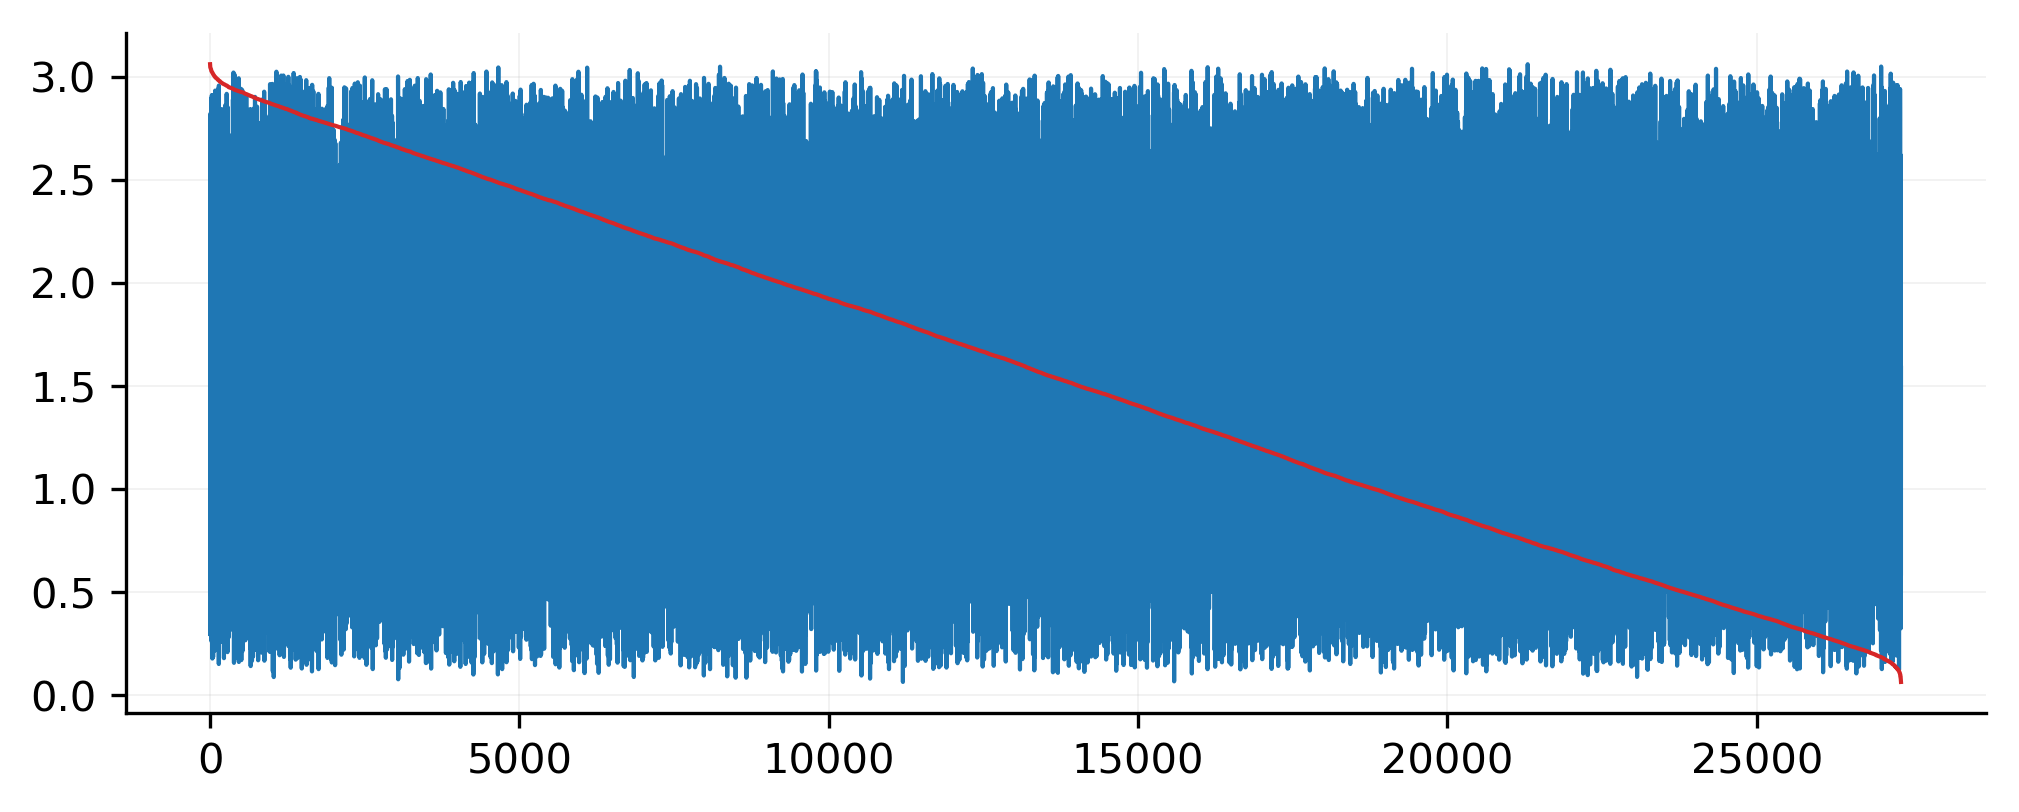

In [485]:
srt = phase_offsets.argsort()[::-1]
plt.plot(phase_offsets)
plt.plot(phase_offsets[srt])

In [12]:
phase1 = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/wavelet/phase',
                                      'phase-U385_ses1-iChan55-iFreq15-2000Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_90.5Hz.pkl'))

In [9]:
start_time = time()

phase2 = phase_locking.save_phase_vectors('U385_ses1', chans=['56']) # freq x channel x time

print('Done in {:.2f} secs'.format(time() - start_time))

CPP total time wavelet loop:  4.128138303756714
Done in 26.63 secs


In [10]:
phase1.shape, phase2.shape

((3346809,), (16, 1, 3346809))

In [14]:
np.allclose(phase1, phase2[15, :, :])

True